In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Previously, all data from reprocessed PRIDE projects were combined in one big file. Only phosphorylation data was retained and the manually curated tissue annotation data was added in the column tissue. From left to right, we also have the unique project identifier from PRIDE, the peptide sequence, the modified residue and its position, the protein it was derived from, the start and end position of the peptide.

In [2]:
data_NaN = pd.read_csv("phospho_data_tissue_annotation.tsv", sep='\t')

In [3]:
data_NaN.head()

,proj,peptide,modres,UP_POS,ACC_ID,pep_start,pep_end,tissue
0,PXD000004,RPPSPEPSTK,S,2102,Q01082,2099,2108,Brain
1,PXD000004,ACVVHGSDLK,C,660,P50993,659,668,Brain
2,PXD000004,ACVVHGSDLK,C,663,P05023,662,671,Brain
3,PXD000004,AISPTSATSSGR,S,600,Q9Y4I1,598,609,Brain
4,PXD000004,FYYTAGSSSPTHAK,S,198,O75508,190,203,Brain


In [4]:
data_NaN.tail()

,proj,peptide,modres,UP_POS,ACC_ID,pep_start,pep_end,tissue
646011,PXD011609,SFSTASAITPSVSR,S,18,P13647,16,29,Skin
646012,PXD011609,SGGGFSSGSAGIINYQR,S,21,P04264,13,29,Skin
646013,PXD011609,SGGGFSSGSAGIINYQR,S,21,P04264,13,29,Skin
646014,PXD011609,SGGGFSSGSAGIINYQR,S,19,P04264,13,29,Skin
646015,PXD011609,SGGGFSSGSAGIINYQR,S,19,P04264,13,29,Skin


In [5]:
data_NaN.shape

(646016, 8)

In total, the file contains 646 016 rows. However, some of them will be duplicates. The same phosphosite can be identified in multiple projects. In addition, some non-canonical phosphosites are in there as well, in addition to some projects for which no tissue annotation could be established.

## number of projects

We first determine how many projects there are. We therefore group by the unique PRIDE identifier, which means that each unique project will have one entry in the new table. The amount of projects is then the number of rows, which is the first number printed. Alternatively, we can count the number of unique entries, which should be - and is - the same. Unfortunately, for some projects, no tissue annotation was found. They were added, but will not be considered. Hence we calculate the number of rows without these entries, and the number of projects without these entries. We notice we lose 5 projects. However, further down, as we're considering phosphorylation, we will remove all non STY sites, also called non-canonical sites, as there is no experimental evidence for these events. We will at that point recalculate the number of projects.

In [6]:
grouped_proj = data_NaN.groupby(["proj"], as_index=False).size()
nr_proj_NaN = grouped_proj.shape[0]
print(nr_proj_NaN)
nr_proj_NaN_2 = data_NaN["proj"].nunique()
print(nr_proj_NaN_2)

#5 projects only had 'NaN' in the tissue column and are no longer included
#161 remaining projects
data = data_NaN.dropna(inplace = False)
print(data.shape)
nr_proj = data["proj"].nunique()
print(nr_proj)

166
166
(586479, 8)
161


## number of proteins and sites (including non-canonical sites)

To determinet he number of proteins and the number of sites, we group all entries by unique protein ID and unique protein ID + modified position, respectively. We then count the number of unique rows and rows resepectively.

In [7]:
nr_proteins = data["ACC_ID"].nunique()
print(nr_proteins)
sites_per_protein = data.groupby(["ACC_ID", "UP_POS"], as_index=False).nunique()
nr_sites = sites_per_protein["modres"].sum()
print(nr_sites)

7447
46439


## number of proteins and sites when only considering S,T,Y phosphorylation

We repeat the same kind of analysis, now only considering the canonical sites: Serine, Threonine and Tyrosine. We retain the majority of our proteins, however, we loose half of our sites, approximately.

In [8]:
data_STY = data[(data["modres"]=="S")|(data["modres"]=="T")|(data["modres"]=="Y")]
nr_proteins_STY = data_STY["ACC_ID"].nunique()
print(nr_proteins_STY)
sites_per_protein_STY = data_STY.groupby(["ACC_ID", "UP_POS"], as_index=False).nunique()
nr_sites_STY = sites_per_protein_STY["modres"].sum()
print(nr_sites_STY)

5855
23903


## number of unique projects per tissue

We attempt to determine how many projects focussed on a certain tissue. Some projects focussed on more than one tissue; these are displayed as one combination, for example: 'Blood, Cerebrospinal fluid'. Later on, these instances will be seperated again. We group the data per tissue and count the amount of unique project identifiers from PRIDE. These are shown in the graph below. This graph considers all data, the graph below it considers only the canonical sites, as some projects only identified phosphorylation on non-canonical sites.

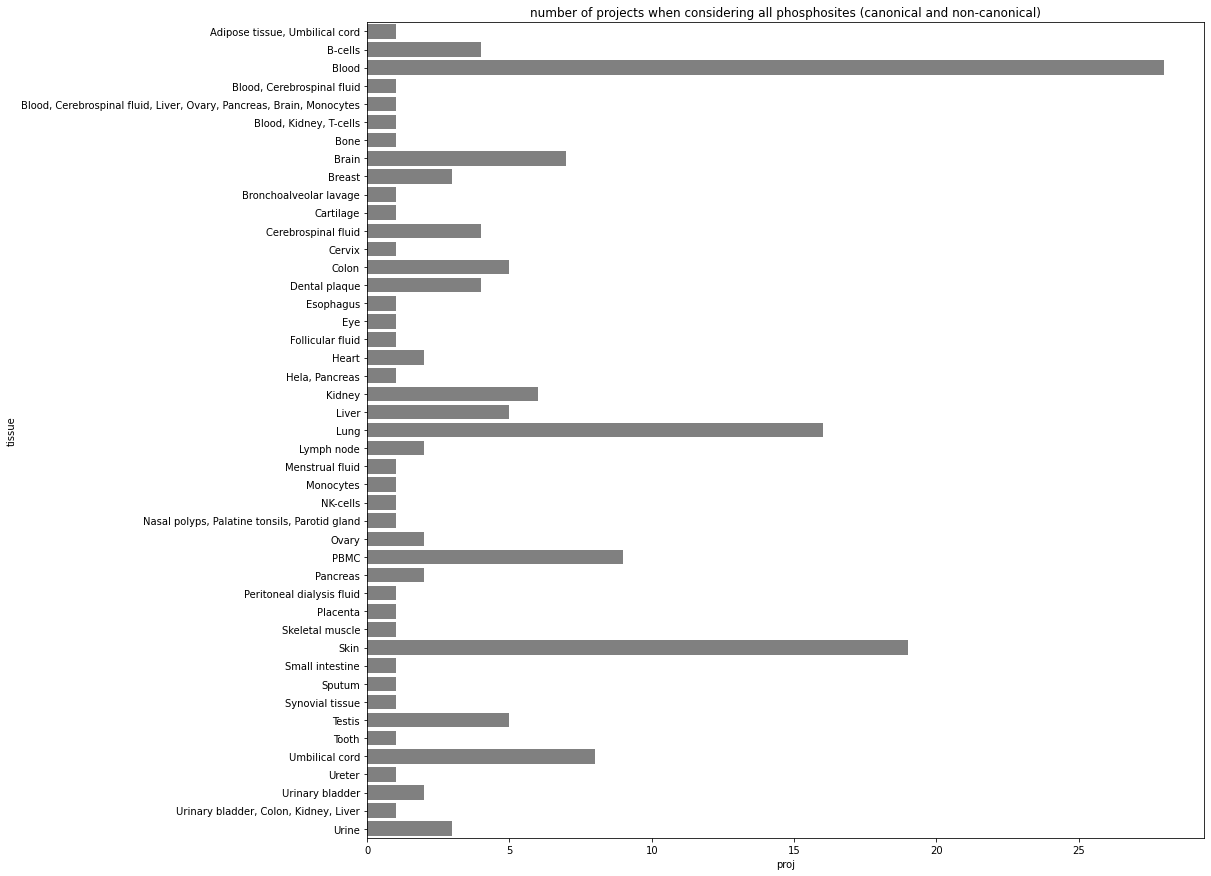

In [9]:
data_protein_tissue_counts = data.groupby(["tissue"], as_index=False)["proj"].nunique()
data_protein_tissue_counts.head()
plt.figure(figsize=(15,15))
sns.barplot(x=data_protein_tissue_counts["proj"], y=data_protein_tissue_counts["tissue"], color="grey").set(title = "number of projects when considering all phosphosites (canonical and non-canonical)")
plt.show()

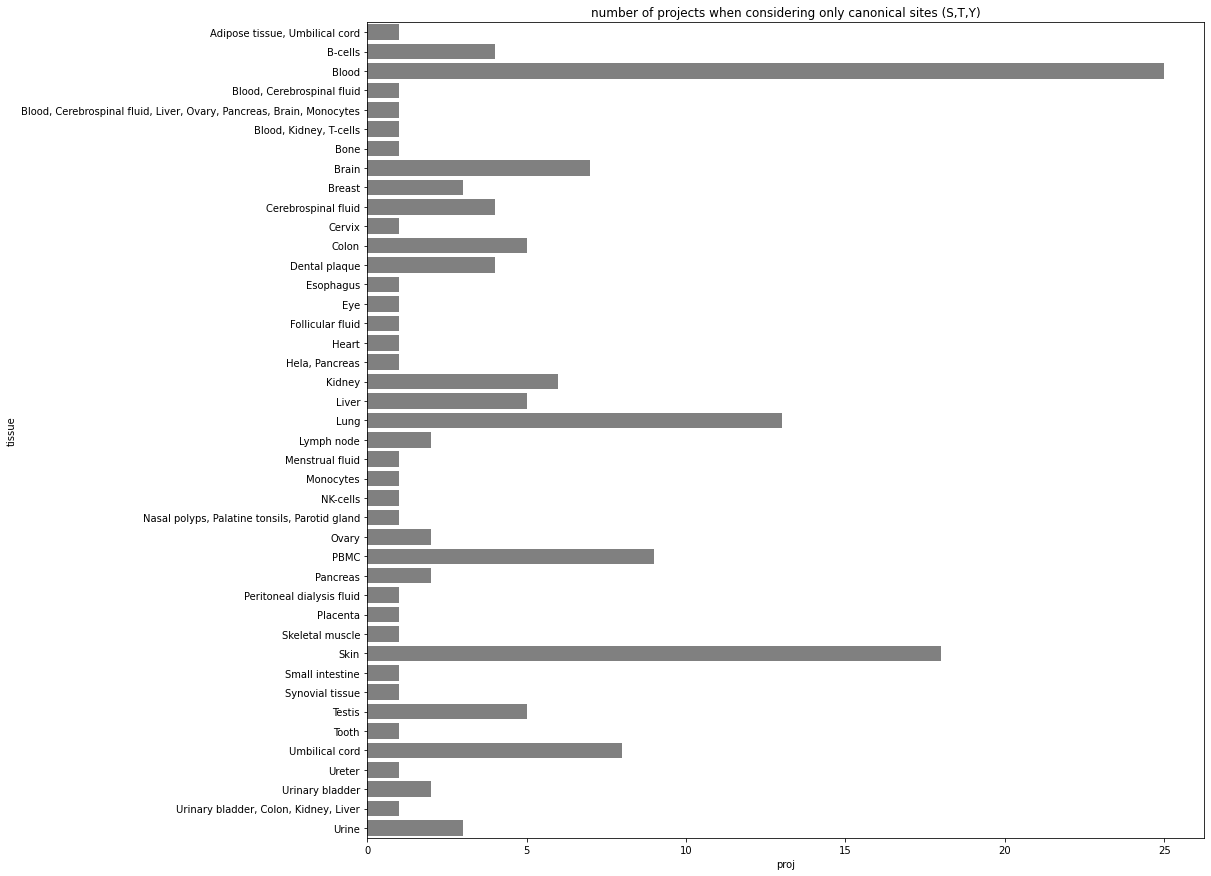

In [10]:
data_protein_tissue_counts_STY = data_STY.groupby(["tissue"], as_index=False)["proj"].nunique()
data_protein_tissue_counts_STY.head()
plt.figure(figsize=(15,15))
sns.barplot(x=data_protein_tissue_counts_STY["proj"], y=data_protein_tissue_counts_STY["tissue"], color="grey").set(title = "number of projects when considering only canonical sites (S,T,Y)")
plt.show()

Now, we want to investigate the amount of projects per tissue, for the canonical phosphosites. The previous example 'Blood, Cerebrospinal fluid', will be spilt up. For this, we first made a list of all tissues considered, for the data only considering the canonical sites. We group the data per project ID and combine the tissue entries, seperated by a comma. For each tissue in the list, we then verify whether it was indicated in the string that accompanies each unique project identifier. This is first indicated by a column per tissue showing either True if the column header was found, or False when it wasn't. This is then replaced by 1 and 0 respectively for easy downstream calculations. We then made a dataframe nr_proj_tissue_STY, with each tissue in a row in the first column. For the second column, we take each tissue column from our previous dataframe, indicating whether a project was associated with the tissue in the column header (1) or not (0), and take the sum of that column. This sum indicate the amount of projects in each tissue. We then stored these sums with the accompanying tissue in nr_proj_tissue_STY. These numbers were then shown in a similar graph as the two previous graphs.

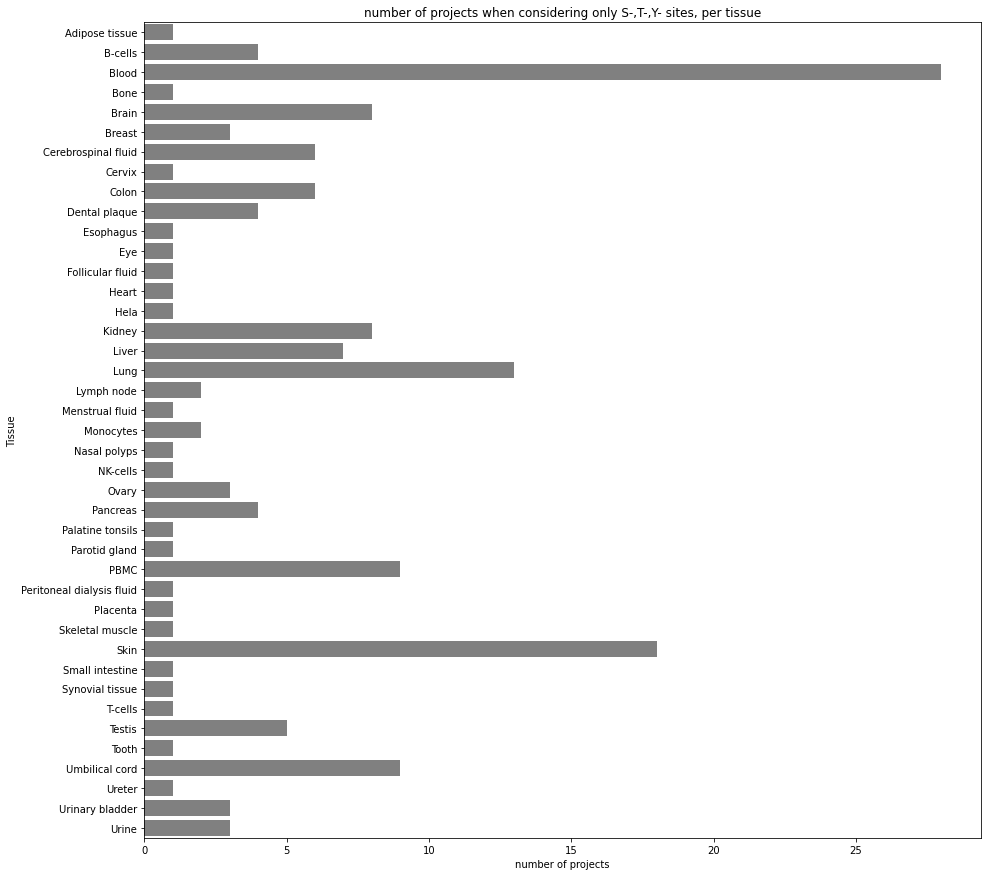

In [11]:
list_tissues_STY = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]
data_STY_proj = data_STY.groupby(["proj"], as_index=False)["tissue"].apply(lambda x: ",".join(x))
for tissue in list_tissues_STY:
    data_STY_proj[tissue] = data_STY_proj["tissue"].str.contains(tissue)
data_STY_proj.replace({True:1, False:0}, inplace=True)
nr_proj_tissue_STY = pd.DataFrame({"Tissue": list_tissues_STY})
list_counts_proj = []
for tissue in list_tissues_STY:
    count = data_STY_proj[tissue].sum()
    list_counts_proj.append(count)
nr_proj_tissue_STY["number of projects"] = list_counts_proj
plt.figure(figsize=(15,15))
sns.barplot(x=nr_proj_tissue_STY["number of projects"], y=nr_proj_tissue_STY["Tissue"], color="grey").set(title="number of projects when considering only S-,T-,Y- sites, per tissue")
plt.show()

We now want to know the amount of projects considering a single tissue, and the amount of projects considering multiple tissues per tissue. For this, we again take the original data, group it by project identifier, and take the first entry for tissue (as each entry for tissue in the same project will be the same). We then add columns for all tissues, indicating wheter project X was associated with tissue Y (1) or not (0), in a similar fashion as described above. We then summed the amount of tissues associated with each project. The ones associated with a single tissue and the ones associated with multiple tissues, were stored in seperate dataframes. We again made the sum of projects seen in a certain tissue, now seperate for the ones in a single tissue and for the ones in multiple tissues. These counts are shown in the table below. We can clearly see that Blood, Skin and Lung have the most projects. The tissues Adipose tissue, Hela, Nasal polyps, Palatine tonsils, Parotid gland and T-cells are only considered for multi-tissue projects.

In [12]:
list_tissues_STY = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]
data_STY_proj_2 = data_STY.groupby(["proj"], as_index=False)["tissue"].agg({"tissue": "first"})
for tissue in list_tissues_STY:
    data_STY_proj_2[tissue] = data_STY_proj_2["tissue"].str.contains(tissue)
data_STY_proj_2["Total"] = data_STY_proj_2[list_tissues_STY].sum(axis=1)
single_tissue_proj = data_STY_proj_2[data_STY_proj_2["Total"]==1].copy()
multiple_tissues_proj = data_STY_proj_2[data_STY_proj_2["Total"]>1].copy()
list_counts_single = []
list_counts_multiple = []
nr_proj_tissue_STY_split = pd.DataFrame({"Tissue": list_tissues_STY})
for tissue in list_tissues_STY:
    count_single = single_tissue_proj[tissue].sum()
    list_counts_single.append(count_single)
    count_multiple = multiple_tissues_proj[tissue].sum()
    list_counts_multiple.append(count_multiple)
nr_proj_tissue_STY_split["number of projects: single tissue"] = list_counts_single
nr_proj_tissue_STY_split["number of projects: multiple tissues"] = list_counts_multiple
nr_proj_tissue_STY_split

,Tissue,number of projects: single tissue,number of projects: multiple tissues
0,Adipose tissue,0,1
1,B-cells,4,0
2,Blood,25,3
3,Bone,1,0
4,Brain,7,1
5,Breast,3,0
6,Cerebrospinal fluid,4,2
7,Cervix,1,0
8,Colon,5,1
9,Dental plaque,4,0


<Figure size 1080x1080 with 0 Axes>

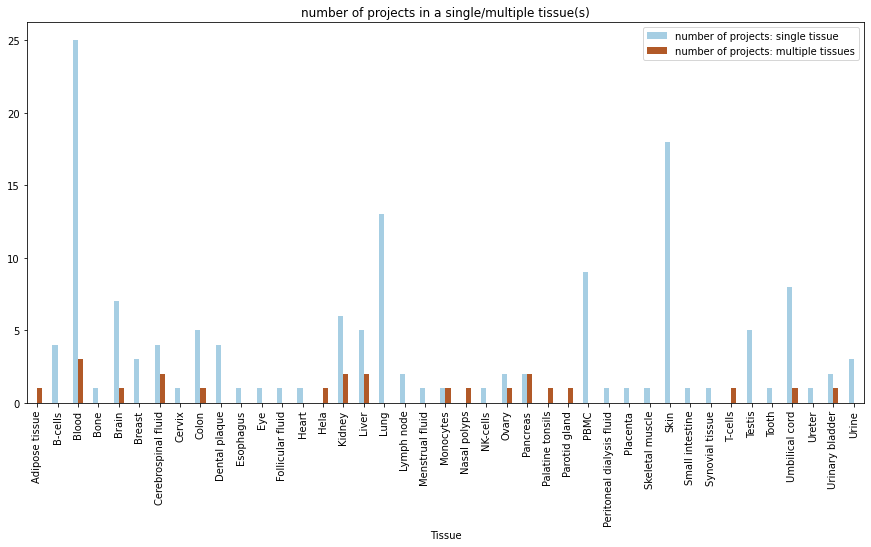

In [13]:
plt.figure(figsize=(15,15))
nr_proj_tissue_STY_split.plot(x="Tissue", kind="bar", figsize=(15,7), cmap="Paired", title = "number of projects in a single/multiple tissue(s)")
plt.show()

## number of residues

The number of residues phosphorylated in the entire dataset is calculated in two different ways. The results are the same. By far the most abundant one is Serine, as was expected. Unexpectedly, the second most abundant ones are glutamate and aspartate, followed by threonine. The remaining residues were found in significantly smaller amounts.

In [14]:
res_per_prot = data.groupby(["ACC_ID", "UP_POS"])["modres"].value_counts()
res_per_prot.groupby("modres").sum()
#data["modres"].value_counts()


modres
C     12414
D     68120
E     85364
H     11228
K     20495
R     11672
S    300903
T     61146
Y     15137
Name: modres, dtype: int64

In [15]:
data["modres"].value_counts()

S    300903
E     85364
D     68120
T     61146
K     20495
Y     15137
C     12414
R     11672
H     11228
Name: modres, dtype: int64

## number of proteins per tissue

Similar to the procedure applied above to find the number of projects. We made again a list of tissues. Then, for the original data, we grouped the proteins by unique ID. All entries for tissue for the same protein were combined in one long, comma seperated string. For all tissue entries in the list, it was verified for all proteins whether the tissue was present in this string at least once. If so, the table below will show true. If not, the table will display false. Further down, this is changed to 1 and 0 resepectively to simplify calculations. This is first done for all sites, later on for the canonical sites.

In [16]:
#For each protein, in how many tissues is it found?

list_tissues = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Bronchoalveolar lavage", "Cartilage", "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Sputum", "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]

data_protein = data[["ACC_ID", "tissue"]]
data_protein = data_protein.groupby(["ACC_ID"], as_index=False)["tissue"].apply(lambda x: ",".join(x))

for tissue in list_tissues:
    data_protein[tissue] = data_protein["tissue"].str.contains(tissue)

data_protein.iloc[30:40].head(10)

,ACC_ID,tissue,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,Bronchoalveolar lavage,Cartilage,...,Small intestine,Sputum,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine
30,A0A1B0GVK7,"PBMC,PBMC",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
31,A0A2R8Y619,"PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,P...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32,A0AUZ9,"Blood,Nasal polyps, Palatine tonsils, Parotid ...",False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33,A0AVK6,"Blood,Blood,Blood,Colon,Colon,Colon,Colon,Colo...",False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
34,A0AVT1,"PBMC,Skin,Adipose tissue, Umbilical cord",True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
35,A0FGR8,"Liver,Liver,Liver,Liver,Liver,Liver,Liver,Bloo...",False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
36,A0JLT2,"Blood,Blood,Blood,Blood,Blood,Colon,Colon,Colo...",False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37,A0JNW5,"Liver,Liver,Blood,Blood,Blood,Blood,Blood,Bloo...",False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,A0M8Q6,"Lung,Lung,Lung,Nasal polyps, Palatine tonsils,...",False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
39,A0MZ66,"Blood,Blood,Blood,Colon,Colon,Colon,Colon,Colo...",False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [17]:
data_protein.replace({True:1, False:0}, inplace=True)

data_protein["Total"] = data_protein.sum(axis=1)
data_protein.iloc[30:40].head(10)

C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/468637364.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_protein["Total"] = data_protein.sum(axis=1)


,ACC_ID,tissue,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,Bronchoalveolar lavage,Cartilage,...,Sputum,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine,Total
30,A0A1B0GVK7,"PBMC,PBMC",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
31,A0A2R8Y619,"PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,P...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
32,A0AUZ9,"Blood,Nasal polyps, Palatine tonsils, Parotid ...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
33,A0AVK6,"Blood,Blood,Blood,Colon,Colon,Colon,Colon,Colo...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
34,A0AVT1,"PBMC,Skin,Adipose tissue, Umbilical cord",1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4
35,A0FGR8,"Liver,Liver,Liver,Liver,Liver,Liver,Liver,Bloo...",0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,5
36,A0JLT2,"Blood,Blood,Blood,Blood,Blood,Colon,Colon,Colo...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
37,A0JNW5,"Liver,Liver,Blood,Blood,Blood,Blood,Blood,Bloo...",0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,9
38,A0M8Q6,"Lung,Lung,Lung,Nasal polyps, Palatine tonsils,...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
39,A0MZ66,"Blood,Blood,Blood,Colon,Colon,Colon,Colon,Colo...",0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4


The raph below shows the amount of tissues a specific protein is identified in. We consider tissue-specific phosphorylated proteins (1 tissue), non tissue-specific phosphorylated proteins (2-4 tissues), and general phosphorylated proteins (5 or more tissues). No proteins are seen in all 44 tissues (41 for the canonical sites only).

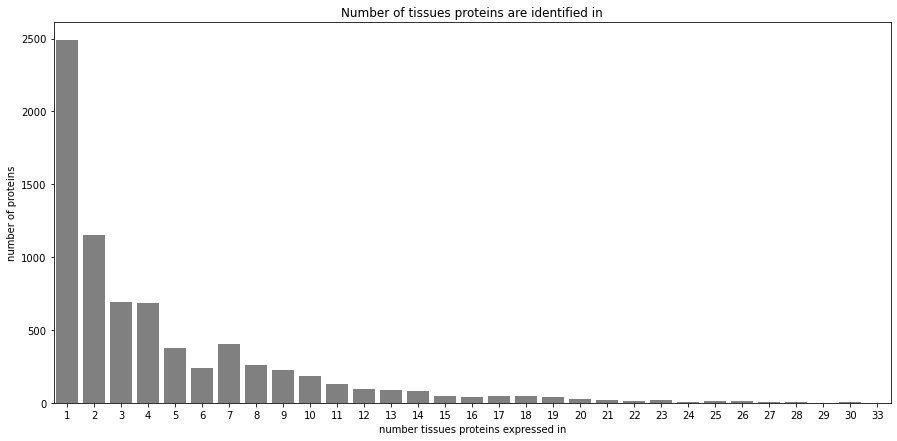

In [18]:
nr_tissues_expressed = data_protein.groupby(["Total"], as_index=False)["ACC_ID"].count()
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed["Total"],
            y=nr_tissues_expressed["ACC_ID"], color="grey").set(xlabel="number tissues proteins expressed in",
                                                  ylabel = "number of proteins", title = "Number of tissues proteins are identified in")
plt.show()

In [19]:
nr_tissues_expressed

,Total,ACC_ID
0,1,2487
1,2,1153
2,3,695
3,4,686
4,5,379
5,6,240
6,7,406
7,8,261
8,9,223
9,10,182


Were previously, we looked at the row level sums (how many tissues is protein expressed in), we'll now consider the column level: how many proteins are seen in a certain tissue? Clearly, the most proteins are found in Colon, Lymph node, Blood, Lung and Liver, which doesn't entirely correlate to the number of projects for each tissue. Lymph node, the second most abundant tissue, only had one project.

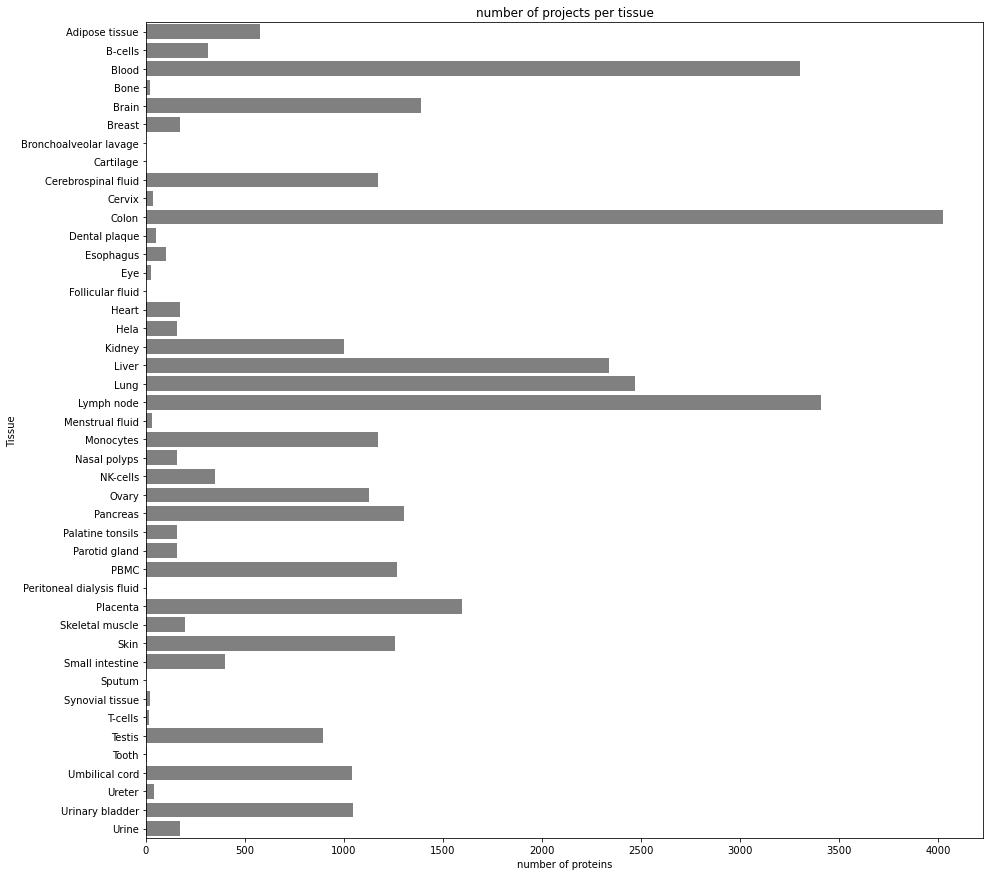

In [20]:
#the number of unique proteins in each tissue

df_proteins_tissue = pd.DataFrame({"Tissue": list_tissues})
list_counts = []
for tissue in list_tissues:
    count = data_protein[tissue].sum()
    list_counts.append(count)
df_proteins_tissue["number of proteins"] = list_counts
plt.figure(figsize=(15,15))
sns.barplot(x=df_proteins_tissue["number of proteins"], y=df_proteins_tissue["Tissue"], color="grey").set(title="number of projects per tissue")
plt.show()

## number of proteins when only considering S,T,Y phosphorylation

We recalculate the number of projects when we're only considering canonical sites. We then calculate the same things as above, in a similar fasion: the number of tissues proteins are expressed in, the number of proteins in all tissues, and we verify that only STY sites remained. Of note, three tissues only contained non canonical sites: Bronchoalveolar lavage, Cartilage, Sputum.

In [21]:
data_STY = data[(data["modres"]=="S")|(data["modres"]=="T")|(data["modres"]=="Y")]
nr_proj_STY = data_STY["proj"].nunique()
print(nr_proj_STY)
data_STY["modres"].value_counts()

150


S    300903
T     61146
Y     15137
Name: modres, dtype: int64

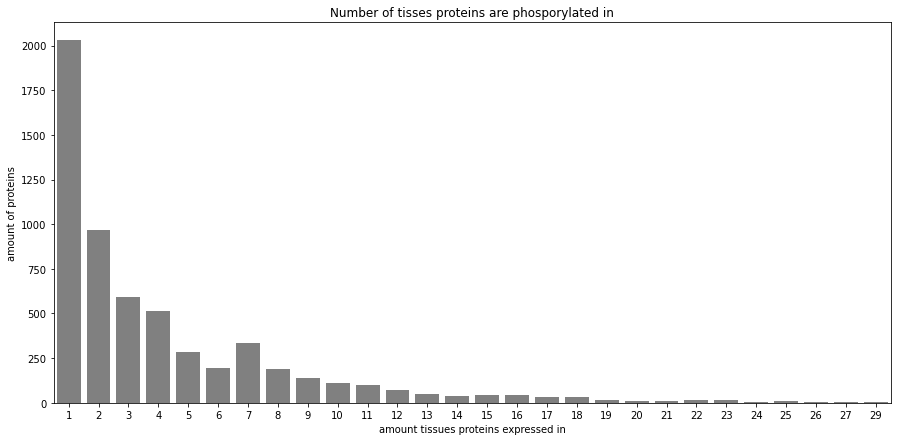

In [22]:
#How many proteins in tissues when only considering S,T,Y
list_tissues = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Bronchoalveolar lavage", "Cartilage", "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Sputum", "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]
data_site = data[["ACC_ID", "UP_POS", "tissue", "modres"]]
data_site = data_site.groupby(["ACC_ID", "UP_POS"], as_index=False)[["tissue", "modres"]].agg({"tissue": lambda x:
                                                              ",".join(x),
                                                                        "modres": "first"})
for tissue in list_tissues:
    data_site[tissue] = data_site["tissue"].str.contains(tissue)
data_site.replace({True:1, False:0}, inplace=True)
data_protein_STY = data_site[(data_site["modres"]=="S")|(data_site["modres"]=="T")|(data_site["modres"]=="Y")]
data_protein_STY = data_protein_STY.groupby(["ACC_ID"], as_index=False)[list_tissues].max()
data_protein_STY["Total"] = data_protein_STY[list_tissues].sum(axis=1)
nr_tissues_expressed_STY = data_protein_STY.groupby(["Total"], as_index=False)["ACC_ID"].nunique()
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_STY["Total"],
            y=nr_tissues_expressed_STY["ACC_ID"], color="grey").set(xlabel="amount tissues proteins expressed in",
                                                  ylabel = "amount of proteins", title="Number of tisses proteins are phosporylated in")
plt.show()

In [23]:
nr_tissues_expressed_STY["relative abundance"] = nr_tissues_expressed_STY["ACC_ID"]*100/nr_tissues_expressed_STY["ACC_ID"].sum()
print(nr_tissues_expressed_STY[nr_tissues_expressed_STY["Total"]==1]["relative abundance"].sum())
print(nr_tissues_expressed_STY[(nr_tissues_expressed_STY["Total"]>1)&(nr_tissues_expressed_STY["Total"]<5)]["relative abundance"].sum())
print(nr_tissues_expressed_STY[nr_tissues_expressed_STY["Total"]>=5]["relative abundance"].sum())

34.654141759180185
35.42271562766866
29.923142613151153


Based on the graph above, we have categorrised proteins in accordance to the number of tissues they have been found phosphorylated in. The graph below shows the relative amount of proteins identified in a certain amount of tissues, coloured in accordance to the category these proteins have been attributed to. Proteins identified in 1 tissue are labeled as tissue-specific, proteins identified in 2-4 tissues are labeled as tissue aspecific and the remaining proteins are labeled as pervasively phosphorylated proteins. The same graph was made for the absolute amount of proteins.

In [24]:
nr_tissues_expressed_STY["Type"] = "Pervasively phosphorylated proteins"
nr_tissues_expressed_STY.loc[nr_tissues_expressed_STY["Total"]==1, "Type"] = "Tissue-specific phosphorylated proteins"
nr_tissues_expressed_STY.loc[(nr_tissues_expressed_STY["Total"]>1)&(nr_tissues_expressed_STY["Total"]<5), "Type"] = "Tissue aspecific phosphorylated proteins"

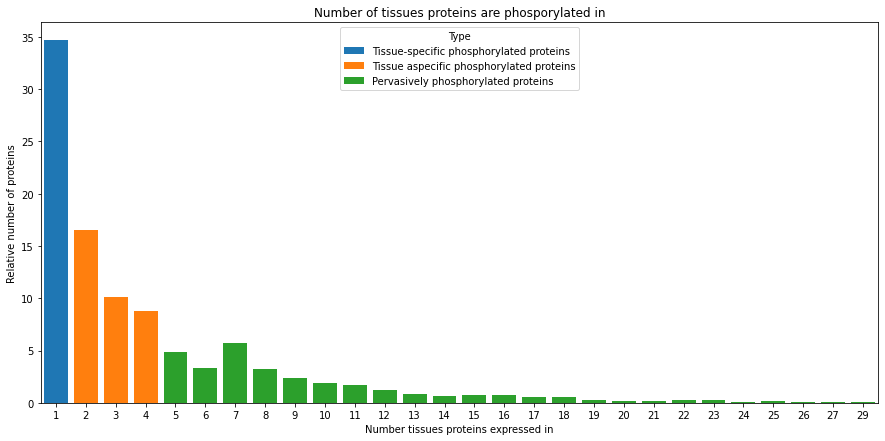

In [25]:
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_STY["Total"],
            y=nr_tissues_expressed_STY["relative abundance"], hue=nr_tissues_expressed_STY["Type"], dodge=False, saturation=1).set(xlabel="Number tissues proteins expressed in",
                                                  ylabel = "Relative number of proteins", title="Number of tissues proteins are phosporylated in")
#plt.savefig("Relative abundance of proteins per number of tissues.png", format="png", bbox_inches="tight")
plt.show()

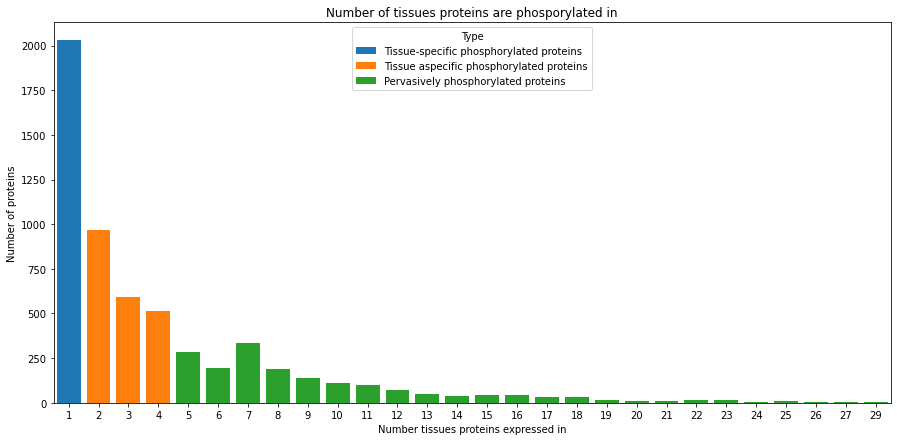

In [26]:
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_STY["Total"],
            y=nr_tissues_expressed_STY["ACC_ID"], hue=nr_tissues_expressed_STY["Type"], dodge=False, saturation=1).set(xlabel="Number tissues proteins expressed in",
                                                  ylabel = "Number of proteins", title="Number of tissues proteins are phosporylated in")
#plt.savefig("Absolute abundance of proteins per number of tissues.png", format="png", bbox_inches="tight")
plt.show()

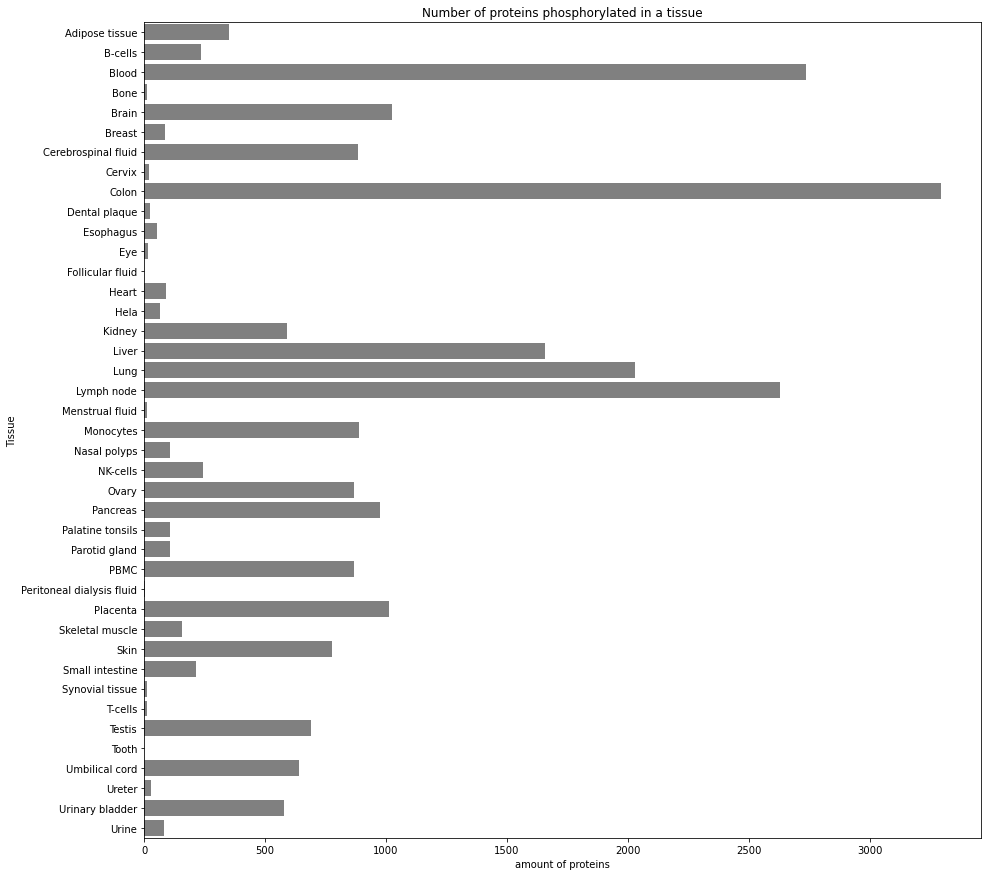

In [27]:
list_tissues_STY = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]
df_proteins_tissue_STY = pd.DataFrame({"Tissue": list_tissues_STY})
list_counts_STY = []
for tissue in list_tissues_STY:
    count = data_protein_STY[tissue].sum()
    list_counts_STY.append(count)
df_proteins_tissue_STY["amount of proteins"] = list_counts_STY
plt.figure(figsize=(15,15))
sns.barplot(x=df_proteins_tissue_STY["amount of proteins"], y=df_proteins_tissue_STY["Tissue"], color="grey").set(title="Number of proteins phosphorylated in a tissue")
plt.show()

In [28]:
df_proteins_tissue_STY

,Tissue,amount of proteins
0,Adipose tissue,350
1,B-cells,233
2,Blood,2737
3,Bone,11
4,Brain,1026
5,Breast,87
6,Cerebrospinal fluid,884
7,Cervix,18
8,Colon,3297
9,Dental plaque,25


In [29]:
no_STY_proteins = df_proteins_tissue_STY[(df_proteins_tissue_STY["amount of proteins"]==0)]
no_STY_proteins

,Tissue,amount of proteins


## number of sites per tissue

The same type of calculations are done on the phosphosite level. Again, this is first done including the non canonical sites, and later on excluding them.

In [30]:
#for each site, in how many tissues was it found?
list_tissues = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Bronchoalveolar lavage", "Cartilage", "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Sputum", "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]

data_site = data[["ACC_ID", "UP_POS", "tissue"]]
data_site = data_site.groupby(["ACC_ID", "UP_POS"], as_index=False)["tissue"].apply(lambda x: ",".join(x))

for tissue in list_tissues:
    data_site[tissue] = data_site["tissue"].str.contains(tissue)
    
data_site.replace({True:1, False:0}, inplace=True)
col_list = list(data_site)
col_list.remove("UP_POS")

data_site["Total"] = data_site[col_list].sum(axis=1)

data_site.iloc[10:20].head(10)

C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/3090478304.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_site["Total"] = data_site[col_list].sum(axis=1)


,ACC_ID,UP_POS,tissue,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,Bronchoalveolar lavage,...,Sputum,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine,Total
10,A0A096LP55,37,Liver,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,A0A0A0MS15,71,PBMC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12,A0A0B4J2A2,62,"Umbilical cord,Umbilical cord,Umbilical cord,S...",0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,7
13,A0A0B4J2D5,124,PBMC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14,A0A0B4J2D5,145,PBMC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15,A0A0B4J2D5,177,"Placenta,Placenta",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16,A0A0B4J2D5,203,PBMC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
17,A0A0B4J2D9,52,"Blood,Blood,Blood",0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18,A0A0B4J2F2,435,Placenta,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19,A0A0C4DH24,75,Skeletal muscle,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
data_site

,ACC_ID,UP_POS,tissue,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,Bronchoalveolar lavage,...,Sputum,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine,Total
0,A0A075B6H7,30,Lung,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,A0A075B6S5,52,Menstrual fluid,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,A0A075B759,62,"Umbilical cord,Umbilical cord,Umbilical cord,S...",0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,7
3,A0A075B767,62,"Umbilical cord,Umbilical cord,Umbilical cord,S...",0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,7
4,A0A087WV62,102,"Urinary bladder, Colon, Kidney, Liver",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46434,Q9Y6Y0,340,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
46435,Q9Y6Y1,1347,Colon,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
46436,Q9Y6Y8,737,Colon,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
46437,Q9Y6Y8,925,"Colon,Colon,Colon,Colon,Colon,Colon,Colon",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


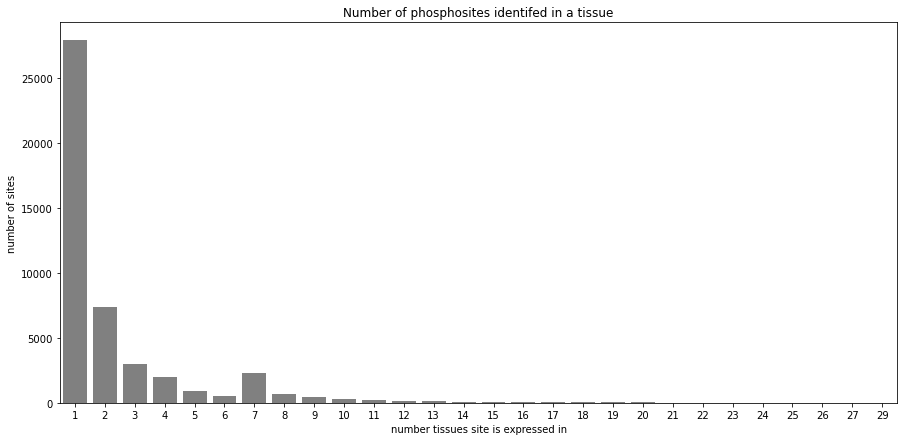

In [32]:
nr_tissues_expressed_sites = data_site.groupby(["Total"], as_index=False)["UP_POS"].count()

plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_sites["Total"],
            y=nr_tissues_expressed_sites["UP_POS"], color="grey").set(xlabel="number tissues site is expressed in",
                                                  ylabel = "number of sites", title="Number of phosphosites identifed in a tissue")
plt.show()

Again, Colon, Lymph node, Blood, Lung and Liver are the most represented.

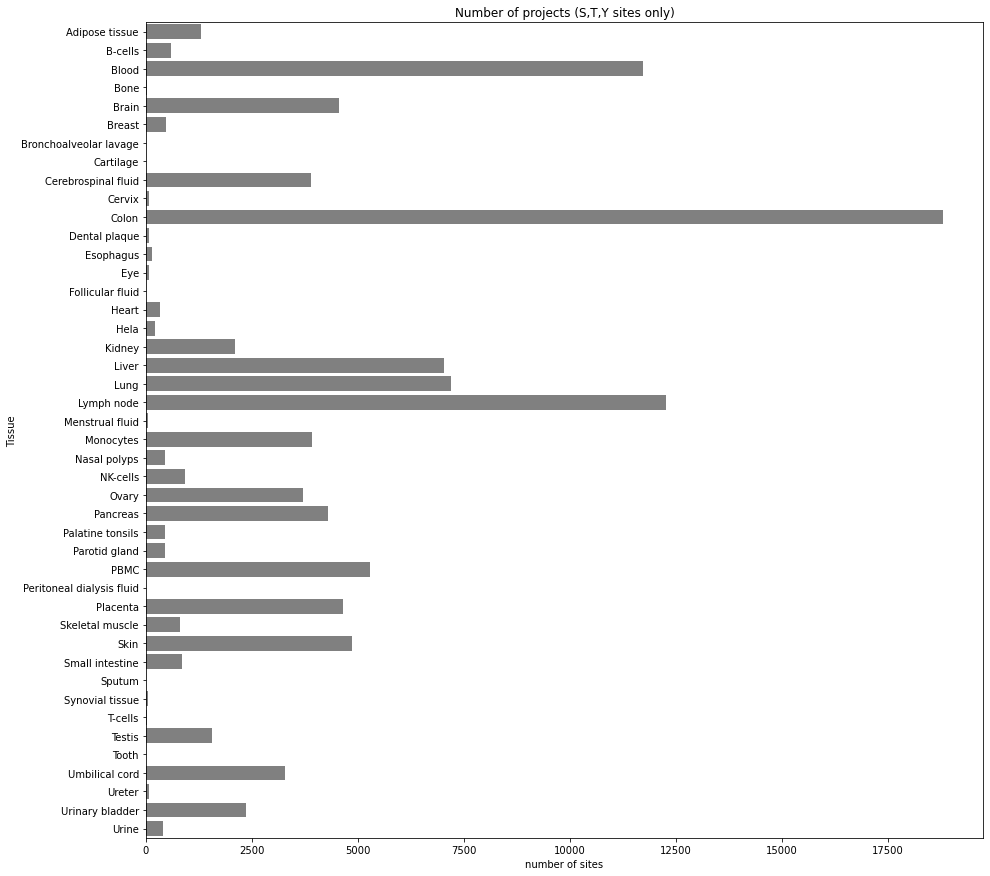

In [33]:
#number of unique sites in a tissue

df_sites_tissue = pd.DataFrame({"Tissue": list_tissues})
list_counts = []
for tissue in list_tissues:
    count = data_site[tissue].sum()
    list_counts.append(count)
df_sites_tissue["number of sites"] = list_counts
plt.figure(figsize=(15,15))
sns.barplot(x=df_sites_tissue["number of sites"], y=df_sites_tissue["Tissue"], color="grey").set(title="Number of projects (S,T,Y sites only)")
plt.show()

## number of sites per tissue when only considering S,T,Y phosphorylation

C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/2562477224.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_site_STY["Total"] = data_site_STY[list_tissues].sum(axis=1)


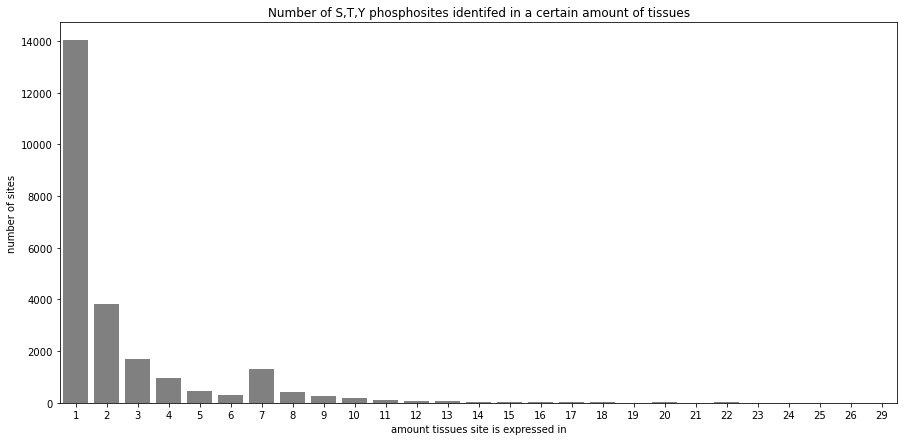

In [34]:
list_tissues = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Bronchoalveolar lavage", "Cartilage", "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Sputum", "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]
data_site = data[["ACC_ID", "UP_POS", "tissue", "modres"]]
data_site = data_site.groupby(["ACC_ID", "UP_POS"], as_index=False)[["tissue", "modres"]].agg({"tissue": lambda x:
                                                              ",".join(x),
                                                                        "modres": "first"}
                                                                       )
for tissue in list_tissues:
    data_site[tissue] = data_site["tissue"].str.contains(tissue)
data_site.replace({True:1, False:0}, inplace=True)
data_site_STY = data_site[(data_site["modres"]=="S")|(data_site["modres"]=="T")|(data_site["modres"]=="Y")]
data_site_STY["Total"] = data_site_STY[list_tissues].sum(axis=1)
nr_tissues_expressed_STY_sites = data_site_STY.groupby(["Total"], as_index=False)["UP_POS"].count()
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_STY_sites["Total"],
            y=nr_tissues_expressed_STY_sites["UP_POS"], color="grey").set(xlabel="amount tissues site is expressed in",
                                                  ylabel = "number of sites", title="Number of S,T,Y phosphosites identifed in a certain amount of tissues")
plt.show()

In [35]:
nr_tissues_expressed_STY_sites["relative abundance"] = nr_tissues_expressed_STY_sites["UP_POS"]*100/nr_tissues_expressed_STY_sites["UP_POS"].sum()
print(nr_tissues_expressed_STY_sites[nr_tissues_expressed_STY_sites["Total"]==1]["relative abundance"].sum())
print(nr_tissues_expressed_STY_sites[(nr_tissues_expressed_STY_sites["Total"]>1)&(nr_tissues_expressed_STY_sites["Total"]<5)]["relative abundance"].sum())
print(nr_tissues_expressed_STY_sites[nr_tissues_expressed_STY_sites["Total"]>=5]["relative abundance"].sum())

58.64954189850646
27.101200686106345
14.24925741538719


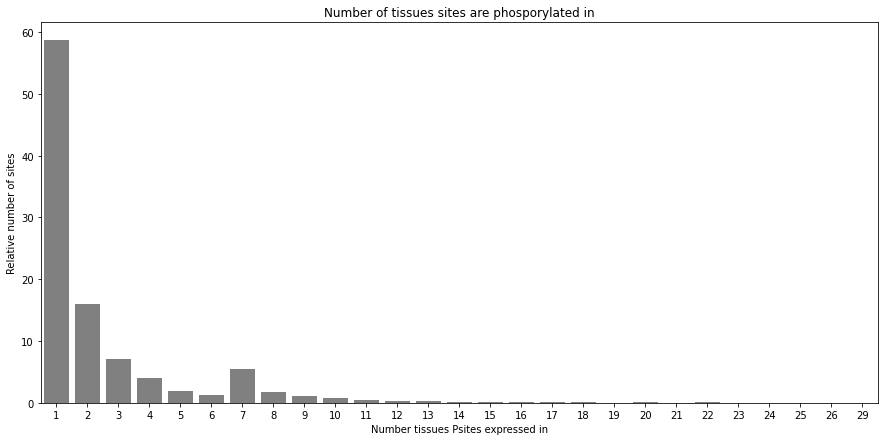

In [36]:
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_STY_sites["Total"],
            y=nr_tissues_expressed_STY_sites["relative abundance"], color="grey").set(xlabel="Number tissues Psites expressed in",
                                                  ylabel = "Relative number of sites", title="Number of tissues sites are phosporylated in")
#plt.savefig("Relative abundance of Psites per number of tissues.png", format="png", bbox_inches="tight")
plt.show()

In [37]:
nr_tissues_expressed_STY_sites["Type"] = "Pervasive Psites"
nr_tissues_expressed_STY_sites.loc[nr_tissues_expressed_STY_sites["Total"]==1, "Type"] = "Tissue-specific Psites"
nr_tissues_expressed_STY_sites.loc[(nr_tissues_expressed_STY_sites["Total"]>1)&(nr_tissues_expressed_STY_sites["Total"]<5), "Type"] = "Tissue aspecific Psites"

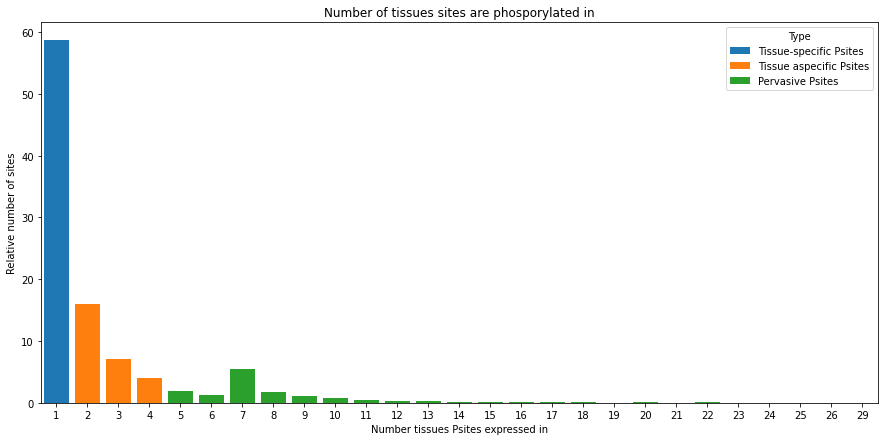

In [38]:
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_STY_sites["Total"],
            y=nr_tissues_expressed_STY_sites["relative abundance"], hue=nr_tissues_expressed_STY_sites["Type"], dodge=False, saturation=1).set(xlabel="Number tissues Psites expressed in",
                                                  ylabel = "Relative number of sites", title="Number of tissues sites are phosporylated in")
#plt.savefig("Relative abundance of Psites per number of tissues.png", format="png", bbox_inches="tight")
plt.show()

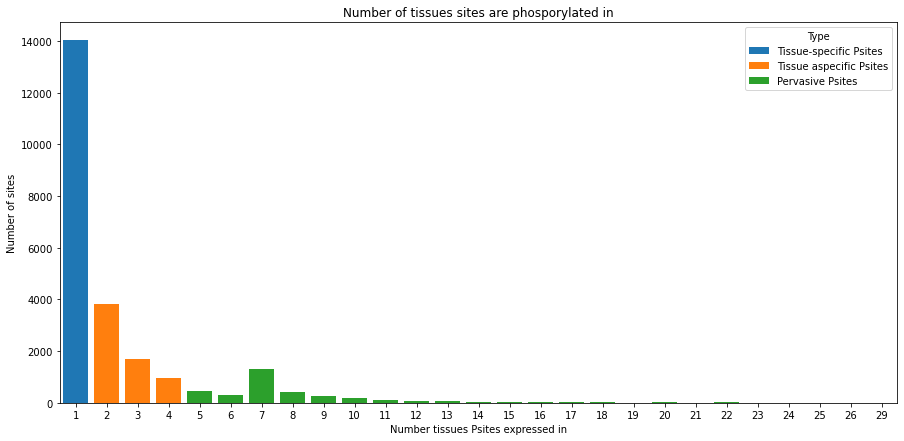

In [39]:
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_STY_sites["Total"],
            y=nr_tissues_expressed_STY_sites["UP_POS"], hue=nr_tissues_expressed_STY_sites["Type"], dodge=False, saturation=1).set(xlabel="Number tissues Psites expressed in",
                                                  ylabel = "Number of sites", title="Number of tissues sites are phosporylated in")
#plt.savefig("Absolute abundance of Psites per number of tissues.png", format="png", bbox_inches="tight")
plt.show()

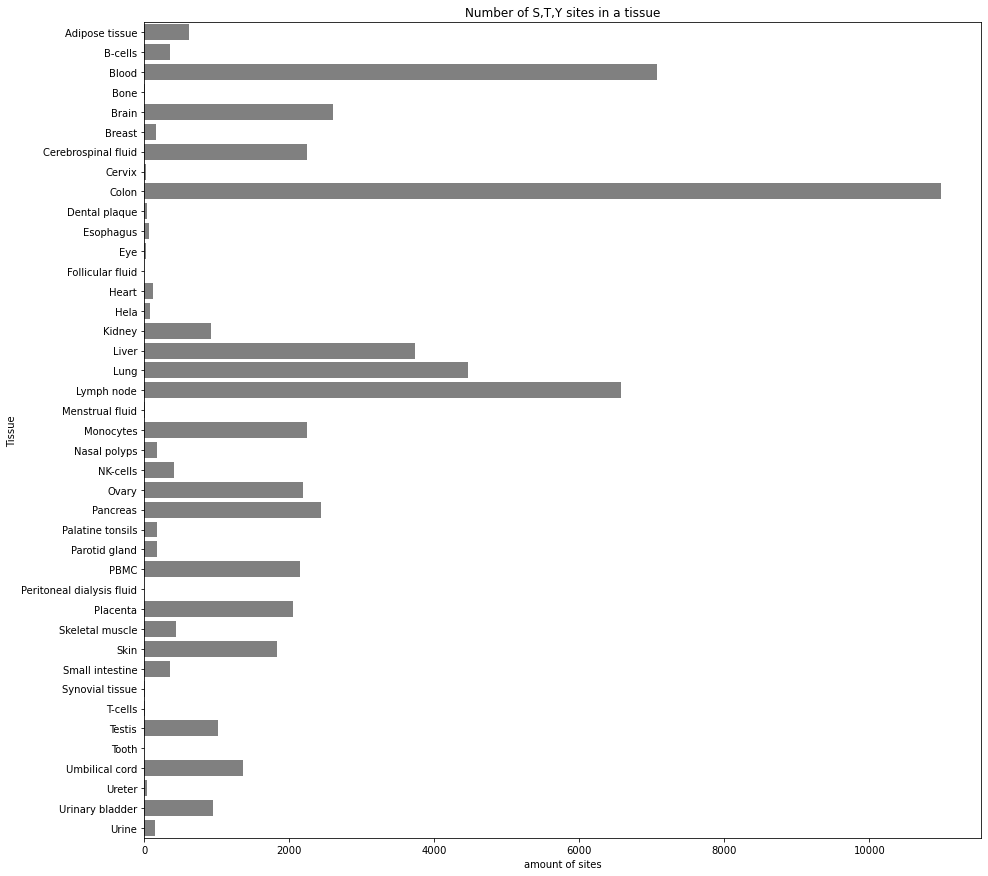

In [40]:
list_tissues = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
               "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]
df_sites_tissue_STY = pd.DataFrame({"Tissue": list_tissues})
list_counts = []
for tissue in list_tissues:
    count = data_site_STY[tissue].sum()
    list_counts.append(count)
df_sites_tissue_STY["amount of sites"] = list_counts
plt.figure(figsize=(15,15))
sns.barplot(x=df_sites_tissue_STY["amount of sites"], y=df_sites_tissue_STY["Tissue"], color="grey").set(title="Number of S,T,Y sites in a tissue")
plt.show()
#overal the plot looks different, but the scale has changed

In [41]:
df_sites_tissue_STY

,Tissue,amount of sites
0,Adipose tissue,611
1,B-cells,361
2,Blood,7069
3,Bone,13
4,Brain,2604
5,Breast,157
6,Cerebrospinal fluid,2242
7,Cervix,28
8,Colon,10992
9,Dental plaque,44


In [42]:
df_sites_tissue_STY[(df_sites_tissue_STY["amount of sites"]==0)]

,Tissue,amount of sites


The number of residues is calculated and compared to the total number of sites in percentages.

In [43]:
values_modres = data_site_STY["modres"].value_counts()
percentage_S = values_modres[0]/nr_sites_STY
percentage_T = values_modres[1]/nr_sites_STY
percentage_Y = values_modres[2]/nr_sites_STY
print(values_modres)
print(percentage_S, percentage_T, percentage_Y)

S    16695
T     5616
Y     1592
Name: modres, dtype: int64
0.6984478935698448 0.23494958791783457 0.06660251851232063


In [44]:
#percentages displayed here are a bit of average: 0.84, 0.15 and less than 1 percent for S,T,Y respectively

### looking at organ systems

Tissues are summarised in organ systems (https://en.wikipedia.org/wiki/Organ_system). A list of systems is made, as well as list for each system describing which tissues are summarised in it. Then, similar calculations as for the tissues are repeated here. If a protein is seen in a system than entails that tissue, the column of that system will be denoted with a one. Later on, the amount of systems a tissue is seen in is calculated, as well as the amount of proteins in each system. This is first done including the non canonical sites and later on focussing on the canonical sites only. The calculations are repeated on the phosphosite level.

In [45]:
list_systems = ["Circulatory system", "Digestive system", "Endocrine system", "Immune system and lymfatic system",
                "Integumentary system", "Muscular system", "Nervous system", "Reproductive system", "Respiratory system",
                "Skeletal system", "Urinary and renal system"]
data_site_STY.drop(["Bronchoalveolar lavage", "Cartilage", "Sputum"] , axis=1, inplace=True)
list_circulatory = ["Blood", "Cerebrospinal fluid", "Peritoneal dialysis fluid"]
list_reproductive = ["Breast", "Cervix", "Follicular fluid", "Hela", "Menstrual fluid", "Ovary", "Placenta", "Testis",
                    "Umbilical cord"]
list_digestive = ["Colon", "Dental plaque", "Esophagus", "Liver", "Parotid gland", "Pancreas", "Small intestine",
                 "Tooth"]
list_respiratory = ["Lung", "Nasal polyps"]
list_urinary = ["Kidney", "Ureter", "Urinary bladder", "Urine"]
list_endocrine = ["Adipose tissue"]
                  #, "Pancreas", "Placenta", "Ovary", "Testis"
                 
list_integumentary = ["Skin"]
list_immune = ["B-cells", "Lymph node", "Monocytes", "NK-cells", "Palatine tonsil", "PBMC", "T-cells"]
list_muscular = ["Heart", "Skeletal muscle"]
list_nervous = ["Brain", "Eye"]
list_skeletal = ["Bone", "Synovial tissue"]
#list_tissues.remove("Bronchoalveolar lavage") #these tissues no longer have any data when we remove the non-STY sites
#list_tissues.remove("Cartilage")
#list_tissues.remove("Sputum")
for system in list_systems:
    data_protein_STY.loc[:, system]=0
for tissue in list_tissues:
    if tissue in list_circulatory:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Circulatory system"]=1
    if tissue in list_digestive:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Digestive system"]=1
    if tissue in list_endocrine:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Endocrine system"]=1
    if tissue in list_immune:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Immune system and lymfatic system"]=1
    if tissue in list_integumentary:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Integumentary system"]=1
    if tissue in list_muscular:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Muscular system"]=1
    if tissue in list_nervous:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Nervous system"]=1
    if tissue in list_reproductive:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Reproductive system"]=1
    if tissue in list_respiratory:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Respiratory system"]=1
    if tissue in list_skeletal:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Skeletal system"]=1
    if tissue in list_urinary:
        data_protein_STY.loc[data_protein_STY[tissue]==1, "Urinary and renal system"]=1

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
data_protein_STY.head(10)

,ACC_ID,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,Bronchoalveolar lavage,Cartilage,Cerebrospinal fluid,...,Digestive system,Endocrine system,Immune system and lymfatic system,Integumentary system,Muscular system,Nervous system,Reproductive system,Respiratory system,Skeletal system,Urinary and renal system
0,A0A075B6H7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,A0A075B6S5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A0A087WXM9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,A0A0B4J2D5,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,A0A0B4J2D9,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,A0A0B4J2F2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,A0A0C4DH24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,A0A0C4DH36,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,A0A0C4DH39,0,0,1,0,1,0,0,0,1,...,1,0,1,0,0,1,1,0,0,0
9,A0A0C4DH67,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Three proteins are seen in all organ systems.

In [47]:
# calculating the amount of organ systems entries are seen in
data_protein_STY["Total_systems"] = data_protein_STY[list_systems].sum(axis=1)
data_protein_STY.head()
#print(data_protein_STY[data_protein_STY["Total_systems"]==11])

,ACC_ID,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,Bronchoalveolar lavage,Cartilage,Cerebrospinal fluid,...,Endocrine system,Immune system and lymfatic system,Integumentary system,Muscular system,Nervous system,Reproductive system,Respiratory system,Skeletal system,Urinary and renal system,Total_systems
0,A0A075B6H7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,A0A075B6S5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,A0A087WXM9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,A0A0B4J2D5,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,A0A0B4J2D9,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


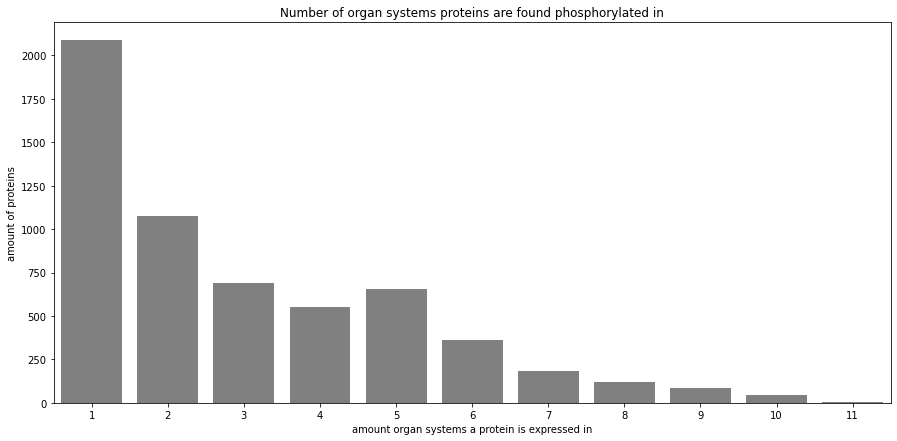

    Total_systems  ACC_ID
0               1    2086
1               2    1077
2               3     691
3               4     551
4               5     657
5               6     361
6               7     181
7               8     121
8               9      83
9              10      44
10             11       3
The total amount of proteins is: 5855
    Total_systems  ACC_ID
10             11       3


In [48]:
STY_organsystem_protein = data_protein_STY.groupby(["Total_systems"], as_index=False)["ACC_ID"].nunique()
plt.figure(figsize=(15,7))
sns.barplot(x=STY_organsystem_protein["Total_systems"],
            y=STY_organsystem_protein["ACC_ID"], color="grey").set(xlabel="amount organ systems a protein is expressed in",
                                                  ylabel = "amount of proteins", title="Number of organ systems proteins are found phosphorylated in")
plt.show()
print(STY_organsystem_protein)
print("The total amount of proteins is: {}".format(STY_organsystem_protein["ACC_ID"].sum()))
print(STY_organsystem_protein[STY_organsystem_protein["Total_systems"]==11])

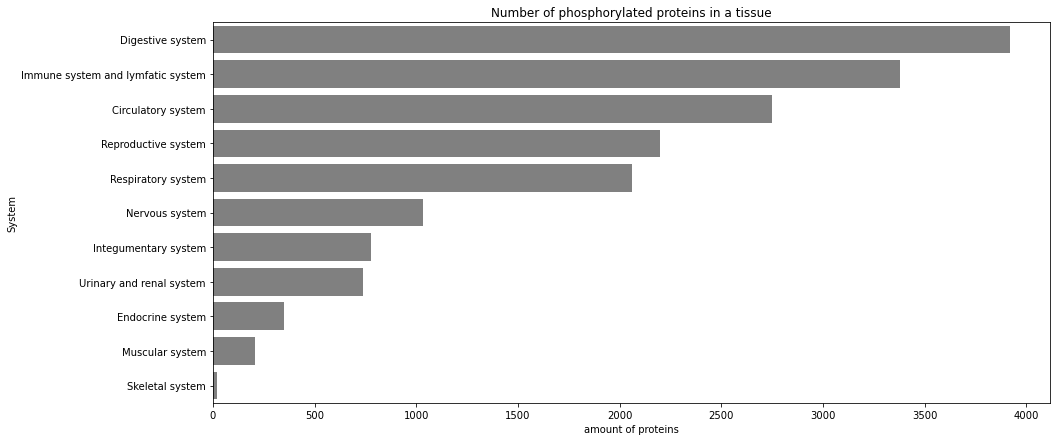

In [49]:
df_proteins_systems_STY = pd.DataFrame({"System": list_systems})
list_systemcounts_STY = []
for system in list_systems:
    count = data_protein_STY[system].sum()
    list_systemcounts_STY.append(count)
df_proteins_systems_STY["amount of proteins"] = list_systemcounts_STY
df_proteins_systems_STY.sort_values(["amount of proteins"], ascending=False, inplace=True)
plt.figure(figsize=(15,7))
sns.barplot(x=df_proteins_systems_STY["amount of proteins"], y=df_proteins_systems_STY["System"], color="grey").set(title="Number of phosphorylated proteins in a tissue")
plt.show()

In [50]:
data_protein_STY.head()

,ACC_ID,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,Bronchoalveolar lavage,Cartilage,Cerebrospinal fluid,...,Endocrine system,Immune system and lymfatic system,Integumentary system,Muscular system,Nervous system,Reproductive system,Respiratory system,Skeletal system,Urinary and renal system,Total_systems
0,A0A075B6H7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,A0A075B6S5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,A0A087WXM9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,A0A0B4J2D5,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,A0A0B4J2D9,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


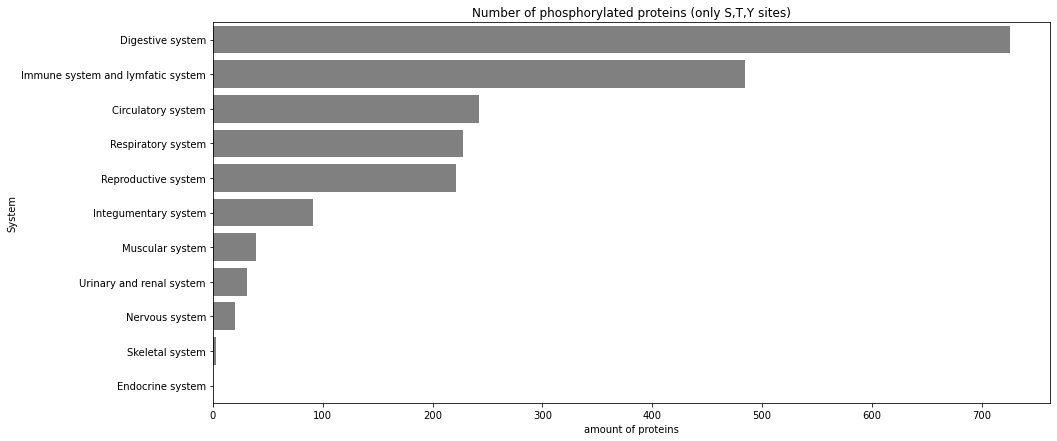

In [51]:
df_proteins_onesystem_STY = pd.DataFrame({"System": list_systems})
list_systemcounts_STY = []
for system in list_systems:
    count = data_protein_STY.loc[data_protein_STY["Total_systems"]==1, system].sum()
    list_systemcounts_STY.append(count)
df_proteins_onesystem_STY["amount of proteins"] = list_systemcounts_STY
df_proteins_onesystem_STY.sort_values(["amount of proteins"], ascending=False, inplace=True)
plt.figure(figsize=(15,7))
sns.barplot(x=df_proteins_onesystem_STY["amount of proteins"], y=df_proteins_onesystem_STY["System"], color="grey").set(title = "Number of phosphorylated proteins (only S,T,Y sites)")
plt.show()

In [52]:
df_proteins_onesystem_STY

,System,amount of proteins
1,Digestive system,726
3,Immune system and lymfatic system,485
0,Circulatory system,242
8,Respiratory system,228
7,Reproductive system,221
4,Integumentary system,91
5,Muscular system,39
10,Urinary and renal system,31
6,Nervous system,20
9,Skeletal system,3


In [53]:
list_systems = ["Circulatory system", "Digestive system", "Endocrine system", "Immune system and lymfatic system",
                "Integumentary system", "Muscular system", "Nervous system", "Reproductive system", "Respiratory system",
                "Skeletal system", "Urinary and renal system"]
#data_site_STY.drop(["Bronchoalveolar lavage", "Cartilage", "Sputum"] , axis=1, inplace=True)
list_circulatory = ["Blood", "Cerebrospinal fluid", "Peritoneal dialysis fluid"]
list_reproductive = ["Breast", "Cervix", "Follicular fluid", "Hela", "Menstrual fluid", "Ovary", "Placenta", "Testis",
                    "Umbilical cord"]
list_digestive = ["Colon", "Dental plaque", "Esophagus", "Liver", "Parotid gland", "Pancreas", "Small intestine",
                 "Tooth"]
list_respiratory = ["Lung", "Nasal polyps"]
list_urinary = ["Kidney", "Ureter", "Urinary bladder", "Urine"]
list_endocrine = ["Adipose tissue"]
                  #"Pancreas", "Placenta", "Ovary", "Testis"
                 #pancreas is roughly 99% exocrine (ie digestive system) and 1% endocrine
list_integumentary = ["Skin"]
list_immune = ["B-cells", "Lymph node", "Monocytes", "NK-cells", "Palatine tonsil", "PBMC", "T-cells"]
list_muscular = ["Heart", "Skeletal muscle"]
list_nervous = ["Brain", "Eye"]
list_skeletal = ["Bone", "Synovial tissue"]
#list_tissues.remove("Bronchoalveolar lavage") #these tissues no longer have any data when we remove the non-STY sites
#list_tissues.remove("Cartilage")
#list_tissues.remove("Sputum")
for system in list_systems:
    data_site_STY.loc[:, system]=0
for tissue in list_tissues:
    if tissue in list_circulatory:
        data_site_STY.loc[data_site_STY[tissue]==1, "Circulatory system"]=1
    if tissue in list_digestive:
        data_site_STY.loc[data_site_STY[tissue]==1, "Digestive system"]=1
    if tissue in list_endocrine:
        data_site_STY.loc[data_site_STY[tissue]==1, "Endocrine system"]=1
    if tissue in list_immune:
        data_site_STY.loc[data_site_STY[tissue]==1, "Immune system and lymfatic system"]=1
    if tissue in list_integumentary:
        data_site_STY.loc[data_site_STY[tissue]==1, "Integumentary system"]=1
    if tissue in list_muscular:
        data_site_STY.loc[data_site_STY[tissue]==1, "Muscular system"]=1
    if tissue in list_nervous:
        data_site_STY.loc[data_site_STY[tissue]==1, "Nervous system"]=1
    if tissue in list_reproductive:
        data_site_STY.loc[data_site_STY[tissue]==1, "Reproductive system"]=1
    if tissue in list_respiratory:
        data_site_STY.loc[data_site_STY[tissue]==1, "Respiratory system"]=1
    if tissue in list_skeletal:
        data_site_STY.loc[data_site_STY[tissue]==1, "Skeletal system"]=1
    if tissue in list_urinary:
        data_site_STY.loc[data_site_STY[tissue]==1, "Urinary and renal system"]=1
data_site_STY["Total_systems"] = data_site_STY[list_systems].sum(axis=1)
data_site_STY.head()
print(data_site_STY[data_site_STY["Total_systems"]==11])

       ACC_ID  UP_POS                                             tissue  \
8323   P08238     255  Liver,Liver,Liver,Liver,Liver,Liver,Liver,Live...   
27136  Q58FF8     177  Liver,Liver,Liver,Liver,Liver,Liver,Liver,Live...   

      modres  Adipose tissue  B-cells  Blood  Bone  Brain  Breast  ...  \
8323       S               1        1      1     1      1       0  ...   
27136      S               1        1      1     1      1       0  ...   

       Endocrine system  Immune system and lymfatic system  \
8323                  1                                  1   
27136                 1                                  1   

       Integumentary system  Muscular system  Nervous system  \
8323                      1                1               1   
27136                     1                1               1   

       Reproductive system  Respiratory system  Skeletal system  \
8323                     1                   1                1   
27136                    1        

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/2555887182.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

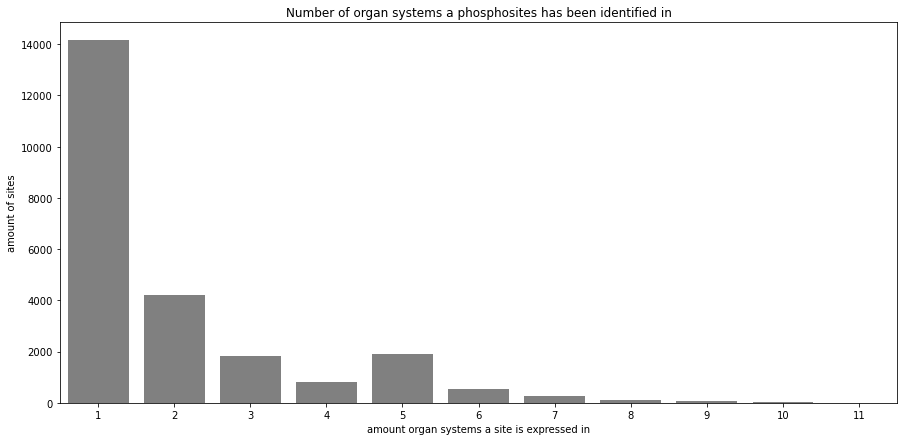

    Total_systems  ACC_ID
0               1   14147
1               2    4196
2               3    1845
3               4     814
4               5    1888
5               6     545
6               7     278
7               8     102
8               9      60
9              10      26
10             11       2
The total amount of sites is: 23903
Index(['Total_systems', 'ACC_ID'], dtype='object')
    Total_systems  ACC_ID
10             11       2


In [54]:
STY_organsystem_site = data_site_STY.groupby(["Total_systems"], as_index=False)["ACC_ID"].count() #counting the numver of sites associated with a certain amount of organ systems
plt.figure(figsize=(15,7))
sns.barplot(x=STY_organsystem_site["Total_systems"],
            y=STY_organsystem_site["ACC_ID"], color="grey").set(xlabel="amount organ systems a site is expressed in",
                                                  ylabel = "amount of sites", title="Number of organ systems a phosphosites has been identified in")
plt.show()
print(STY_organsystem_site)
print("The total amount of sites is: {}".format(STY_organsystem_site["ACC_ID"].sum())) #equals total nr sites
print(STY_organsystem_site.columns)
doubtfull = STY_organsystem_site[STY_organsystem_site["Total_systems"]==11]
print(doubtfull)

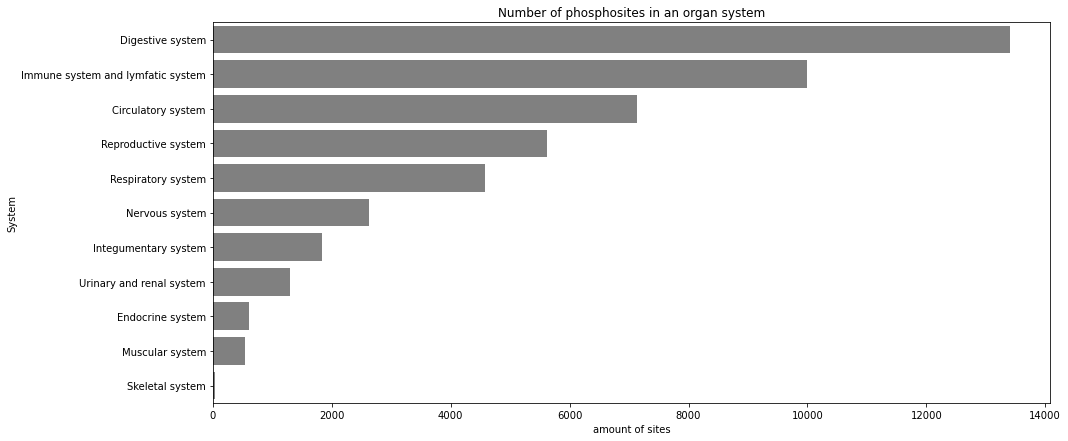

In [55]:
df_sites_systems_STY = pd.DataFrame({"System": list_systems})
list_systemcounts_STY_sites = []
for system in list_systems:
    count = data_site_STY[system].sum()
    list_systemcounts_STY_sites.append(count)
df_sites_systems_STY["amount of sites"] = list_systemcounts_STY_sites
df_sites_systems_STY.sort_values(["amount of sites"], ascending=False, inplace=True)
plt.figure(figsize=(15,7))
sns.barplot(x=df_sites_systems_STY["amount of sites"], y=df_sites_systems_STY["System"], color="grey").set(title = "Number of phosphosites in an organ system")
plt.show() #combine the proteins and sites

In [56]:
df_sites_systems_STY

,System,amount of sites
1,Digestive system,13408
3,Immune system and lymfatic system,9986
0,Circulatory system,7125
7,Reproductive system,5623
8,Respiratory system,4573
6,Nervous system,2620
4,Integumentary system,1827
10,Urinary and renal system,1288
2,Endocrine system,611
5,Muscular system,533


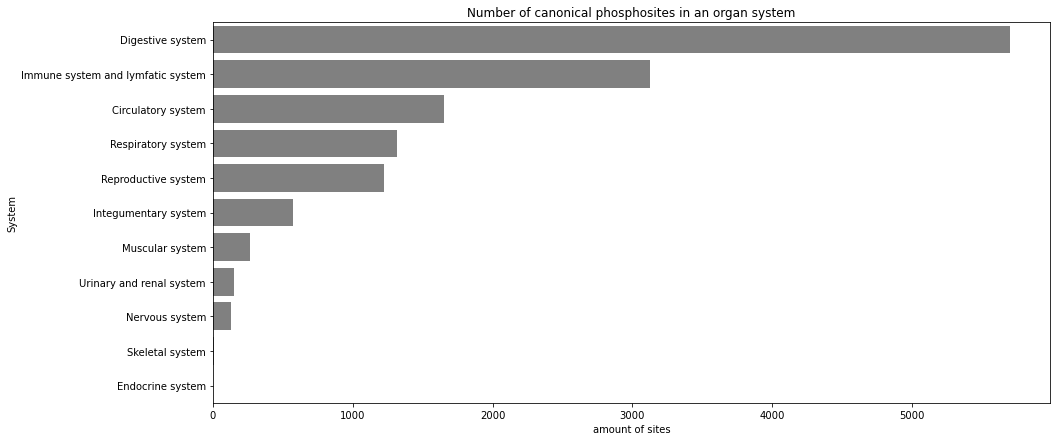

In [57]:
df_sites_onesystem_STY = pd.DataFrame({"System": list_systems})
list_systemcounts_STY_sites = []
for system in list_systems:
    count = data_site_STY.loc[data_site_STY["Total_systems"]==1, system].sum()
    list_systemcounts_STY_sites.append(count)
df_sites_onesystem_STY["amount of sites"] = list_systemcounts_STY_sites
df_sites_onesystem_STY.sort_values(["amount of sites"], ascending=False, inplace=True)
plt.figure(figsize=(15,7))
sns.barplot(x=df_sites_onesystem_STY["amount of sites"], y=df_sites_onesystem_STY["System"], color="grey").set(title = "Number of canonical phosphosites in an organ system")
plt.show()

In [58]:
df_sites_onesystem_STY

,System,amount of sites
1,Digestive system,5701
3,Immune system and lymfatic system,3129
0,Circulatory system,1653
8,Respiratory system,1316
7,Reproductive system,1225
4,Integumentary system,574
5,Muscular system,266
10,Urinary and renal system,152
6,Nervous system,126
9,Skeletal system,5


## contrast of number of proteins and sites per organ system

<AxesSubplot:title={'center':'Contrast of the amount of phosphorylated proteins (green) and phosphosites (grey) in an organ system'}, xlabel='System'>

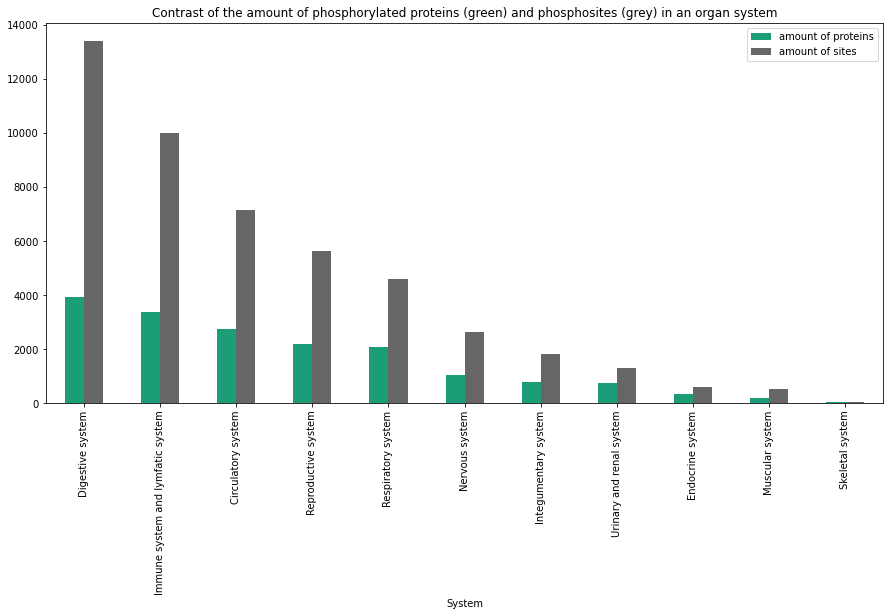

In [59]:
df_proteins_sites_systems_STY = pd.merge(df_proteins_systems_STY, df_sites_systems_STY, how="left", on="System")
df_proteins_sites_systems_STY.plot(x="System", kind="bar", figsize=(15,7), colormap="Dark2", title="Contrast of the amount of phosphorylated proteins (green) and phosphosites (grey) in an organ system")

<AxesSubplot:title={'center':'Contrast of the amount of phosphorylated proteins (green) and phosphosites (grey) in an organ system (canonical sites)'}, xlabel='System'>

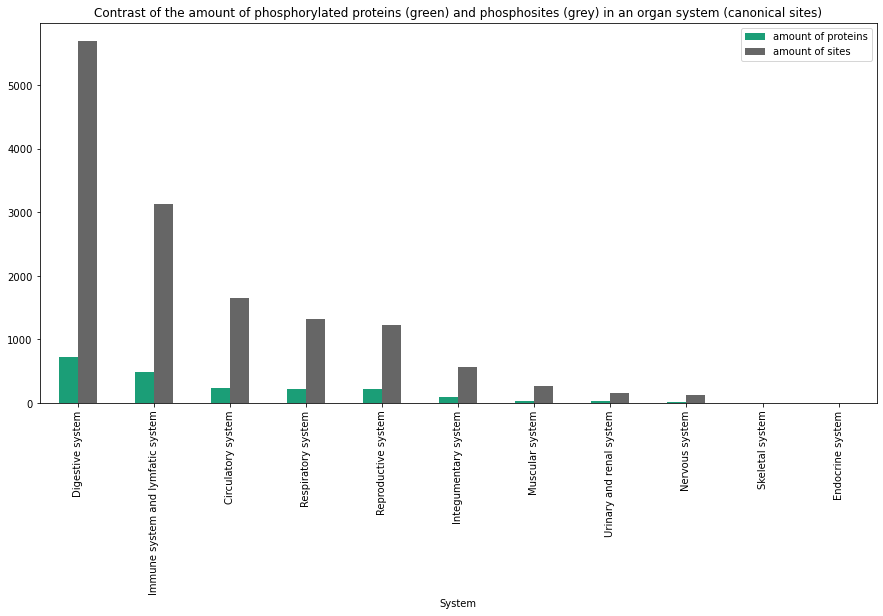

In [60]:
df_proteins_sites_onesystem_STY = pd.merge(df_proteins_onesystem_STY, df_sites_onesystem_STY, how="left", on="System")
df_proteins_sites_onesystem_STY.plot(x="System", kind="bar", figsize=(15,7), colormap="Dark2", title="Contrast of the amount of phosphorylated proteins (green) and phosphosites (grey) in an organ system (canonical sites)")

<AxesSubplot:title={'center':'Contrast of the amount of organ systems a phosphoprotein (green) and phosphosite (grey) have been identified in'}, xlabel='Total_systems'>

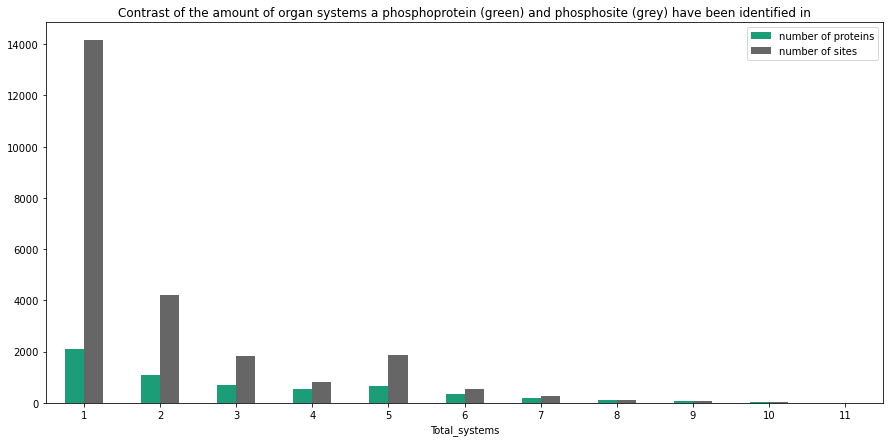

In [61]:
protein_site_organsystem_STY = pd.merge(STY_organsystem_protein, STY_organsystem_site, how="left", on=["Total_systems"], suffixes=["_protein", "_site"])
protein_site_organsystem_STY.rename(columns={"ACC_ID_protein": "number of proteins", "ACC_ID_site": "number of sites"}, inplace=True)
protein_site_organsystem_STY.plot(x="Total_systems", kind="bar", figsize=(15,7), colormap="Dark2", rot=0, title="Contrast of the amount of organ systems a phosphoprotein (green) and phosphosite (grey) have been identified in")

### percentages S,T,Y in organ systems

Percentages S,T,Y are calculated to compare them to values found in literature, both on the organ system level as on the tissue level. On average, the percentage S P-sites is slightly lower than expected, while the percentage Y is considerably higher. Despite this, only 1 project used enrichment strategies for Y P-sites. All organ systems and tissues show more or the less the same trend.

In [62]:
residues_system = pd.DataFrame({"System": list_systems})
for system in list_systems:
    residues_system.loc[residues_system["System"]==system ,"S"] = data_site_STY[data_site_STY[system]==1
                                                                               ]["modres"].value_counts()[0]
    residues_system.loc[residues_system["System"]==system ,"T"] = data_site_STY[data_site_STY[system]==1
                                                                               ]["modres"].value_counts()[1]
    residues_system.loc[residues_system["System"]==system ,"Y"] = data_site_STY[data_site_STY[system]==1
                                                                               ]["modres"].value_counts()[2]
residues_system["Total_sites"] = residues_system[["S", "T", "Y"]].sum(axis=1)
residues_system["Fraction S in %"] = residues_system["S"]*100/residues_system["Total_sites"]
residues_system["Fraction T in %"] = residues_system["T"]*100/residues_system["Total_sites"]
residues_system["Fraction Y in %"] = residues_system["Y"]*100/residues_system["Total_sites"]

In [63]:
residues_system

,System,S,T,Y,Total_sites,Fraction S in %,Fraction T in %,Fraction Y in %
0,Circulatory system,5438.0,1446.0,241.0,7125.0,76.322807,20.294737,3.382456
1,Digestive system,9962.0,2988.0,458.0,13408.0,74.298926,22.285203,3.415871
2,Endocrine system,396.0,138.0,77.0,611.0,64.811784,22.585925,12.602291
3,Immune system and lymfatic system,7245.0,2186.0,555.0,9986.0,72.551572,21.890647,5.557781
4,Integumentary system,954.0,584.0,289.0,1827.0,52.216749,31.964970,15.818281
5,Muscular system,293.0,164.0,76.0,533.0,54.971857,30.769231,14.258912
6,Nervous system,1891.0,630.0,99.0,2620.0,72.175573,24.045802,3.778626
7,Reproductive system,3825.0,1403.0,395.0,5623.0,68.024186,24.951094,7.024720
8,Respiratory system,3120.0,863.0,590.0,4573.0,68.226547,18.871638,12.901815
9,Skeletal system,21.0,6.0,3.0,30.0,70.000000,20.000000,10.000000


<AxesSubplot:title={'center':'Number of phosphorylated serines, threonines and tyrosines contrasted by total phosphosites'}, xlabel='System'>

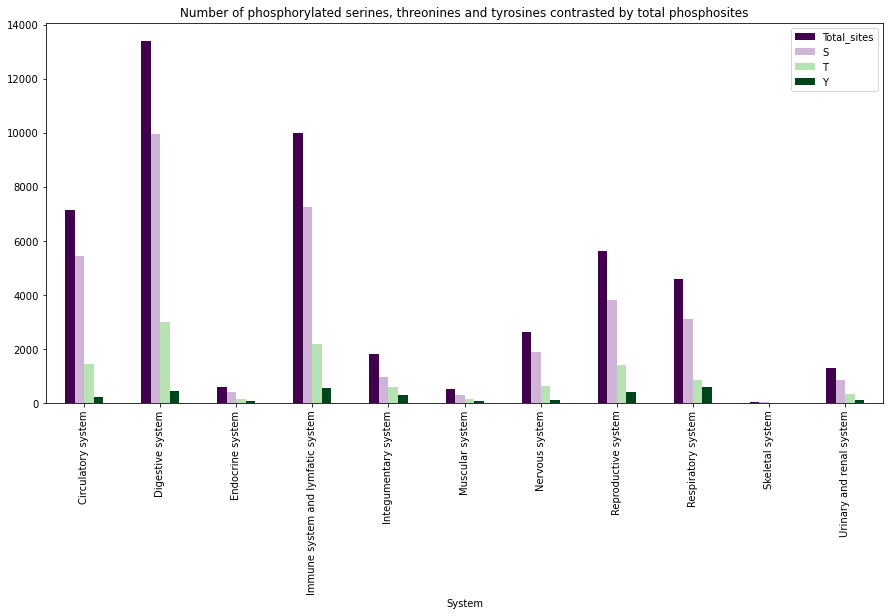

In [64]:
residues_system[["System", "Total_sites", "S", "T", "Y"]].plot(x="System", kind="bar", figsize=(15,7),
                                                                                         colormap="PRGn",
                                                              title="Number of phosphorylated serines, threonines and tyrosines contrasted by total phosphosites")

In [65]:
residues_tissue = pd.DataFrame({"Tissue": list_tissues})
for tissue in list_tissues:
    nr_sites = data_site_STY[data_site_STY[tissue]==1]["modres"].nunique()
    if nr_sites == 3:
        residues_tissue.loc[residues_tissue["Tissue"]==tissue ,"S"] = data_site_STY[data_site_STY[tissue]==1
                                                                                   ]["modres"].value_counts()[0]
        residues_tissue.loc[residues_tissue["Tissue"]==tissue ,"T"] = data_site_STY[data_site_STY[tissue]==1
                                                                               ]["modres"].value_counts()[1]
        residues_tissue.loc[residues_tissue["Tissue"]==tissue ,"Y"] = data_site_STY[data_site_STY[tissue]==1
                                                                               ]["modres"].value_counts()[2]
    else:
#        data_sub = data_site_STY[data_site_STY[tissue]==1]["modres"]
        list_res = data_site_STY[data_site_STY[tissue]==1]["modres"].value_counts().index.to_list()
        list_values = data_site_STY[data_site_STY[tissue]==1]["modres"].value_counts().values
        for i in range(len(list_res)):
            if list_res[i] == "S":
                residues_tissue.loc[residues_tissue["Tissue"]==tissue ,"S"] = list_values[i]
            elif list_res[i] == "T":
                residues_tissue.loc[residues_tissue["Tissue"]==tissue ,"T"] = list_values[i]
            elif list_res[i] == "Y":
                residues_tissue.loc[residues_tissue["Tissue"]==tissue ,"Y"] = list_values[i]
            if "S" not in list_res:
                residues_tissue.loc[residues_tissue["Tissue"]==tissue ,"S"] = 0
            if "T" not in list_res:
                residues_tissue.loc[residues_tissue["Tissue"]==tissue ,"T"] = 0
            if "Y" not in list_res:
                residues_tissue.loc[residues_tissue["Tissue"]==tissue ,"Y"] = 0
residues_tissue["Total_sites"] = residues_tissue[["S", "T", "Y"]].sum(axis=1)
residues_tissue["Fraction S in %"] = residues_tissue["S"]*100/residues_tissue["Total_sites"]
residues_tissue["Fraction T in %"] = residues_tissue["T"]*100/residues_tissue["Total_sites"]
residues_tissue["Fraction Y in %"] = residues_tissue["Y"]*100/residues_tissue["Total_sites"]

In [66]:
residues_tissue

,Tissue,S,T,Y,Total_sites,Fraction S in %,Fraction T in %,Fraction Y in %
0,Adipose tissue,396.0,138.0,77.0,611.0,64.811784,22.585925,12.602291
1,B-cells,243.0,94.0,24.0,361.0,67.313019,26.038781,6.648199
2,Blood,5405.0,1427.0,237.0,7069.0,76.460603,20.186731,3.352667
3,Bone,9.0,3.0,1.0,13.0,69.230769,23.076923,7.692308
4,Brain,1878.0,628.0,98.0,2604.0,72.119816,24.116743,3.763441
5,Breast,74.0,44.0,39.0,157.0,47.133758,28.025478,24.840764
6,Cerebrospinal fluid,1599.0,560.0,83.0,2242.0,71.320250,24.977698,3.702052
7,Cervix,19.0,6.0,3.0,28.0,67.857143,21.428571,10.714286
8,Colon,8324.0,2371.0,297.0,10992.0,75.727802,21.570233,2.701965
9,Dental plaque,36.0,6.0,2.0,44.0,81.818182,13.636364,4.545455


A considerably higher amount of phosphotyrosines have been identified in lung, which is the only tissue in which this was enriched (pTyr Ab project: 1, in lung).

<AxesSubplot:title={'center':'Number of phosphorylated serines, threonines and tyrosines contrasted by total phosphosites'}, xlabel='Tissue'>

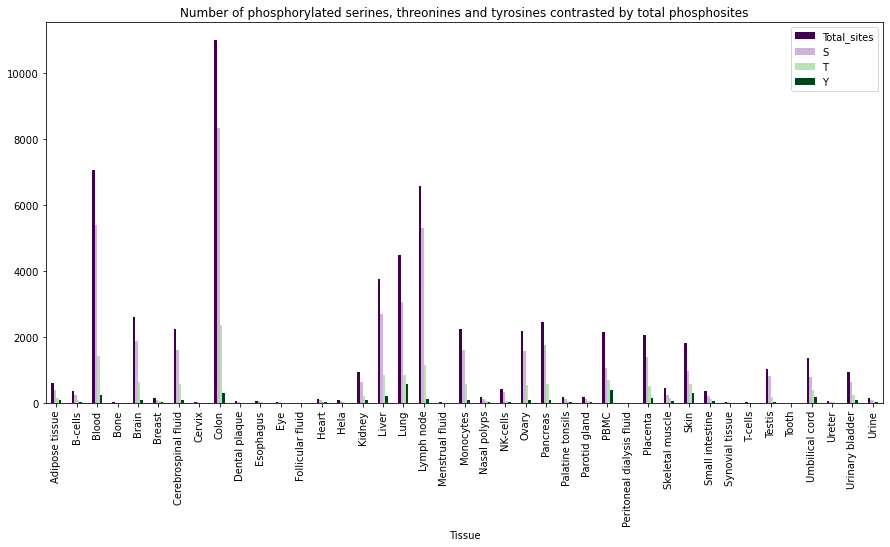

In [67]:
residues_tissue[["Tissue", "Total_sites", "S", "T", "Y"]].plot(x="Tissue", kind="bar", figsize=(15,7), colormap="PRGn",
                                                              title="Number of phosphorylated serines, threonines and tyrosines contrasted by total phosphosites")

### number of projects per organ system

Similar to on the tissue level, we calculate how many projects cover a certain organ system. For this, we use similar methods as above: per organ system we check for each tissue whether a certain P-site has been identified, and, if so, we add the system to the row.

In [68]:
data_STY.head()

,proj,peptide,modres,UP_POS,ACC_ID,pep_start,pep_end,tissue
0,PXD000004,RPPSPEPSTK,S,2102,Q01082,2099,2108,Brain
3,PXD000004,AISPTSATSSGR,S,600,Q9Y4I1,598,609,Brain
4,PXD000004,FYYTAGSSSPTHAK,S,198,O75508,190,203,Brain
5,PXD000004,TSASIGSLCADAR,S,199,P60201,193,205,Brain
9,PXD000004,SLSTSGESLYHVLGLDK,S,10,Q9H3Z4,8,24,Brain


In [69]:
data_protein_system_counts_prep = data_STY[["ACC_ID","proj", "modres", "UP_POS", "tissue"]]
data_protein_system_counts_prep["Systems"] = 0
for tissue in list_circulatory:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Circulatory system,"
for tissue in list_digestive:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Digestive system,"    
for tissue in list_endocrine:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Endocrine system,"    
for tissue in list_immune:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Immune system and lymfatic system,"    
for tissue in list_integumentary:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Integumentary system,"    
for tissue in list_muscular:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Muscular system," 
for tissue in list_nervous:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Nervous system,"    
for tissue in list_reproductive:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Reproductive system,"    
for tissue in list_respiratory:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Respiratory system,"    
for tissue in list_skeletal:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Skeletal system,"
for tissue in list_urinary:
    data_protein_system_counts_prep.loc[data_protein_system_counts_prep["tissue"].str.contains(tissue), "Systems"] = "Urinary system,"
data_protein_system_counts_prep.head()

C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/2572343488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_protein_system_counts_prep["Systems"] = 0
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,ACC_ID,proj,modres,UP_POS,tissue,Systems
0,Q01082,PXD000004,S,2102,Brain,"Nervous system,"
3,Q9Y4I1,PXD000004,S,600,Brain,"Nervous system,"
4,O75508,PXD000004,S,198,Brain,"Nervous system,"
5,P60201,PXD000004,S,199,Brain,"Nervous system,"
9,Q9H3Z4,PXD000004,S,10,Brain,"Nervous system,"


In [70]:
data_protein_system_counts_prep[data_protein_system_counts_prep["Systems"]==0]

,ACC_ID,proj,modres,UP_POS,tissue,Systems


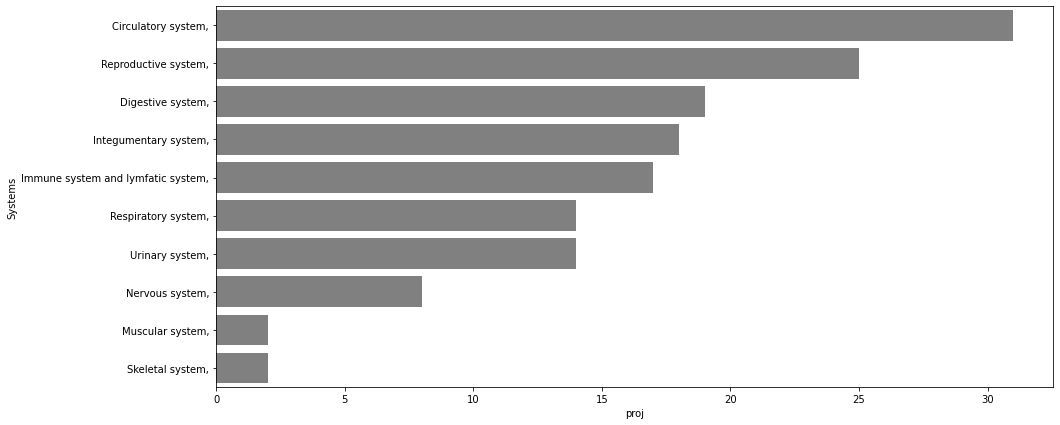

In [71]:
data_protein_system_counts_STY = data_protein_system_counts_prep.groupby(["Systems"], as_index=False)["proj"].nunique()
data_protein_system_counts_STY.sort_values(["proj"], ascending = False, inplace=True)
plt.figure(figsize=(15,7))
sns.barplot(x=data_protein_system_counts_STY["proj"], y=data_protein_system_counts_STY["Systems"], color="grey")
plt.show()

## only non STY-sites

We'll now have a closer look at the non canonical phosphosites. We'll attempt to determine why we're losing so many sites, relative to the amount of proteins lost, when considering the canonical sites only. We'll calculate the same things as described above. Additionally, we'll split proteins and sites in three groups: tissue-specific (1 tissue), non tissue-specific (seen in 2-4 tissues) and general (seen in 5 or more tissues).

In [72]:
data_nonSTY = data[(data["modres"]!="S")&(data["modres"]!="T")&(data["modres"]!="Y")]
data_nonSTY.head()

,proj,peptide,modres,UP_POS,ACC_ID,pep_start,pep_end,tissue
1,PXD000004,ACVVHGSDLK,C,660,P50993,659,668,Brain
2,PXD000004,ACVVHGSDLK,C,663,P05023,662,671,Brain
6,PXD000004,INEVQQAKKK,K,67,Q8N0S2,60,69,Brain
7,PXD000004,NSSYFADWLPNNVK,D,343,Q3ZCM7,337,350,Brain
8,PXD000004,NSSYFADWLPNNVK,D,343,Q3ZCM7,337,350,Brain


More proteins are identified as tissue-specific when considering only non-canonical sites.

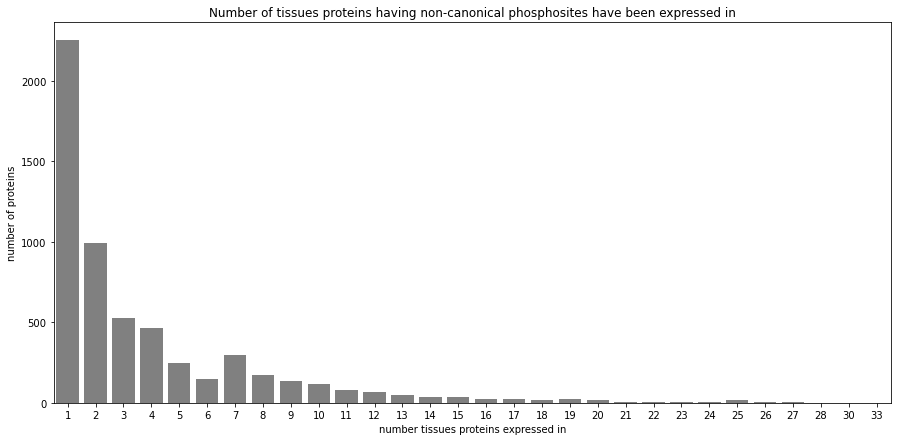

In [73]:
list_tissues = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Bronchoalveolar lavage", "Cartilage", "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Sputum", "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]

data_protein_nonSTY = data_nonSTY.groupby(["ACC_ID"], as_index=False)[["tissue"]].agg({"tissue": lambda x:
                                                              ",".join(x)})
for tissue in list_tissues:
    data_protein_nonSTY[tissue] = data_protein_nonSTY["tissue"].str.contains(tissue)
data_protein_nonSTY.replace({True:1, False:0}, inplace=True)
data_protein_nonSTY["Total"] = data_protein_nonSTY[list_tissues].sum(axis=1)
nr_tissues_expressed_nonSTY = data_protein_nonSTY.groupby(["Total"], as_index=False)["ACC_ID"].nunique()
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_nonSTY["Total"],
            y=nr_tissues_expressed_nonSTY["ACC_ID"], color="grey").set(xlabel="number tissues proteins expressed in",
                                                  ylabel = "number of proteins", title="Number of tissues proteins having non-canonical phosphosites have been expressed in")
plt.show()

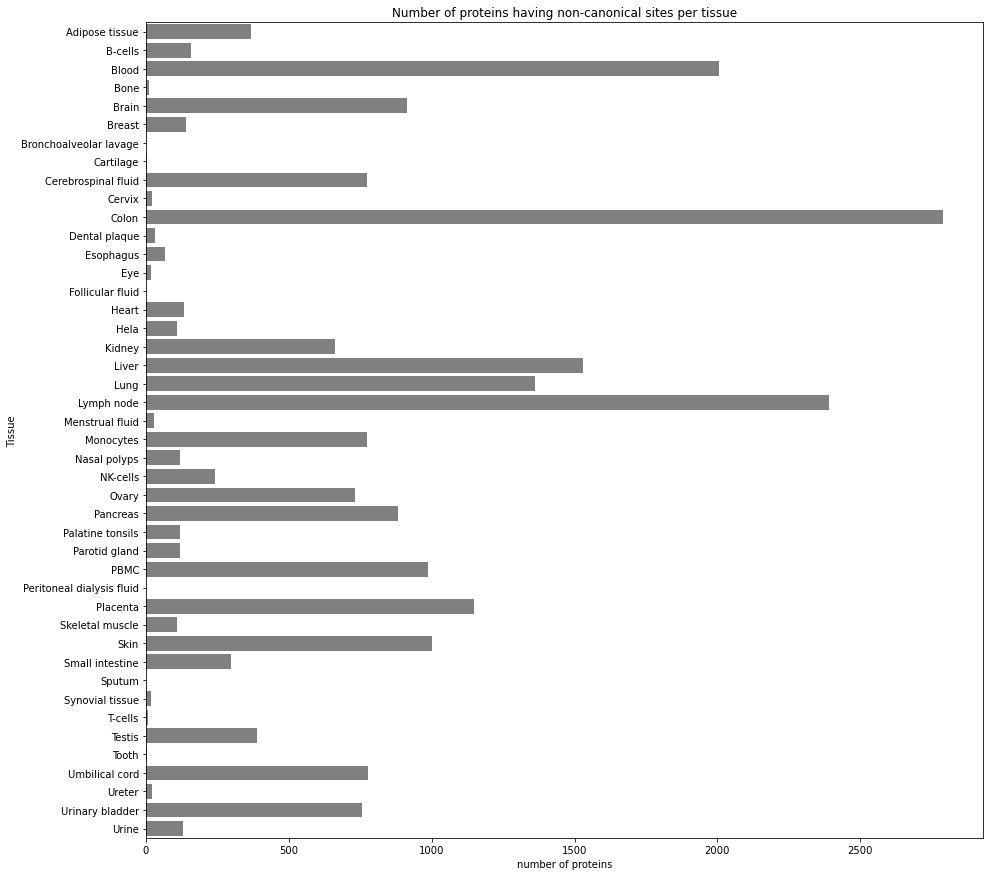

In [74]:
df_proteins_tissue_nonSTY = pd.DataFrame({"Tissue": list_tissues})
list_counts_nonSTY = []
for tissue in list_tissues:
    count = data_protein_nonSTY[tissue].sum()
    list_counts_nonSTY.append(count)
df_proteins_tissue_nonSTY["number of proteins"] = list_counts_nonSTY
plt.figure(figsize=(15,15))
sns.barplot(x=df_proteins_tissue_nonSTY["number of proteins"], y=df_proteins_tissue_nonSTY["Tissue"], color="grey").set(title="Number of proteins having non-canonical sites per tissue")
plt.show()
#while the order changes somewhat, most data is lost in the tissues we have the most data in to begin with

[Text(0.5, 1.0, 'Number of proteins per category, per tissue having non canonical sites')]

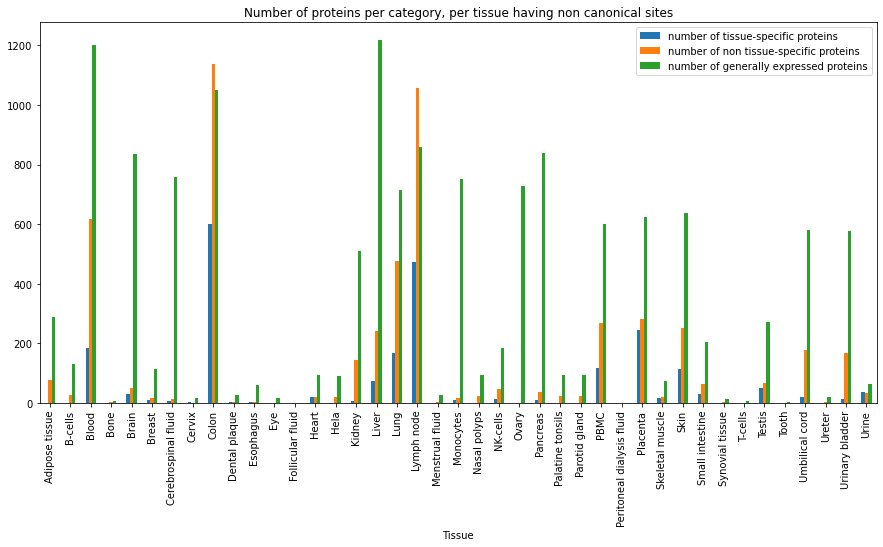

In [75]:
nonSTY_t_spec_prot = data_protein_nonSTY[(data_protein_nonSTY["Total"]==1)]
nonSTY_non_t_spec_prot = data_protein_nonSTY[(data_protein_nonSTY["Total"]>1)&(data_protein_nonSTY["Total"]<5)]
nonSTY_general_prot = data_protein_nonSTY[(data_protein_nonSTY["Total"]>=5)]
list_tissues = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
                "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]
df_general_proteins_tissues_nonSTY = pd.DataFrame({"Tissue": list_tissues})
list_counts_3_nonSTY = []
for tissue in list_tissues:
    count = nonSTY_general_prot[tissue].sum()
    list_counts_3_nonSTY.append(count)
df_general_proteins_tissues_nonSTY["number of generally expressed proteins"] = list_counts_3_nonSTY
df_t_spec_proteins_tissues_nonSTY = pd.DataFrame({"Tissue": list_tissues})
list_counts_4_nonSTY = []
for tissue in list_tissues:
    count = nonSTY_t_spec_prot[tissue].sum()
    list_counts_4_nonSTY.append(count)
df_t_spec_proteins_tissues_nonSTY["number of tissue-specific proteins"] = list_counts_4_nonSTY
df_non_t_spec_proteins_tissues_nonSTY = pd.DataFrame({"Tissue": list_tissues})
list_counts_5_nonSTY = []
for tissue in list_tissues:
    count = nonSTY_non_t_spec_prot[tissue].sum()
    list_counts_5_nonSTY.append(count)
df_non_t_spec_proteins_tissues_nonSTY["number of non tissue-specific proteins"] = list_counts_5_nonSTY
df_combined_all_nonSTY = pd.merge(df_t_spec_proteins_tissues_nonSTY, df_non_t_spec_proteins_tissues_nonSTY, how="outer", on="Tissue")
df_combined_all_nonSTY = pd.merge(df_combined_all_nonSTY, df_general_proteins_tissues_nonSTY, how="outer", on="Tissue")
df_combined_all_nonSTY.plot(x="Tissue", kind="bar", figsize=(15,7)).set(title = "Number of proteins per category, per tissue having non canonical sites")
#generally speaking, the same trends as in the STY data is identified

In [76]:
df_combined_all_nonSTY["Total"] = df_combined_all_nonSTY[["number of tissue-specific proteins", "number of non tissue-specific proteins", "number of generally expressed proteins"]].sum(axis=1)
df_combined_all_nonSTY

,Tissue,number of tissue-specific proteins,number of non tissue-specific proteins,number of generally expressed proteins,Total
0,Adipose tissue,0,77,289,366
1,B-cells,1,26,129,156
2,Blood,185,616,1203,2004
3,Bone,0,3,7,10
4,Brain,29,50,835,914
5,Breast,11,17,112,140
6,Cerebrospinal fluid,5,13,757,775
7,Cervix,3,1,17,21
8,Colon,602,1138,1050,2790
9,Dental plaque,3,4,25,32


Despite more proteins are considered tissue-specific for the non-canonical sites, these sites are less tissue-specific.

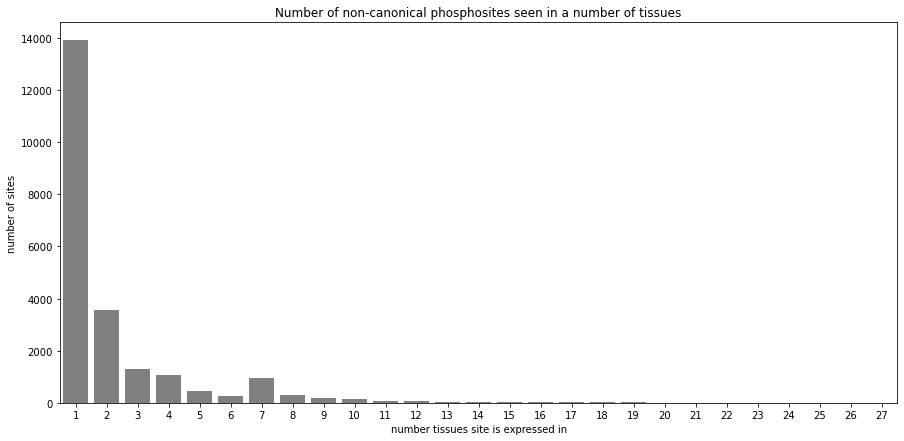

In [77]:
list_tissues = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Bronchoalveolar lavage", "Cartilage", "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Sputum", "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]
data_site_nonSTY = data_nonSTY[["ACC_ID", "UP_POS", "tissue", "modres"]]
data_site_nonSTY = data_site_nonSTY.groupby(["ACC_ID", "UP_POS"], as_index=False)[["tissue", "modres"]].agg({"tissue": lambda x:
                                                              ",".join(x),
                                                                        "modres": "first"}
                                                                       )
for tissue in list_tissues:
    data_site_nonSTY[tissue] = data_site_nonSTY["tissue"].str.contains(tissue)
data_site_nonSTY.replace({True:1, False:0}, inplace=True)
data_site_nonSTY["Total"] = data_site_nonSTY[list_tissues].sum(axis=1)
nr_tissues_expressed_nonSTY_sites = data_site_nonSTY.groupby(["Total"], as_index=False)["UP_POS"].count()
plt.figure(figsize=(15,7))
sns.barplot(x=nr_tissues_expressed_nonSTY_sites["Total"],
            y=nr_tissues_expressed_nonSTY_sites["UP_POS"], color="grey").set(xlabel="number tissues site is expressed in",
                                                  ylabel = "number of sites", title="Number of non-canonical phosphosites seen in a number of tissues")
plt.show()


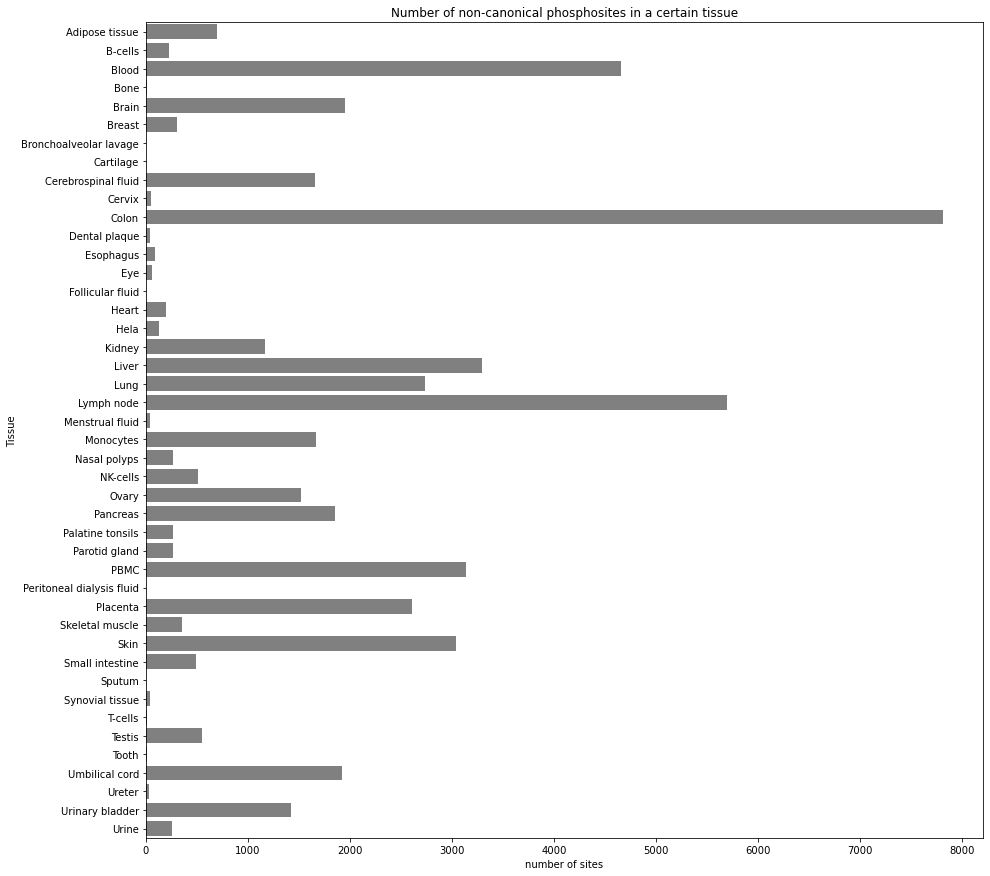

In [78]:
df_sites_tissue_nonSTY = pd.DataFrame({"Tissue": list_tissues})
list_counts_nonSTY = []
for tissue in list_tissues:
    count = data_site_nonSTY[tissue].sum()
    list_counts_nonSTY.append(count)
df_sites_tissue_nonSTY["number of sites"] = list_counts_nonSTY
plt.figure(figsize=(15,15))
sns.barplot(x=df_sites_tissue_nonSTY["number of sites"], y=df_sites_tissue_nonSTY["Tissue"], color="grey").set(title = "Number of non-canonical phosphosites in a certain tissue")
plt.show()
#same trends as in the STY-sites plot

[Text(0.5, 1.0, 'Number of non-canonical sites in each of the three categories per tissue')]

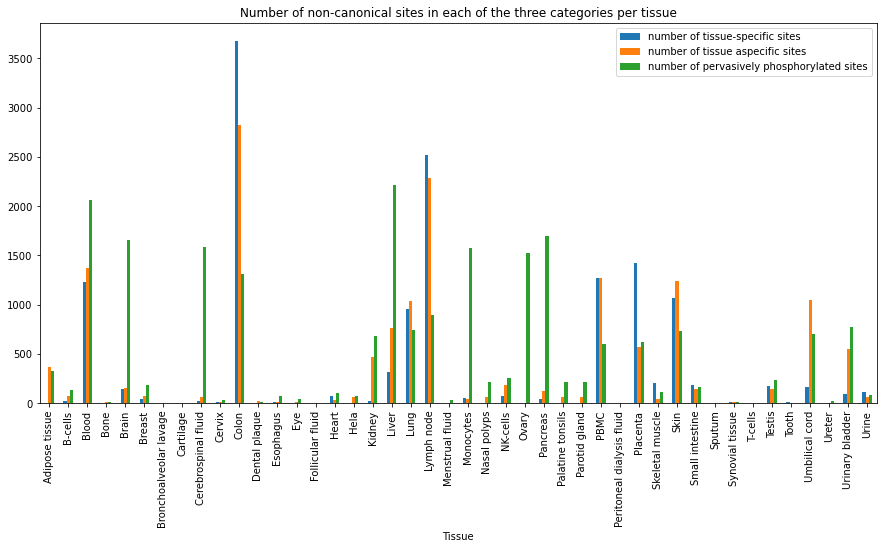

In [79]:
nonSTY_t_spec_sites = data_site_nonSTY[(data_site_nonSTY["Total"]==1)]
nonSTY_non_t_spec_sites = data_site_nonSTY[(data_site_nonSTY["Total"]>1)&(data_site_nonSTY["Total"]<5)]
nonSTY_general_sites = data_site_nonSTY[(data_site_nonSTY["Total"]>=5)]
df_general_site_tissues_nonSTY = pd.DataFrame({"Tissue": list_tissues})
list_counts_3_nonSTY = []
for tissue in list_tissues:
    count = nonSTY_general_sites[tissue].sum()
    list_counts_3_nonSTY.append(count)
df_general_site_tissues_nonSTY["number of pervasively phosphorylated sites"] = list_counts_3_nonSTY
df_t_spec_site_tissues_nonSTY = pd.DataFrame({"Tissue": list_tissues})
list_counts_4_nonSTY = []
for tissue in list_tissues:
    count = nonSTY_t_spec_sites[tissue].sum()
    list_counts_4_nonSTY.append(count)
df_t_spec_site_tissues_nonSTY["number of tissue-specific sites"] = list_counts_4_nonSTY
df_non_t_spec_site_tissues_nonSTY = pd.DataFrame({"Tissue": list_tissues})
list_counts_5_nonSTY = []
for tissue in list_tissues:
    count = nonSTY_non_t_spec_sites[tissue].sum()
    list_counts_5_nonSTY.append(count)
df_non_t_spec_site_tissues_nonSTY["number of tissue aspecific sites"] = list_counts_5_nonSTY
df_combined_all_nonSTY_sites = pd.merge(df_t_spec_site_tissues_nonSTY, df_non_t_spec_site_tissues_nonSTY, how="outer", on="Tissue")
df_combined_all_nonSTY_sites = pd.merge(df_combined_all_nonSTY_sites, df_general_site_tissues_nonSTY, how="outer", on="Tissue")
df_combined_all_nonSTY_sites.plot(x="Tissue", kind="bar", figsize=(15,7)).set(title = "Number of non-canonical sites in each of the three categories per tissue")
#generally, the same trends are identified, although more tissue-specific phosphosites are non-STY

### Presence of canonical sites in peptides with non STY phosphorylation

There are several reasons why a non canonical site might be indicated as phosphorylated. First of, it's possible that non canonical sites are also phosphorylated, but no scientific evidence has been found to support this yet. Absence of evidence is no evidence of absence. Second, it might be that the something went wrong with analysing the MS spectra.
 - the identified residue might not have been phosphorylated, another modification might have occured
 - the peptide was incorrectly identified
 - the modified residue was incorrectly pinpointed (phosphorylation did occur, but on a different residue)
 
We will here be focussing on the latter. We will therefore investigate whether the peptides suspected of non canonical sites phosphorylation contain  canonical sites relatively close, within 5 residues on either side, to the modified position.

In [80]:
data_nonSTY.head()

,proj,peptide,modres,UP_POS,ACC_ID,pep_start,pep_end,tissue
1,PXD000004,ACVVHGSDLK,C,660,P50993,659,668,Brain
2,PXD000004,ACVVHGSDLK,C,663,P05023,662,671,Brain
6,PXD000004,INEVQQAKKK,K,67,Q8N0S2,60,69,Brain
7,PXD000004,NSSYFADWLPNNVK,D,343,Q3ZCM7,337,350,Brain
8,PXD000004,NSSYFADWLPNNVK,D,343,Q3ZCM7,337,350,Brain


In [81]:
data_nonSTY_gr = data_nonSTY.groupby(["ACC_ID", "UP_POS", "modres", "peptide"], as_index=False)[["tissue", "pep_start", "pep_end"]].agg({"tissue": lambda x:
                                                              ",".join(x), "pep_start":"first", "pep_end":"first"})


data_nonSTY_gr["S"] = data_nonSTY_gr["peptide"].str.count("S")
data_nonSTY_gr["T"] = data_nonSTY_gr["peptide"].str.count("T")
data_nonSTY_gr["Y"] = data_nonSTY_gr["peptide"].str.count("Y")

data_nonSTY_gr_STYcont = data_nonSTY_gr[(data_nonSTY_gr["S"]>0)|(data_nonSTY_gr["T"]>0)|(data_nonSTY_gr["Y"]>0)]
data_nonSTY_gr_non = data_nonSTY_gr[((data_nonSTY_gr["S"]==0)&(data_nonSTY_gr["T"]==0)&(data_nonSTY_gr["Y"]==0))]


In total, there are 5 779 non-STY phoshphorylated proteins, having 22 536 non-canonical phosphosites.

Out of the 5 779 proteins, 586 proteins had no canonical sites in the peptide on which the phoshporylation was identified, while 5530 did have at least one canonical site. Out of the 586 proteins wihthout canonical site, the phosphosite was within 5 residues of either end of the peptide for 448 proteins. For the 5 530 proteins having at least one canonical site, the phosphosite was within 5 residues from either end of the peptide for 3 923 proteins.

Out of 22 536 non-canonical sites, 818 were identified on peptides not containing any canonical site. 531 were within 5 residues of either end of the peptide on which they were identified. 21 731 phosphosites were identified on peptides having at least one canonical site. 9 318 of these were within 5 residues of either end of the peptide.

In [82]:
print("Number of proteins phosphorylated on non-canonical site: {}".format(data_nonSTY_gr["ACC_ID"].nunique()))
print("Number of non-canonical phosphosites: {}".format(data_nonSTY_gr[["ACC_ID", "UP_POS", "modres"]].value_counts().shape[0]))
print("Number of proteins phosphorylated on non-canonical site having at least one canonical site in peptide: {}".format(data_nonSTY_gr_STYcont["ACC_ID"].nunique()))
print("Number of non-canonical phosphosites having at least one canonical site in peptide: {}".format(data_nonSTY_gr_STYcont[["ACC_ID", "UP_POS", "modres"]].value_counts().shape[0]))
print("Number of proteins phosphorylated on non-canonical site having no canonical sites in peptide: {}".format(data_nonSTY_gr_non["ACC_ID"].nunique()))
print("Number of non-canonical phosphosites having no canonical sites in peptide: {}".format(data_nonSTY_gr_non[["ACC_ID", "UP_POS", "modres"]].value_counts().shape[0]))

Number of proteins phosphorylated on non-canonical site: 5779
Number of non-canonical phosphosites: 22536
Number of proteins phosphorylated on non-canonical site having at least one canonical site in peptide: 5530
Number of non-canonical phosphosites having at least one canonical site in peptide: 21731
Number of proteins phosphorylated on non-canonical site having no canonical sites in peptide: 586
Number of non-canonical phosphosites having no canonical sites in peptide: 818


In [83]:
print(data_nonSTY_gr_non[(data_nonSTY_gr_non["UP_POS"]-data_nonSTY_gr_non["pep_start"]<5)|(data_nonSTY_gr_non["pep_end"]-data_nonSTY_gr_non["UP_POS"]<5)]["ACC_ID"].nunique())
print(data_nonSTY_gr_non[(data_nonSTY_gr_non["UP_POS"]-data_nonSTY_gr_non["pep_start"]<5)|(data_nonSTY_gr_non["pep_end"]-data_nonSTY_gr_non["UP_POS"]<5)][["ACC_ID", "UP_POS", "modres"]].value_counts().shape[0])
data_nonSTY_gr_non[(data_nonSTY_gr_non["UP_POS"]-data_nonSTY_gr_non["pep_start"]<5)|(data_nonSTY_gr_non["pep_end"]-data_nonSTY_gr_non["UP_POS"]<5)]

448
531


,ACC_ID,UP_POS,modres,peptide,tissue,pep_start,pep_end,S,T,Y
3,A0A087WVF3,34,K,AGLPEDKGPK,"Colon,Colon,Lymph node,Lymph node,Lymph node,L...",28,37,0,0,0
4,A0A087WXS9,34,K,AGLPEDKGPK,"Colon,Colon,Lymph node,Lymph node,Lymph node,L...",28,37,0,0,0
5,A0A087X179,34,K,AGLPEDKGPK,"Colon,Colon,Lymph node,Lymph node,Lymph node,L...",28,37,0,0,0
6,A0A087X1G2,34,K,AGLPEDKGPK,"Colon,Colon,Lymph node,Lymph node,Lymph node,L...",28,37,0,0,0
7,A0A096LP55,37,C,EQCEQLEK,Liver,35,42,0,0,0
...,...,...,...,...,...,...,...,...,...,...
25961,Q9Y6H1,123,E,QFLECAQNQGDIK,"Liver,Liver,Liver,Liver",120,132,0,0,0
25962,Q9Y6H1,134,C,LCEGFNEVLK,"Liver,Liver",133,142,0,0,0
26001,Q9Y6Q1,48,K,LLPGKVVWK,Urine,44,52,0,0,0
26020,Q9Y6R7,1850,D,APGWDPLCWDECR,"Colon,Colon,Colon",1846,1858,0,0,0


When no S,T,Y sites were identified, this might be because the modified residue is close to the edge of the peptide, in which case surrounding residues were lost. Out of the 585 proteins with modifications identified on peptides without S-,T-,Y-sites, the modification on 448 proteins was found within five residues of either edge of the peptide. This is the case for 521 sites (out of 813).
For the 5 530 proteins for which the modified peptide did have at least one S-,T- or Y-site, the modified residue was found within 5 residues of the edge of the peptide for 3 883 proteins (8 978 phosphosites out of the 21 723)

In [84]:
print(data_nonSTY_gr_STYcont[(data_nonSTY_gr_STYcont["UP_POS"]-data_nonSTY_gr_STYcont["pep_start"]<5)|(data_nonSTY_gr_STYcont["pep_end"]-data_nonSTY_gr_STYcont["UP_POS"]<5)]["ACC_ID"].nunique())
print(data_nonSTY_gr_STYcont[(data_nonSTY_gr_STYcont["UP_POS"]-data_nonSTY_gr_STYcont["pep_start"]<5)|(data_nonSTY_gr_STYcont["pep_end"]-data_nonSTY_gr_STYcont["UP_POS"]<5)][["ACC_ID", "UP_POS", "modres"]].value_counts().shape[0])

3923
9318


We'll now identify the residues within 5 residues of the modified residue.

In [85]:
data_nonSTY_gr_STYcont.drop(["S", "T", "Y"], axis=1, inplace=True)
data_nonSTY_gr_STYcont["relative_POS"] = data_nonSTY_gr_STYcont["UP_POS"] - data_nonSTY_gr_STYcont["pep_start"]
data_nonSTY_gr_STYcont["relative from end"] =  data_nonSTY_gr_STYcont["UP_POS"] - data_nonSTY_gr_STYcont["pep_end"]

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/2819161830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nonSTY_gr_STYcont["relative_POS"] = data_nonSTY_gr_STYcont["UP_POS"] - data_nonSTY_gr_STYcont["pep_start"]
C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/2819161830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [86]:
print(data_nonSTY_gr_STYcont["relative_POS"].max())

29


In [87]:
print(data_nonSTY_gr_STYcont["relative from end"].min())

-28


In [88]:
data_nonSTY_gr_STYcont["res_min5"] = 0
data_nonSTY_gr_STYcont["res_min4"] = 0
data_nonSTY_gr_STYcont["res_min3"] = 0
data_nonSTY_gr_STYcont["res_min2"] = 0
data_nonSTY_gr_STYcont["res_min1"] = 0

for i in range(30):
    if i > 0:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative_POS"]==i, "res_min1"] = data_nonSTY_gr_STYcont["peptide"].str[i-1]
    else:
        data_nonSTY_gr_STYcont["res_min1"] = np.NaN
    if i > 1:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative_POS"]==i, "res_min2"] = data_nonSTY_gr_STYcont["peptide"].str[i-2]
    else:
        data_nonSTY_gr_STYcont["res_min2"] = np.NaN
    if i > 2:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative_POS"]==i, "res_min3"] = data_nonSTY_gr_STYcont["peptide"].str[i-3]
    else:
        data_nonSTY_gr_STYcont["res_min3"] = np.NaN
    if i > 3:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative_POS"]==i, "res_min4"] = data_nonSTY_gr_STYcont["peptide"].str[i-4]
    else:
        data_nonSTY_gr_STYcont["res_min4"] = np.NaN
    if i > 4:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative_POS"]==i, "res_min5"] = data_nonSTY_gr_STYcont["peptide"].str[i-5]
    else:
        data_nonSTY_gr_STYcont["res_min5"] = np.NaN

C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/1147057834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nonSTY_gr_STYcont["res_min5"] = 0
C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/1147057834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nonSTY_gr_STYcont["res_min4"] = 0
C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/1147057834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [89]:
data_nonSTY_gr_STYcont["res_plus1"] = 0
data_nonSTY_gr_STYcont["res_plus2"] = 0
data_nonSTY_gr_STYcont["res_plus3"] = 0
data_nonSTY_gr_STYcont["res_plus4"] = 0
data_nonSTY_gr_STYcont["res_plus5"] = 0
for i in range(30):
    if i > 0:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative from end"]==-1*i, "res_plus1"] = data_nonSTY_gr_STYcont["peptide"].str[-1*i]
    else:
        data_nonSTY_gr_STYcont["res_plus1"] = np.NaN
    if i > 1:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative from end"]==-1*i, "res_plus2"] = data_nonSTY_gr_STYcont["peptide"].str[-1*i+1]
    else:
        data_nonSTY_gr_STYcont["res_plus2"] = np.NaN
    if i > 2:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative from end"]==-1*i, "res_plus3"] = data_nonSTY_gr_STYcont["peptide"].str[-1*i+2]
    else:
        data_nonSTY_gr_STYcont["res_plus3"] = np.NaN
    if i > 3:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative from end"]==-1*i, "res_plus4"] = data_nonSTY_gr_STYcont["peptide"].str[-1*i+3]
    else:
        data_nonSTY_gr_STYcont["res_plus4"] = np.NaN
    if i > 4:
        data_nonSTY_gr_STYcont.loc[data_nonSTY_gr_STYcont["relative from end"]==-1*i, "res_plus5"] = data_nonSTY_gr_STYcont["peptide"].str[-1*i+4]
    else:
        data_nonSTY_gr_STYcont["res_plus5"] = np.NaN

C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/448375572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nonSTY_gr_STYcont["res_plus1"] = 0
C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/448375572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nonSTY_gr_STYcont["res_plus2"] = 0
C:\Users\hannedvo\AppData\Local\Temp\18/ipykernel_17996/448375572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

We now count the instances of S, T and Y on each position. The resulting dataframe is shown below, as is a stacked barchart of this dataframe.

In [90]:
list_S = []
list_T = []
list_Y = []
list_NaN = []
for col in ["res_min5", "res_min4", "res_min3", "res_min2", "res_min1", "res_plus1", "res_plus2", "res_plus3", "res_plus4", "res_plus5"]:
    count_S = data_nonSTY_gr_STYcont[data_nonSTY_gr_STYcont[col]=="S"].shape[0]
    list_S.append(count_S)
    count_T = data_nonSTY_gr_STYcont[data_nonSTY_gr_STYcont[col]=="T"].shape[0]
    list_T.append(count_T)
    count_Y = data_nonSTY_gr_STYcont[data_nonSTY_gr_STYcont[col]=="Y"].shape[0]
    list_Y.append(count_Y)
    countNaN = data_nonSTY_gr_STYcont[col].isna().sum()
    list_NaN.append(countNaN)
df_pos = pd.DataFrame({"Position": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]})
df_pos["S"] = list_S
df_pos["T"] = list_T
df_pos["Y"] = list_Y
df_pos["NaN"] = list_NaN
df_pos

,Position,S,T,Y,NaN
0,-5,2171,1031,420,7819
1,-4,2632,1197,488,4805
2,-3,3523,1346,500,1984
3,-2,3799,1254,468,1138
4,-1,3627,1170,467,629
5,1,3624,1445,487,490
6,2,3154,1304,466,704
7,3,2828,1508,509,1124
8,4,2572,1340,496,1721
9,5,2361,1403,493,2688


[Text(0.5, 1.0, 'Number of peptides having a canonical residue at position from non-canonical phosphosite')]

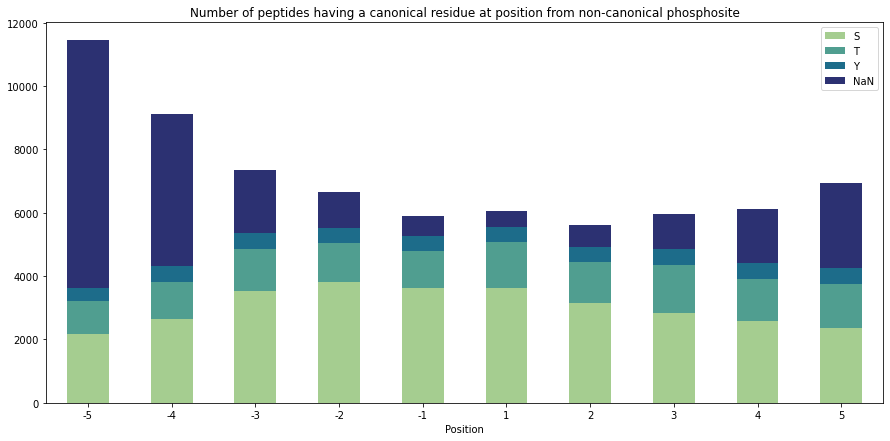

In [91]:
df_pos.plot(x="Position", kind="bar", stacked=True, rot=0, figsize=(15,7), colormap= "crest").set(title = "Number of peptides having a canonical residue at position from non-canonical phosphosite")

We'll now do the same for the canonical sites, to contrast the previous findings.

In [92]:

data_STY_gr = data_STY.groupby(["ACC_ID", "UP_POS", "modres", "peptide"], as_index=False)[["tissue", "pep_start", "pep_end"]].agg({"tissue": lambda x:
                                                              ",".join(x), "pep_start":"first", "pep_end":"first"})
data_STY_gr["relative_POS"] = data_STY_gr["UP_POS"] - data_STY_gr["pep_start"]
data_STY_gr["relative from end"] = data_STY_gr["UP_POS"] - data_STY_gr["pep_end"]
print(data_STY_gr["relative_POS"].max())
print(data_STY_gr["relative from end"].min())

28
-29


In [93]:
data_STY_gr["res_min5"] = 0
data_STY_gr["res_min4"] = 0
data_STY_gr["res_min3"] = 0
data_STY_gr["res_min2"] = 0
data_STY_gr["res_min1"] = 0

for i in range(30):
    if i > 0:
        data_STY_gr.loc[data_STY_gr["relative_POS"]==i, "res_min1"] = data_STY_gr["peptide"].str[i-1]
    else:
        data_STY_gr["res_min1"] = np.NaN
    if i > 1:
        data_STY_gr.loc[data_STY_gr["relative_POS"]==i, "res_min2"] = data_STY_gr["peptide"].str[i-2]
    else:
        data_STY_gr["res_min2"] = np.NaN
    if i > 2:
        data_STY_gr.loc[data_STY_gr["relative_POS"]==i, "res_min3"] = data_STY_gr["peptide"].str[i-3]
    else:
        data_STY_gr["res_min3"] = np.NaN
    if i > 3:
        data_STY_gr.loc[data_STY_gr["relative_POS"]==i, "res_min4"] = data_STY_gr["peptide"].str[i-4]
    else:
        data_STY_gr["res_min4"] = np.NaN
    if i > 4:
        data_STY_gr.loc[data_STY_gr["relative_POS"]==i, "res_min5"] = data_STY_gr["peptide"].str[i-5]
    else:
        data_STY_gr["res_min5"] = np.NaN

data_STY_gr["res_plus1"] = 0
data_STY_gr["res_plus2"] = 0
data_STY_gr["res_plus3"] = 0
data_STY_gr["res_plus4"] = 0
data_STY_gr["res_plus5"] = 0
for i in range(30):
    if i > 0:
        data_STY_gr.loc[data_STY_gr["relative from end"]==-1*i, "res_plus1"] = data_STY_gr["peptide"].str[-1*i]
    else:
        data_STY_gr["res_plus1"] = np.NaN
    if i > 1:
        data_STY_gr.loc[data_STY_gr["relative from end"]==-1*i, "res_plus2"] = data_STY_gr["peptide"].str[-1*i+1]
    else:
        data_STY_gr["res_plus2"] = np.NaN
    if i > 2:
        data_STY_gr.loc[data_STY_gr["relative from end"]==-1*i, "res_plus3"] = data_STY_gr["peptide"].str[-1*i+2]
    else:
        data_STY_gr["res_plus3"] = np.NaN
    if i > 3:
        data_STY_gr.loc[data_STY_gr["relative from end"]==-1*i, "res_plus4"] = data_STY_gr["peptide"].str[-1*i+3]
    else:
        data_STY_gr["res_plus4"] = np.NaN
    if i > 4:
        data_STY_gr.loc[data_STY_gr["relative from end"]==-1*i, "res_plus5"] = data_STY_gr["peptide"].str[-1*i+4]
    else:
        data_STY_gr["res_plus5"] = np.NaN

In [94]:
list_S = []
list_T = []
list_Y = []
list_NaN = []
for col in ["res_min5", "res_min4", "res_min3", "res_min2", "res_min1", "res_plus1", "res_plus2", "res_plus3", "res_plus4", "res_plus5"]:
    count_S = data_STY_gr[data_STY_gr[col]=="S"].shape[0]
    list_S.append(count_S)
    count_T = data_STY_gr[data_STY_gr[col]=="T"].shape[0]
    list_T.append(count_T)
    count_Y = data_STY_gr[data_STY_gr[col]=="Y"].shape[0]
    list_Y.append(count_Y)
    countNaN = data_STY_gr[col].isna().sum()
    list_NaN.append(countNaN)
df_pos_STY = pd.DataFrame({"Position": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]})
df_pos_STY["S"] = list_S
df_pos_STY["T"] = list_T
df_pos_STY["Y"] = list_Y
df_pos_STY["NaN"] = list_NaN
df_pos_STY

,Position,S,T,Y,NaN
0,-5,2107,1058,383,11472
1,-4,2856,1285,418,8232
2,-3,3227,1402,467,4707
3,-2,4381,1763,477,2300
4,-1,3631,1525,510,1304
5,1,3572,1287,459,22
6,2,4157,1893,413,338
7,3,3501,1452,490,1485
8,4,3134,1514,470,2978
9,5,2703,1438,405,4740


[Text(0.5, 1.0, 'Number of peptides having a canonical residue at position from canonical phosphosite')]

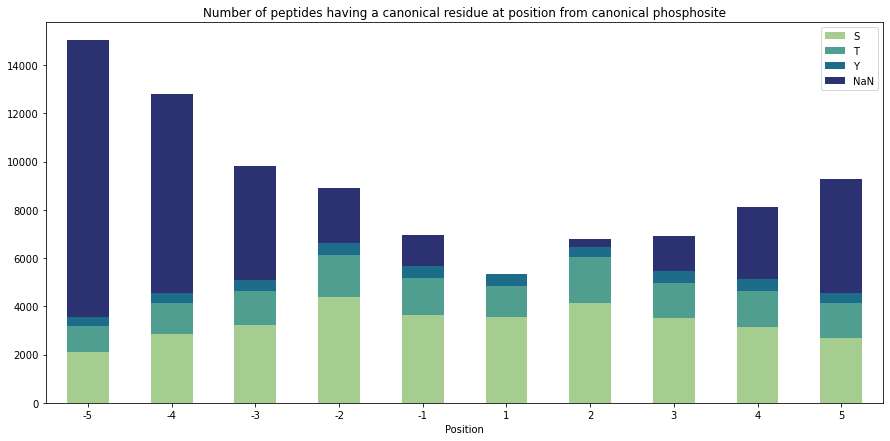

In [95]:
df_pos_STY.plot(x="Position", kind="bar", stacked=True, rot=0, figsize=(15,7),colormap= "crest").set(title = "Number of peptides having a canonical residue at position from canonical phosphosite")

<AxesSubplot:title={'center':'Percentage peptides having a nearby canonical residue for peptides having a modification on a (non-)canonical site'}, xlabel='Relative position form the modified residue', ylabel='Percentage peptides having a nearby S, T and Y site'>

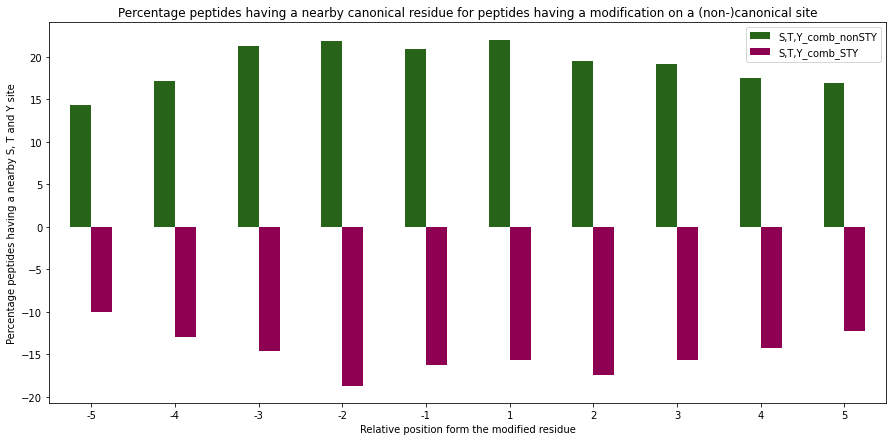

In [96]:
#The same site identified on two different peptides will be accounted for twice
df_pos_STY2 = df_pos_STY.copy()
df_pos_STY2["S"] = -1*df_pos_STY["S"]
df_pos_STY2["T"] = -1*df_pos_STY["Y"]
df_pos_STY2["Y"] = -1*df_pos_STY["Y"]
df_pos_STY2["NaN"] = -1*df_pos_STY["NaN"]

df_pos_comb = pd.merge(df_pos, df_pos_STY2, how="inner", on = "Position", suffixes=["_nonSTY", "_STY"])
df_pos_comb["S_nonSTY_ratio"] = df_pos_comb["S_nonSTY"]*100/data_nonSTY_gr_STYcont.shape[0]
df_pos_comb["T_nonSTY_ratio"] = df_pos_comb["T_nonSTY"]*100/data_nonSTY_gr_STYcont.shape[0]
df_pos_comb["Y_nonSTY_ratio"] = df_pos_comb["Y_nonSTY"]*100/data_nonSTY_gr_STYcont.shape[0]
df_pos_comb["NaN_nonSTY_ratio"] = df_pos_comb["NaN_nonSTY"]*100/data_nonSTY_gr_STYcont.shape[0]

df_pos_comb["S_STY_ratio"] = df_pos_comb["S_STY"]*100/data_STY_gr.shape[0]
df_pos_comb["T_STY_ratio"] = df_pos_comb["T_STY"]*100/data_STY_gr.shape[0]
df_pos_comb["Y_STY_ratio"] = df_pos_comb["Y_STY"]*100/data_STY_gr.shape[0]
df_pos_comb["NaN_STY_ratio"] = df_pos_comb["NaN_STY"]*100/data_STY_gr.shape[0]
df_pos_comb["S,T,Y_comb_nonSTY"] = df_pos_comb["S_nonSTY_ratio"] + df_pos_comb["T_nonSTY_ratio"] + df_pos_comb["Y_nonSTY_ratio"]
df_pos_comb["S,T,Y_comb_STY"] = df_pos_comb["S_STY_ratio"] + df_pos_comb["T_STY_ratio"] + df_pos_comb["Y_STY_ratio"]

df_pos_comb[["Position","S,T,Y_comb_nonSTY", "S,T,Y_comb_STY"]].plot(x="Position", kind="bar", figsize=(15,7), colormap= "PiYG_r", rot=0, xlabel="Relative position form the modified residue", ylabel="Percentage peptides having a nearby S, T and Y site", title="Percentage peptides having a nearby canonical residue for peptides having a modification on a (non-)canonical site")

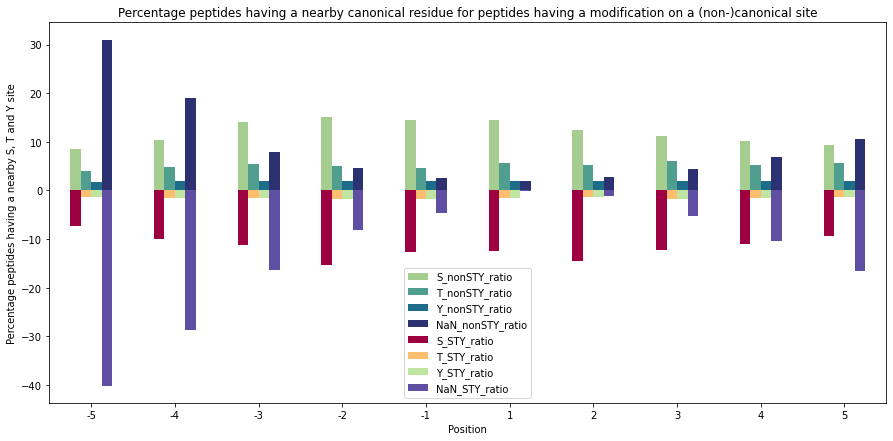

In [97]:
ax = df_pos_comb[["Position","S_nonSTY_ratio", "T_nonSTY_ratio", "Y_nonSTY_ratio", "NaN_nonSTY_ratio"]].plot(x="Position", kind="bar", figsize=(15,7), colormap= "crest", rot=0, xlabel="Relative position form the modified residue", ylabel="Percentage peptides having a nearby S, T and Y site", title="Percentage peptides having a nearby canonical residue for peptides having a modification on a (non-)canonical site")
df_pos_comb[["Position", "S_STY_ratio", "T_STY_ratio", "Y_STY_ratio", "NaN_STY_ratio"]].plot(x="Position", kind="bar", ax=ax, colormap="Spectral", rot=0)
plt.show()
#Especially the percentage T,Y seems to be higher for the non-canonical sites

The plot above shows a relatively higher degree of S,T and Y residues within 5 residues of a non-canonical site modification.

In [98]:
df_pos_comb

,Position,S_nonSTY,T_nonSTY,Y_nonSTY,NaN_nonSTY,S_STY,T_STY,Y_STY,NaN_STY,S_nonSTY_ratio,T_nonSTY_ratio,Y_nonSTY_ratio,NaN_nonSTY_ratio,S_STY_ratio,T_STY_ratio,Y_STY_ratio,NaN_STY_ratio,"S,T,Y_comb_nonSTY","S,T,Y_comb_STY"
0,-5,2171,1031,420,7819,-2107,-383,-383,-11472,8.615079,4.091270,1.666667,31.027778,-7.372030,-1.340051,-1.340051,-40.138554,14.373016,-10.052133
1,-4,2632,1197,488,4805,-2856,-418,-418,-8232,10.444444,4.750000,1.936508,19.067460,-9.992652,-1.462510,-1.462510,-28.802351,17.130952,-12.917673
2,-3,3523,1346,500,1984,-3227,-467,-467,-4707,13.980159,5.341270,1.984127,7.873016,-11.290718,-1.633953,-1.633953,-16.468983,21.305556,-14.558623
3,-2,3799,1254,468,1138,-4381,-477,-477,-2300,15.075397,4.976190,1.857143,4.515873,-15.328365,-1.668941,-1.668941,-8.047304,21.908730,-18.666247
4,-1,3627,1170,467,629,-3631,-510,-510,-1304,14.392857,4.642857,1.853175,2.496032,-12.704244,-1.784402,-1.784402,-4.562472,20.888889,-16.273049
5,1,3624,1445,487,490,-3572,-459,-459,-22,14.380952,5.734127,1.932540,1.944444,-12.497813,-1.605962,-1.605962,-0.076974,22.047619,-15.709737
6,2,3154,1304,466,704,-4157,-413,-413,-338,12.515873,5.174603,1.849206,2.793651,-14.544628,-1.445016,-1.445016,-1.182604,19.539683,-17.434659
7,3,2828,1508,509,1124,-3501,-490,-490,-1485,11.222222,5.984127,2.019841,4.460317,-12.249396,-1.714426,-1.714426,-5.195759,19.226190,-15.678248
8,4,2572,1340,496,1721,-3134,-470,-470,-2978,10.206349,5.317460,1.968254,6.829365,-10.965327,-1.644449,-1.644449,-10.419509,17.492063,-14.254225
9,5,2361,1403,493,2688,-2703,-405,-405,-4740,9.369048,5.567460,1.956349,10.666667,-9.457332,-1.417025,-1.417025,-16.584444,16.892857,-12.291382


We'll now conduct a similar analysis for the entire peptide. For this, all sites will be rescaled in accordance with peptide length, similar to previous work (https://www.biorxiv.org/content/10.1101/2022.03.08.483252v1), were rescaling of P-sites was done based on the protein length.

In [99]:
data = pd.read_csv("phospho_data_tissue_annotation_enrichment1.txt", sep="\t")
data.dropna(inplace=True)
data.head()

,proj,peptide,modres,UP_POS,ACC_ID,pep_start,pep_end,tissue,enrichment,modification,method,additional
0,PXD000004,RPPSPEPSTK,S,2102,Q01082,2099,2108,Brain,None,None,None,None
1,PXD000004,ACVVHGSDLK,C,660,P50993,659,668,Brain,None,None,None,None
2,PXD000004,ACVVHGSDLK,C,663,P05023,662,671,Brain,None,None,None,None
3,PXD000004,AISPTSATSSGR,S,600,Q9Y4I1,598,609,Brain,None,None,None,None
4,PXD000004,FYYTAGSSSPTHAK,S,198,O75508,190,203,Brain,None,None,None,None


In [100]:
print(data.shape[0])

585310


In [101]:
data_nonP = data[(data["modres"]!="S")&(data["modres"]!="T")&(data["modres"]!="Y")]
data_nonP = data_nonP.groupby(["ACC_ID", "UP_POS", "modres"], as_index=False).agg({"peptide": lambda x: max(x, key=len),
                                                                       "pep_start": lambda x: min(x), "pep_end": lambda x: max(x)})
data_nonP

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end
0,A0A075B759,62,C,IIPGFMCQGGDFTR,56,69
1,A0A075B767,62,C,IIPGFMCQGGDFTR,56,69
2,A0A087WV62,102,K,FSAKCLPNSPCSLEIQATK,84,102
3,A0A087WVF3,34,K,AGLPEDKGPK,28,37
4,A0A087WXS9,34,K,AGLPEDKGPK,28,37
...,...,...,...,...,...,...
22503,Q9Y6X9,744,D,SVAVSDEEEVEEEAER,739,754
22504,Q9Y6X9,746,E,RSVAVSDEEEVEEEAER,738,754
22505,Q9Y6Y0,340,E,SLSFEMQQDELIEKPMSPMQYAR,336,358
22506,Q9Y6Y1,1347,E,EAAPSQVR,1347,1354


In [102]:
data_P = data[(data["modres"]=="S")|(data["modres"]=="T")|(data["modres"]=="Y")]
data_P = data_P.groupby(["ACC_ID", "UP_POS", "modres"], as_index=False).agg({"peptide": lambda x: max(x, key=len),
                                                                       "pep_start": lambda x: min(x), "pep_end": lambda x: max(x)})
data_P

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end
0,A0A075B6H7,30,T,EIVMTQSPPTLSLSPGER,21,38
1,A0A075B6S5,52,S,ASQGISNYLAWYQQK,47,61
2,A0A087WXM9,223,S,TVMTVADQNVSPK,213,225
3,A0A0B4J2D5,124,S,GKITDLANLSAANHDAAIFPGGFGAAK,115,141
4,A0A0B4J2D5,145,T,NLSTFAVDGKDCK,142,154
...,...,...,...,...,...,...
23877,Q9Y6Y0,326,S,NSPQSSPTSTPK,321,332
23878,Q9Y6Y0,336,S,SLSFEMQQDELIEK,336,349
23879,Q9Y6Y0,338,S,SLSFEMQQDELIEK,336,349
23880,Q9Y6Y8,737,S,DMASLPSESNEPK,734,746


In [105]:
data_P["UP_POS"].dtype

dtype('int64')

In [106]:
def rescale_len(row):
    maxval=row['pep_end']
    minval=row['pep_start']
    pos=row['UP_POS']
    scaled_pos=(pos-minval)/(maxval-minval)*100
    row['scaled_pos']=scaled_pos
    return row
data_scaled_nonP=data_nonP.apply(rescale_len,axis=1)

In [108]:
data_scaled_nonP

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end,scaled_pos
0,A0A075B759,62,C,IIPGFMCQGGDFTR,56,69,46.153846
1,A0A075B767,62,C,IIPGFMCQGGDFTR,56,69,46.153846
2,A0A087WV62,102,K,FSAKCLPNSPCSLEIQATK,84,102,100.000000
3,A0A087WVF3,34,K,AGLPEDKGPK,28,37,66.666667
4,A0A087WXS9,34,K,AGLPEDKGPK,28,37,66.666667
...,...,...,...,...,...,...,...
22503,Q9Y6X9,744,D,SVAVSDEEEVEEEAER,739,754,33.333333
22504,Q9Y6X9,746,E,RSVAVSDEEEVEEEAER,738,754,50.000000
22505,Q9Y6Y0,340,E,SLSFEMQQDELIEKPMSPMQYAR,336,358,18.181818
22506,Q9Y6Y1,1347,E,EAAPSQVR,1347,1354,0.000000


In [109]:
data_scaled_P=data_P.apply(rescale_len,axis=1)
data_scaled_P

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end,scaled_pos
0,A0A075B6H7,30,T,EIVMTQSPPTLSLSPGER,21,38,52.941176
1,A0A075B6S5,52,S,ASQGISNYLAWYQQK,47,61,35.714286
2,A0A087WXM9,223,S,TVMTVADQNVSPK,213,225,83.333333
3,A0A0B4J2D5,124,S,GKITDLANLSAANHDAAIFPGGFGAAK,115,141,34.615385
4,A0A0B4J2D5,145,T,NLSTFAVDGKDCK,142,154,25.000000
...,...,...,...,...,...,...,...
23877,Q9Y6Y0,326,S,NSPQSSPTSTPK,321,332,45.454545
23878,Q9Y6Y0,336,S,SLSFEMQQDELIEK,336,349,0.000000
23879,Q9Y6Y0,338,S,SLSFEMQQDELIEK,336,349,15.384615
23880,Q9Y6Y8,737,S,DMASLPSESNEPK,734,746,25.000000


Here, we cover the distribution of P-sites across the peptide's length, compared to the non-canonical P-sites. We notice that canonical P-sites occur more frequrently on the first residues, and after that are more equally spread out. Whereas non-canonical P-sites also show a lesser peak for the first residues of the peptide, and seem more focussed on between 25-50% of the peptide length. A slight peak at the end of the peptide could be identified as well.

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'normalized position according to peptide length')

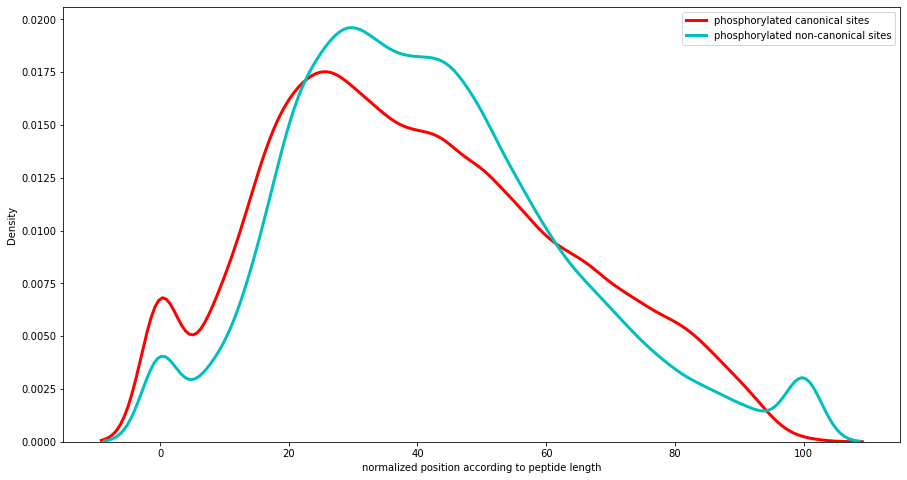

In [110]:
#sns.set(font_scale=1.4)
plt.figure(figsize=(15,8))      



plot1 = sns.distplot(data_scaled_P["scaled_pos"], hist=False, kde=True, label="phosphorylated canonical sites", bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'r'})
plot2 = sns.distplot(data_scaled_nonP["scaled_pos"], hist=False,kde=True, label="phosphorylated non-canonical sites",
                     bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'c'})

plt.legend()
plt.xlabel("normalized position according to peptide length")
#plt.savefig("P-sites versus non-P-site to peptide length.png", format="png", bbox_inches="tight")

We make the same kind of comparison per residue.

In [111]:
data_scaled_nonP["modres"].value_counts()

E    8926
D    6516
K    2253
C    1866
H    1523
R    1424
Name: modres, dtype: int64

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for ker

Text(0.5, 0, 'normalized position according to peptide length')

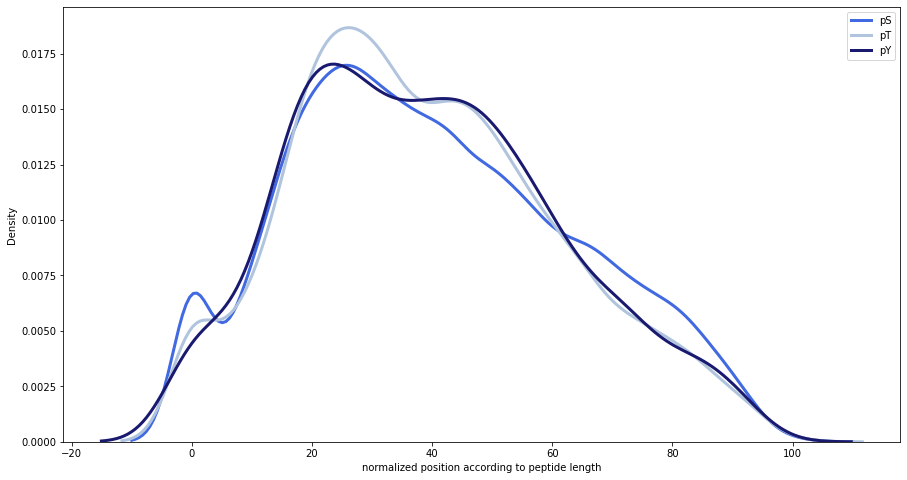

In [112]:
#sns.set(font_scale=1.4)
plt.figure(figsize=(15,8))      



plotS = sns.distplot(data_scaled_P.loc[data_scaled_P["modres"]=="S"]["scaled_pos"], hist=False, kde=True, label="pS", bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'royalblue'})
plotT = sns.distplot(data_scaled_P.loc[data_scaled_P["modres"]=="T"]["scaled_pos"], hist=False, kde=True, label="pT", bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'lightsteelblue'})
plotY = sns.distplot(data_scaled_P.loc[data_scaled_P["modres"]=="Y"]["scaled_pos"], hist=False, kde=True, label="pY", bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'midnightblue'})

plt.legend()
plt.xlabel("normalized position according to peptide length")
#plt.savefig("canonical P-sites versus non-P-site to peptide length.png", format="png", bbox_inches="tight")

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for ker

Text(0.5, 0, 'normalized position according to peptide length')

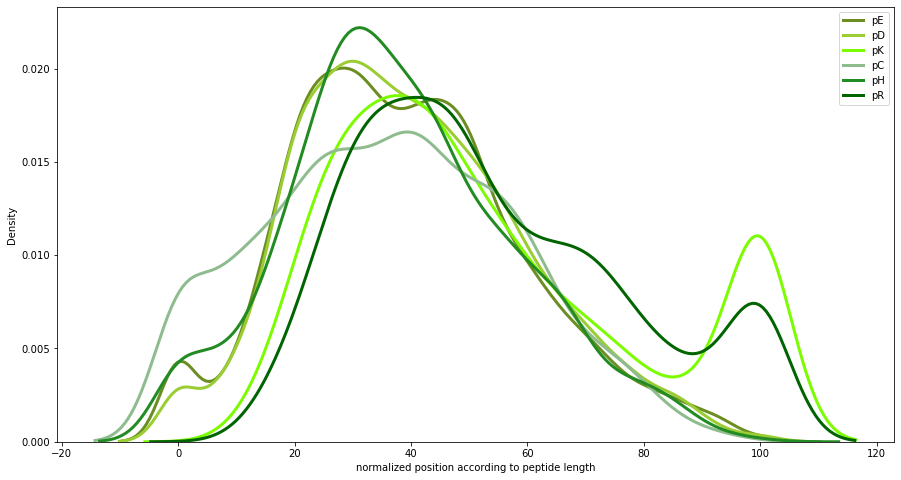

In [113]:
plt.figure(figsize=(15,8)) 
plotE = sns.distplot(data_scaled_nonP.loc[data_scaled_nonP["modres"]=="E"]["scaled_pos"], hist=False,kde=True, label="pE",
                     bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'olivedrab'})
plotD = sns.distplot(data_scaled_nonP.loc[data_scaled_nonP["modres"]=="D"]["scaled_pos"], hist=False,kde=True, label="pD",
                     bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'yellowgreen'})
plotK = sns.distplot(data_scaled_nonP.loc[data_scaled_nonP["modres"]=="K"]["scaled_pos"], hist=False,kde=True, label="pK",
                     bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'lawngreen'})
plotC = sns.distplot(data_scaled_nonP.loc[data_scaled_nonP["modres"]=="C"]["scaled_pos"], hist=False,kde=True, label="pC",
                     bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'darkseagreen'})
plotH = sns.distplot(data_scaled_nonP.loc[data_scaled_nonP["modres"]=="H"]["scaled_pos"], hist=False,kde=True, label="pH",
                     bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'forestgreen'})
plotR = sns.distplot(data_scaled_nonP.loc[data_scaled_nonP["modres"]=="R"]["scaled_pos"], hist=False,kde=True, label="pR",
                     bins='auto',color='darkred',\
             kde_kws={'linewidth': 3,'color':'darkgreen'})
plt.legend()
plt.xlabel("normalized position according to peptide length")
#plt.savefig("non-canonical P-sites to peptide length.png", format="png", bbox_inches="tight")

We'll now look at the frequency an experimental site is identified, and compare this for the STY-site to non STY-sites. This gives an indication of how reliable a phosphosite identification is. We calculate how many times site X on protein Y is identified as phosphorylated, irrespective of tissue. We do this both for the nonSTY phosphosite data, as for the STY phosphosite data.

In [114]:
data_nonSTY_gr = data_nonSTY.groupby(["ACC_ID", "modres", "UP_POS"], as_index=False)[["tissue", "peptide"]].agg({"tissue": lambda x:
                                                                                                    ",".join(x), "peptide": "count"})
print(data_nonSTY_gr.shape[0])
data_nonSTY_gr.head()

22536


,ACC_ID,modres,UP_POS,tissue,peptide
0,A0A075B759,C,62,"Umbilical cord,Umbilical cord,Umbilical cord,S...",45
1,A0A075B767,C,62,"Umbilical cord,Umbilical cord,Umbilical cord,S...",45
2,A0A087WV62,K,102,"Urinary bladder, Colon, Kidney, Liver",1
3,A0A087WVF3,K,34,"Colon,Colon,Lymph node,Lymph node,Lymph node,L...",7
4,A0A087WXS9,K,34,"Colon,Colon,Lymph node,Lymph node,Lymph node,L...",7


In [115]:
data_STY_gr = data_STY.groupby(["ACC_ID", "modres", "UP_POS"], as_index=False)[["tissue", "peptide"]].agg({"tissue": lambda x:
                                                                                                    ",".join(x), "peptide": "count"})
print(data_STY_gr.shape[0])
data_STY_gr.head()

23903


,ACC_ID,modres,UP_POS,tissue,peptide
0,A0A075B6H7,T,30,Lung,1
1,A0A075B6S5,S,52,Menstrual fluid,1
2,A0A087WXM9,S,223,Testis,1
3,A0A0B4J2D5,S,124,PBMC,1
4,A0A0B4J2D5,T,145,PBMC,1


[Text(0.5, 1.0, 'Number of times a phosphosite has been identified')]

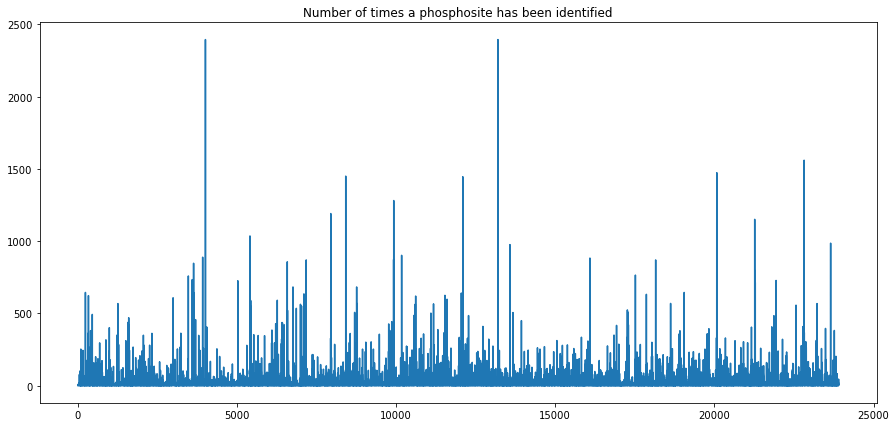

In [116]:
data_STY_gr["peptide"].plot(kind="line", figsize=(15,7)).set(title="Number of times a phosphosite has been identified")

[Text(0.5, 1.0, 'Number of times a phosphosite has been identified')]

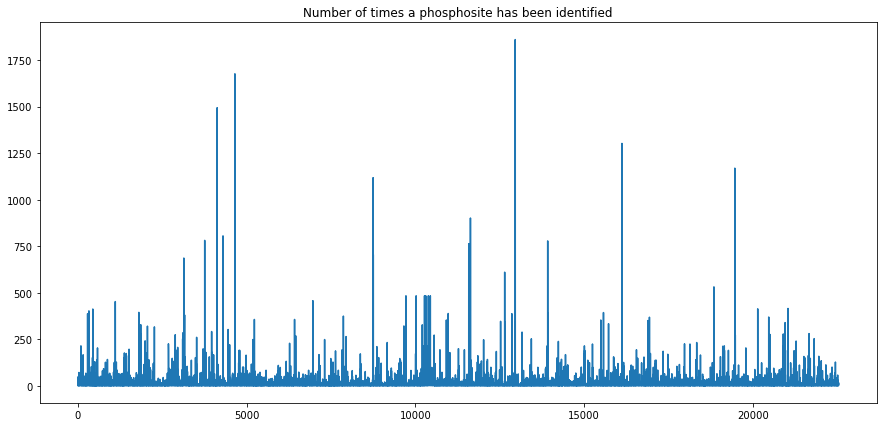

In [117]:
data_nonSTY_gr["peptide"].plot(kind="line",figsize=(15,7)).set(title="Number of times a phosphosite has been identified")

We'll now count, for each frequency of identification, how many phosphosites are identified. For example, the first record of the dataframe shows that 9549 phosphosites were identified once for the nonSTY phosphosites. Further down we do the same for the STY phosphosites. There, 8746 phosphosites were identified once.

In [118]:
data_nonSTY_IDcounts = data_nonSTY_gr.groupby(["peptide"], as_index=False)["ACC_ID"].count()
data_nonSTY_IDcounts

,peptide,ACC_ID
0,1,9549
1,2,3421
2,3,1845
3,4,1228
4,5,846
...,...,...
250,1169,1
251,1302,1
252,1494,1
253,1676,1


<AxesSubplot:title={'center':'Distribution of identification rate of non canonical phosphosites'}, xlabel='amount of identifications of a phosphosites', ylabel='number of phosphosites identified'>

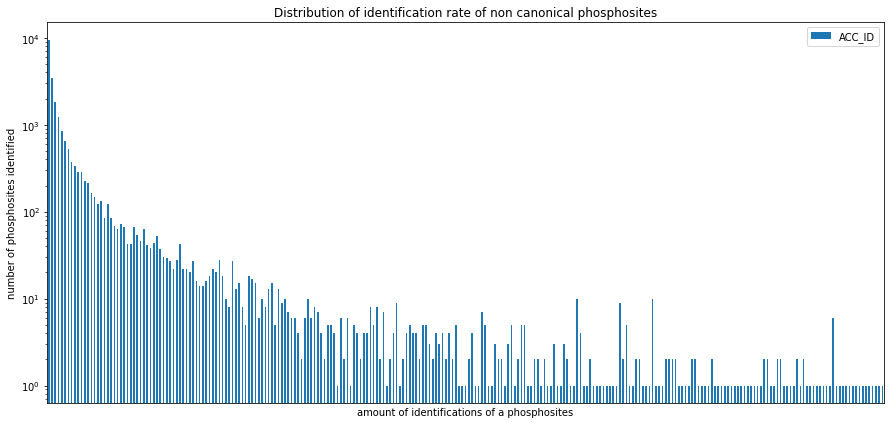

In [119]:
data_nonSTY_IDcounts.plot(kind="bar", x="peptide", y="ACC_ID", figsize=(15,7), logy=True, xticks = [], xlabel = "amount of identifications of a phosphosites", ylabel = "number of phosphosites identified", title="Distribution of identification rate of non canonical phosphosites")

In [120]:
data_STY_IDcounts = data_STY_gr.groupby(["peptide"], as_index=False)["ACC_ID"].count()
data_STY_IDcounts

,peptide,ACC_ID
0,1,8746
1,2,3350
2,3,1954
3,4,1294
4,5,913
...,...,...
394,1446,1
395,1450,1
396,1474,1
397,1560,1


<AxesSubplot:title={'center':'Distribution of identification rate of canonical phosphosites'}, xlabel='amount of identifications of a phosphosites', ylabel='number of phosphosites identified'>

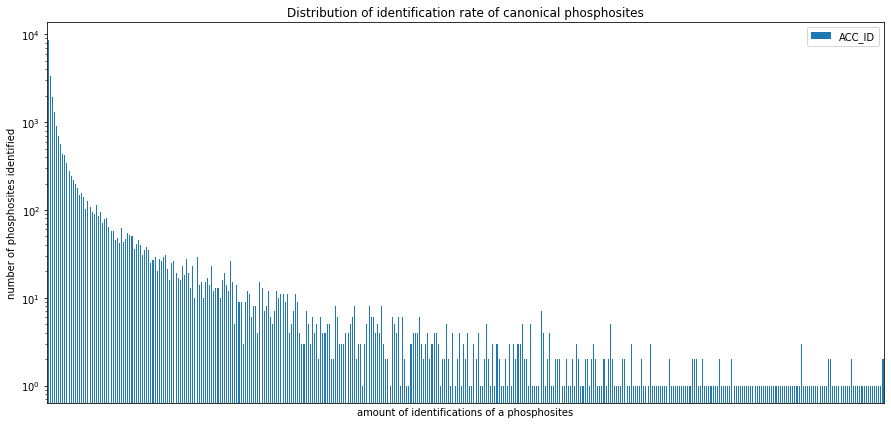

In [121]:
data_STY_IDcounts.plot(kind="bar", x="peptide", y="ACC_ID", figsize=(15,7), logy=True, xticks=[], xlabel = "amount of identifications of a phosphosites", ylabel = "number of phosphosites identified", title="Distribution of identification rate of canonical phosphosites")

In [122]:
data_IDcounts_comb = pd.merge(data_nonSTY_IDcounts, data_STY_IDcounts, how="outer", on=["peptide"], suffixes=["_nonSTY", "_STY"])
data_IDcounts_comb

,peptide,ACC_ID_nonSTY,ACC_ID_STY
0,1,9549.0,8746.0
1,2,3421.0,3350.0
2,3,1845.0,1954.0
3,4,1228.0,1294.0
4,5,846.0,913.0
...,...,...,...
439,1446,NaN,1.0
440,1450,NaN,1.0
441,1474,NaN,1.0
442,1560,NaN,1.0


When comparing the frequency of identification in the plot below, we notice that STY sites are in general identified on more seperate occasions than nonSTY sites.

<AxesSubplot:title={'center':'Comparison of identification rate of canonical sites versus non-canonical sites'}, xlabel='amount of identifications of a phosphosites', ylabel='number of phosphosites identified'>

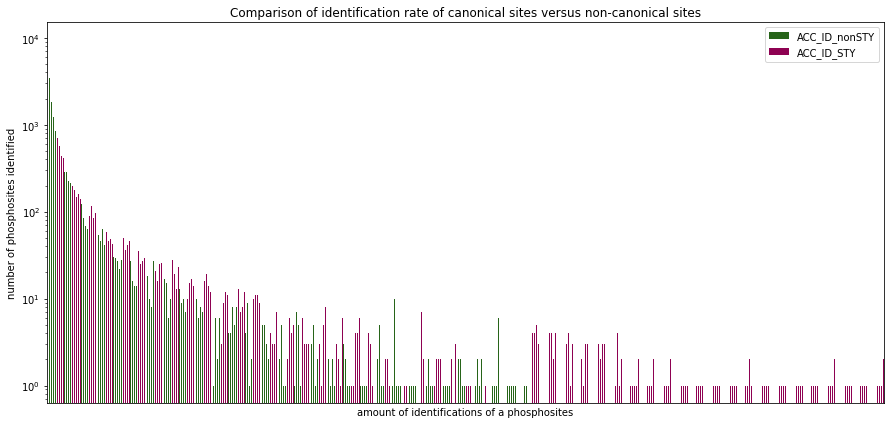

In [123]:
data_IDcounts_comb.plot(kind="bar", x="peptide", figsize=(15,7), logy=True, xticks=[], xlabel = "amount of identifications of a phosphosites", ylabel = "number of phosphosites identified", colormap="PiYG_r", title = "Comparison of identification rate of canonical sites versus non-canonical sites")

In [124]:
data_comb_gr = pd.merge(data_nonSTY_gr[["ACC_ID", "peptide"]], data_STY_gr[["ACC_ID", "peptide"]], how="outer", on="ACC_ID", suffixes=["_nonSTY", "_STY"])
data_comb_gr.head()

,ACC_ID,peptide_nonSTY,peptide_STY
0,A0A075B759,45.0,NaN
1,A0A075B767,45.0,NaN
2,A0A087WV62,1.0,NaN
3,A0A087WVF3,7.0,NaN
4,A0A087WXS9,7.0,NaN


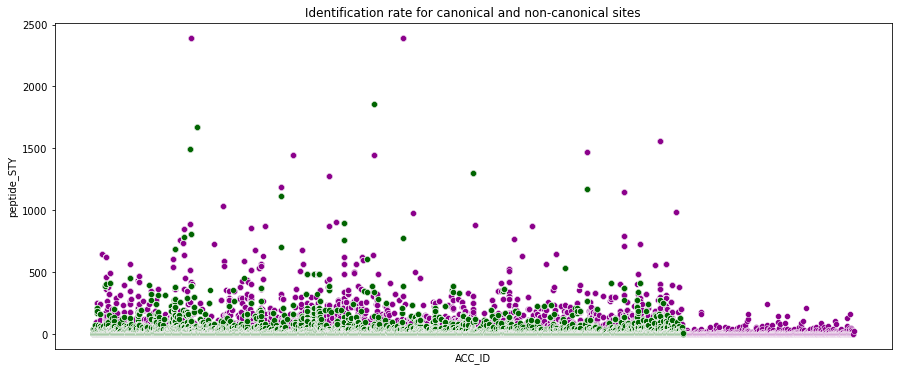

In [125]:
plt.figure(figsize=(15,6))
sns.scatterplot(x="ACC_ID", y="peptide_STY",data=data_comb_gr, color = "darkmagenta")
sns.scatterplot(x="ACC_ID", y="peptide_nonSTY", data=data_comb_gr, color = "darkgreen")
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xticks([],[])
plt.title("Identification rate for canonical and non-canonical sites")
plt.show()

The identification rate seems slightly lower for the non-canonical sites. However, considering that non-canonical phosphorylation might be rare, this is not unxpected.

In [126]:
print(data_comb_gr["peptide_nonSTY"].describe())
print(data_comb_gr["peptide_STY"].describe())

count    235921.000000
mean         13.047796
std          51.255418
min           1.000000
25%           1.000000
50%           2.000000
75%           8.000000
max        1860.000000
Name: peptide_nonSTY, dtype: float64
count    236369.000000
mean         22.972006
std          84.011879
min           1.000000
25%           1.000000
50%           3.000000
75%          12.000000
max        2395.000000
Name: peptide_STY, dtype: float64


We'll now have a look at the enrichment strategies used in the dataset for the different projects considered here. We load in the data that contains four extra columns: "enrichment", denoting whether a project used any enrichment strategies, "modification", denoting what modification was enriched, "method", denoting the exact strategy or kit used, and "additional", giving additional information when available.

In [127]:
data_enrich_NaN = pd.read_csv("phospho_data_tissue_annotation_enrichment1.txt", sep="\t")
data_enrich_NaN.shape[0]

646016

In [128]:
data_enrich = data_enrich_NaN.dropna(inplace = False, subset=["tissue"])
data_enrich = data_enrich[(data_enrich["modres"]=="S")|(data_enrich["modres"]=="T")|(data_enrich["modres"]=="Y")]
print(data_enrich.shape[0])
data_enrich.head()

377186


,proj,peptide,modres,UP_POS,ACC_ID,pep_start,pep_end,tissue,enrichment,modification,method,additional
0,PXD000004,RPPSPEPSTK,S,2102,Q01082,2099,2108,Brain,None,None,None,None
3,PXD000004,AISPTSATSSGR,S,600,Q9Y4I1,598,609,Brain,None,None,None,None
4,PXD000004,FYYTAGSSSPTHAK,S,198,O75508,190,203,Brain,None,None,None,None
5,PXD000004,TSASIGSLCADAR,S,199,P60201,193,205,Brain,None,None,None,None
9,PXD000004,SLSTSGESLYHVLGLDK,S,10,Q9H3Z4,8,24,Brain,None,None,None,None


In [129]:
data_enrich_proj = data_enrich.groupby(["proj"], as_index=False)[["tissue", "enrichment", "modification", "method", "additional"]].agg({"tissue": "first",
                                                                                                                                       "enrichment": "first",
                                                                                                                                       "modification": "first",
                                                                                                                                       "method": "first",
                                                                                                                                       "additional": "first"})
data_enrich_proj.head()

,proj,tissue,enrichment,modification,method,additional
0,PXD000004,Brain,None,None,None,None
1,PXD000072,Blood,None,None,None,None
2,PXD000529,Liver,None,None,None,None
3,PXD000533,Liver,None,None,None,None
4,PXD000605,Blood,Yes,Low abundance proteins,Human Multiple Affinity Removal System,"depletion of high abundance proteins, enrichme..."


Out of the 150 projects, 116 are not enriched. 4 projects submitted to PRIDE made use of both enrichment strategies and didn't use enrichment strategies. As the datasrts were not submitted seperately, we are unable to distinguish between them. 28 projects were enriched, and for 2 projects, it was impossible to determine. Out of these 28, 15 were phosphorylation enriched. Another major playor was depletion of high abundance proteins in favor of low abundant proteins. 9 of these made use of TiO2n 5 of IMAC and only 1 of pTyr antibodies.

In [130]:
data_enrich_proj["enrichment"].value_counts(dropna=False)
#total equals 150

None    116
Yes      28
Both      4
NaN       2
Name: enrichment, dtype: int64

In [131]:
data_enrich_proj["modification"].value_counts(dropna=False)

None                             118
Phosphorylation                   15
Low abundance proteins             7
low abundance proteins             3
NaN                                2
N-glycosylation                    1
Proteasomal degradation            1
O-glycosilation                    1
Low molecular weight proteins      1
glycation                          1
Name: modification, dtype: int64

In [132]:
data_enrich_proj[data_enrich_proj["modification"]=="Proteasomal degradation"]

,proj,tissue,enrichment,modification,method,additional
109,PXD009112,Blood,Yes,Proteasomal degradation,MAPP,cross-linking and IP of cellular proteasomes


In [133]:
data_enrich_proj[(data_enrich_proj["modification"]=="Low abundance proteins")|(data_enrich_proj["modification"]=="low abundance proteins")]

,proj,tissue,enrichment,modification,method,additional
4,PXD000605,Blood,Yes,Low abundance proteins,Human Multiple Affinity Removal System,"depletion of high abundance proteins, enrichme..."
46,PXD004624,Blood,Yes,Low abundance proteins,Pierce¬ Top 12 Abundant Protein Depletion Spin...,"depletion of high abundance proteins, enrichme..."
47,PXD004625,Blood,Yes,Low abundance proteins,Pierce¬ Top 12 Abundant Protein Depletion Spin...,"depletion of high abundance proteins, enrichme..."
48,PXD004626,Blood,Yes,Low abundance proteins,Pierce¬ Top 12 Abundant Protein Depletion Spin...,"depletion of high abundance proteins, enrichme..."
71,PXD006833,"Urinary bladder, Colon, Kidney, Liver",Yes,Low abundance proteins,ProteoMiner,"depletion of high abundance proteins, enrichme..."
73,PXD006863,Peritoneal dialysis fluid,Yes,Low abundance proteins,ProteoMiner,"depletion of high abundance proteins, enrichme..."
81,PXD007234,Menstrual fluid,Yes,Low abundance proteins,ProteoMiner,"depletion of high abundance proteins, enrichme..."
98,PXD008467,Blood,Yes,low abundance proteins,agarose-linked paraaminobenzamidine slurry,"depletion of high abundance proteins, enrichme..."
99,PXD008468,Blood,Yes,low abundance proteins,agarose-linked paraaminobenzamidine slurry,"depletion of high abundance proteins, enrichme..."
134,PXD010150,"Hela, Pancreas",Yes,low abundance proteins,NanoPOTS,"depletion of high abundance proteins, enrichme..."


In [134]:
data_enrich_proj[data_enrich_proj["modification"]=="Phosphorylation"]

,proj,tissue,enrichment,modification,method,additional
24,PXD002883,Blood,Yes,Phosphorylation,TiO2,None
25,PXD002990,Lymph node,Yes,Phosphorylation,TiO2,None
66,PXD006581,Blood,Yes,Phosphorylation,IMAC,Fe-NTA loaded beads
68,PXD006607,Brain,Both,Phosphorylation,TiO2,both proteomics and phosphoproteomics
77,PXD007122,Lung,Yes,Phosphorylation,TiO2,None
78,PXD007123,Lung,Yes,Phosphorylation,TiO2,None
79,PXD007137,Lung,Yes,Phosphorylation,"pTyrAb, gel","PTMScan Phospho-Tyrosine Mouse mAb, PHOS-Selec..."
87,PXD007740,Colon,Yes,Phosphorylation,IMAC,GELoader tips (Ti4+)
103,PXD008832,Ovary,Yes,Phosphorylation,IMAC,Fe3+-NTA-agarose
130,PXD009916,Lung,Both,Phosphorylation,TiO2,"TiO2?beads (SHIMADZU, Kyoto, Japan)"


In [135]:
data_enrich_proj["method"].value_counts(dropna=False)

None                                                      116
TiO2                                                        9
IMAC                                                        5
Pierce¬ Top 12 Abundant Protein Depletion Spin Columns      3
ProteoMiner                                                 3
NaN                                                         2
agarose-linked paraaminobenzamidine slurry                  2
RAX enzyme-substrate reaction                               1
NHS-Sepharose beads                                         1
NanoPOTS                                                    1
filter                                                      1
pTyrAb, gel                                                 1
MAPP                                                        1
Sarko-spin                                                  1
Human Multiple Affinity Removal System                      1
Solid Phase Extraction                                      1
boronate

In [136]:
data_enrich_proj[data_enrich_proj["method"]=="pTyrAb, gel"]

,proj,tissue,enrichment,modification,method,additional
79,PXD007137,Lung,Yes,Phosphorylation,"pTyrAb, gel","PTMScan Phospho-Tyrosine Mouse mAb, PHOS-Selec..."


In [137]:
data_enrich_proj[(data_enrich_proj["enrichment"]=="Yes")&(data_enrich_proj["modification"]=="None")]

,proj,tissue,enrichment,modification,method,additional
89,PXD007873,Brain,Yes,None,Sarko-spin,"enriches for TDP-43, important protein in ALS,..."
144,PXD010787,Lung,Yes,None,NHS-Sepharose beads,Drug affinity purification (target: kinase)


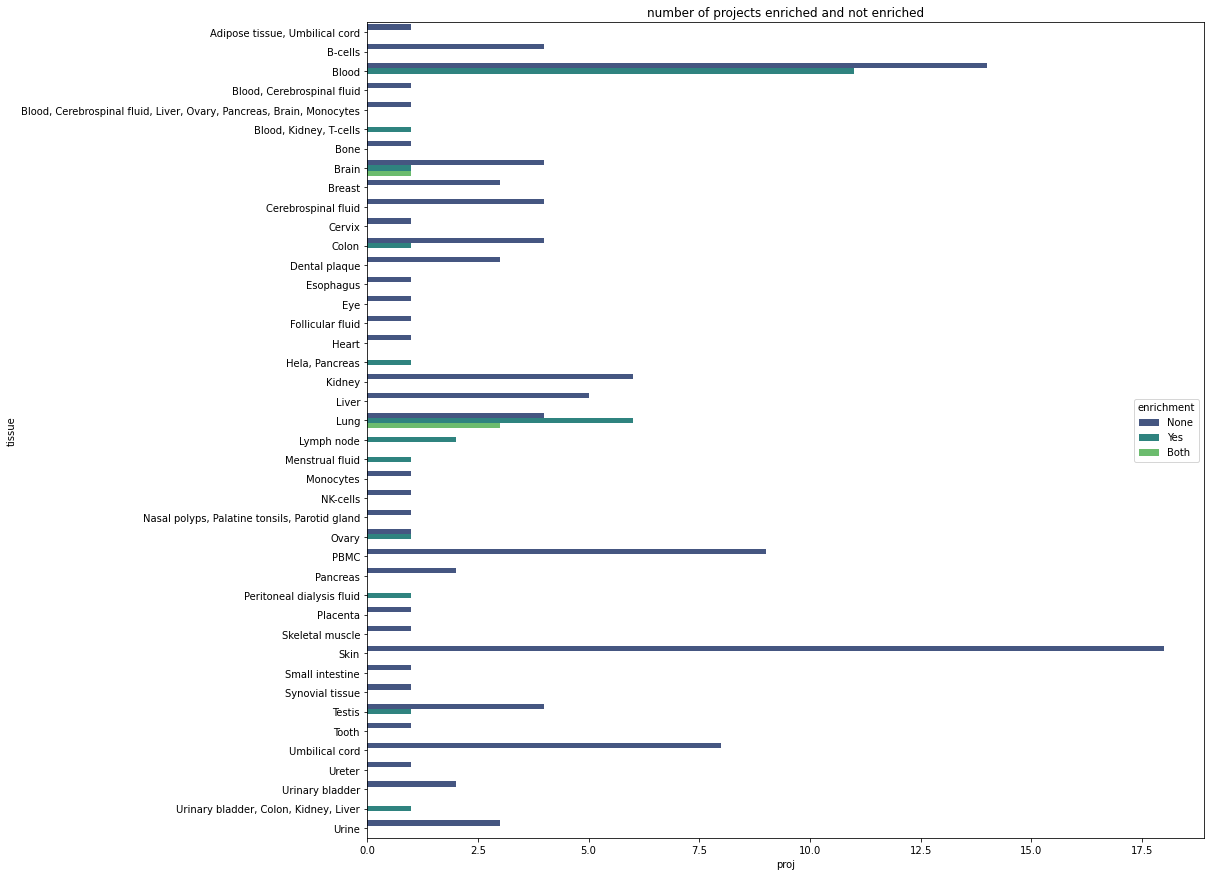

In [138]:
proj_counts_per_tissue = data_enrich.groupby(["tissue","enrichment"], as_index=False)["proj"].nunique()
plt.figure(figsize=(15,15))
sns.barplot(x=proj_counts_per_tissue["proj"], y=proj_counts_per_tissue["tissue"], hue=proj_counts_per_tissue["enrichment"], palette="viridis").set(title = "number of projects enriched and not enriched")
plt.show()

Lymph node is the only tissue without any non enriched projects for phosphorylation. Lung has more enriched projects than non enriched proejcts. 1/3 of the projects in Ovary was also enriched for phosphorylation. 

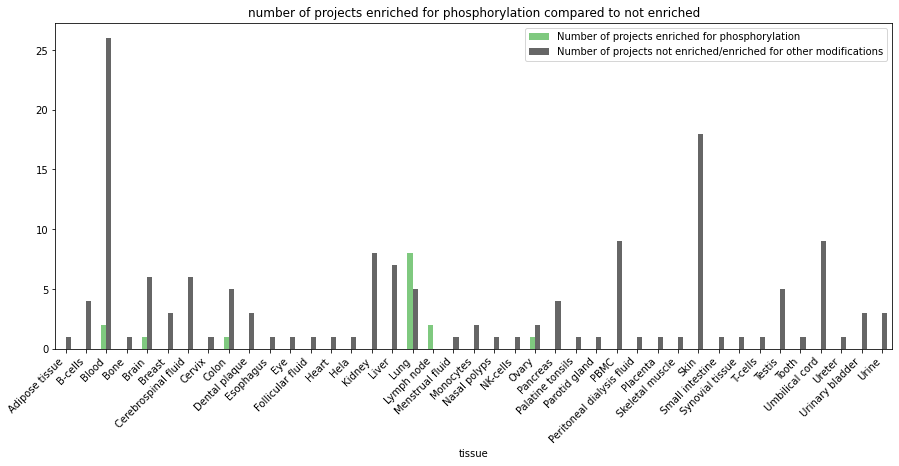

In [139]:
proj_enrichment_counts = data_enrich.groupby(["tissue", "modification"], as_index=False)["proj"].nunique()
proj_enrichment_counts_plot = pd.DataFrame({"tissue": list_tissues_STY})
list_counts_nonP = []
list_counts_P = []
for tissue in list_tissues_STY:
    count_nonP = proj_enrichment_counts.loc[((proj_enrichment_counts["tissue"].str.contains(tissue))&(proj_enrichment_counts["modification"]!="Phosphorylation")), "proj"].sum()
    count_P = proj_enrichment_counts.loc[((proj_enrichment_counts["tissue"].str.contains(tissue))&(proj_enrichment_counts["modification"]=="Phosphorylation")), "proj"].sum()
    list_counts_nonP.append(count_nonP)
    list_counts_P.append(count_P)
    
proj_enrichment_counts_plot["Number of projects enriched for phosphorylation"] = list_counts_P
proj_enrichment_counts_plot["Number of projects not enriched/enriched for other modifications"] = list_counts_nonP
proj_enrichment_counts_plot

proj_enrichment_counts_plot.plot(kind="bar", x="tissue", figsize=(15,6), colormap="Accent", title="number of projects enriched for phosphorylation compared to not enriched")
plt.xticks(rotation=45, ha="right")
#plt.savefig("Enriched projects.png", format="png",  bbox_inches="tight")
plt.show()

We'll nox compare enrichment for the canonical sites compared to the non canonical sites. On average, more proteins having canonical sites have been identified using enrichment compared to proteins having non-canonical sites.

In [140]:
data_enrich_NaN = pd.read_csv("phospho_data_tissue_annotation_enrichment1.txt", sep="\t")
data_enrich = data_enrich_NaN.dropna(inplace = False, subset=["tissue"])
data_enrich_STY = data_enrich[(data_enrich["modres"]=="S")|(data_enrich["modres"]=="T")|(data_enrich["modres"]=="Y")]
data_enrich_nonSTY = data_enrich[(data_enrich["modres"]!="S")&(data_enrich["modres"]!="T")&(data_enrich["modres"]!="Y")]

In [141]:
data_enrich_nonSTY_proj = data_enrich_nonSTY.groupby(["proj"], as_index=False)[["tissue", "enrichment", "modification", "method", "additional"]].agg({"tissue": "first",
                                                                                                                                       "enrichment": "first",
                                                                                                                                       "modification": "first",
                                                                                                                                       "method": "first",
                                                                                                                                       "additional": "first"})
data_enrich_STY_proj = data_enrich_STY.groupby(["proj"], as_index=False)[["tissue", "enrichment", "modification", "method", "additional"]].agg({"tissue": "first",
                                                                                                                                       "enrichment": "first",
                                                                                                                                       "modification": "first",
                                                                                                                                       "method": "first",
                                                                                                                                       "additional": "first"})

In [142]:
data_enrich_nonSTY_proj["enrichment"].value_counts(dropna=False)

None    123
Yes      27
Both      4
NaN       2
Name: enrichment, dtype: int64

In [143]:
data_enrich_STY_proj["enrichment"].value_counts(dropna=False)

None    116
Yes      28
Both      4
NaN       2
Name: enrichment, dtype: int64

In [144]:
data_enrich_nonSTY_proj["modification"].value_counts(dropna=False) #one low abundance protein enrichment project doesn't have nonSTY

None                             125
Phosphorylation                   15
Low abundance proteins             6
low abundance proteins             3
NaN                                2
N-glycosylation                    1
Proteasomal degradation            1
O-glycosilation                    1
Low molecular weight proteins      1
glycation                          1
Name: modification, dtype: int64

In [145]:
data_enrich_STY_proj["modification"].value_counts(dropna=False)

None                             118
Phosphorylation                   15
Low abundance proteins             7
low abundance proteins             3
NaN                                2
N-glycosylation                    1
Proteasomal degradation            1
O-glycosilation                    1
Low molecular weight proteins      1
glycation                          1
Name: modification, dtype: int64

In [146]:
data_enrich_nonSTY_proj[data_enrich_nonSTY_proj["modification"]=="Phosphorylation"] #Pierce Kinase Enrichment Kit with ActivX Probe...

,proj,tissue,enrichment,modification,method,additional
24,PXD002883,Blood,Yes,Phosphorylation,TiO2,None
25,PXD002990,Lymph node,Yes,Phosphorylation,TiO2,None
58,PXD006095,Lung,Yes,Phosphorylation,Pierce Kinase Enrichment Kit with ActivX Probe...,enriches for kinases
68,PXD006581,Blood,Yes,Phosphorylation,IMAC,Fe-NTA loaded beads
70,PXD006607,Brain,Both,Phosphorylation,TiO2,both proteomics and phosphoproteomics
80,PXD007122,Lung,Yes,Phosphorylation,TiO2,None
81,PXD007123,Lung,Yes,Phosphorylation,TiO2,None
82,PXD007137,Lung,Yes,Phosphorylation,"pTyrAb, gel","PTMScan Phospho-Tyrosine Mouse mAb, PHOS-Selec..."
90,PXD007740,Colon,Yes,Phosphorylation,IMAC,GELoader tips (Ti4+)
107,PXD008832,Ovary,Yes,Phosphorylation,IMAC,Fe3+-NTA-agarose


In [147]:
data_enrich_STY_proj[data_enrich_STY_proj["modification"]=="Phosphorylation"]

,proj,tissue,enrichment,modification,method,additional
24,PXD002883,Blood,Yes,Phosphorylation,TiO2,None
25,PXD002990,Lymph node,Yes,Phosphorylation,TiO2,None
66,PXD006581,Blood,Yes,Phosphorylation,IMAC,Fe-NTA loaded beads
68,PXD006607,Brain,Both,Phosphorylation,TiO2,both proteomics and phosphoproteomics
77,PXD007122,Lung,Yes,Phosphorylation,TiO2,None
78,PXD007123,Lung,Yes,Phosphorylation,TiO2,None
79,PXD007137,Lung,Yes,Phosphorylation,"pTyrAb, gel","PTMScan Phospho-Tyrosine Mouse mAb, PHOS-Selec..."
87,PXD007740,Colon,Yes,Phosphorylation,IMAC,GELoader tips (Ti4+)
103,PXD008832,Ovary,Yes,Phosphorylation,IMAC,Fe3+-NTA-agarose
130,PXD009916,Lung,Both,Phosphorylation,TiO2,"TiO2?beads (SHIMADZU, Kyoto, Japan)"


In [148]:
data_enrich_nonSTY_proj["method"].value_counts(dropna=False)

None                                                        123
TiO2                                                          9
IMAC                                                          4
Pierce¬ Top 12 Abundant Protein Depletion Spin Columns        3
ProteoMiner                                                   3
NaN                                                           2
agarose-linked paraaminobenzamidine slurry                    2
RAX enzyme-substrate reaction                                 1
NHS-Sepharose beads                                           1
NanoPOTS                                                      1
filter                                                        1
pTyrAb, gel                                                   1
MAPP                                                          1
Sarko-spin                                                    1
Solid Phase Extraction                                        1
Pierce Kinase Enrichment Kit with ActivX

In [149]:
data_enrich_STY_proj["method"].value_counts(dropna=False)

None                                                      116
TiO2                                                        9
IMAC                                                        5
Pierce¬ Top 12 Abundant Protein Depletion Spin Columns      3
ProteoMiner                                                 3
NaN                                                         2
agarose-linked paraaminobenzamidine slurry                  2
RAX enzyme-substrate reaction                               1
NHS-Sepharose beads                                         1
NanoPOTS                                                    1
filter                                                      1
pTyrAb, gel                                                 1
MAPP                                                        1
Sarko-spin                                                  1
Human Multiple Affinity Removal System                      1
Solid Phase Extraction                                      1
boronate

In [150]:
print(data_enrich_nonSTY[data_enrich_nonSTY["enrichment"]=="Yes"].shape[0])
print(data_enrich_STY[data_enrich_STY["enrichment"]=="Yes"].shape[0])

122790
305226


In [151]:
print(data_enrich_nonSTY[data_enrich_nonSTY["enrichment"]=="Yes"]["ACC_ID"].nunique())
print(data_enrich_STY[data_enrich_STY["enrichment"]=="Yes"]["ACC_ID"].nunique())

4098
4606


## Cross-referencing tissue annotation with tissue annotation from UniProtKB

We'll now consider whether our tissue annotation is in accordance with tissue annotation from UniProtKB. However, tissue annotation from UniProtKB was not, at that point, based on controlled vocabularies, resulting in difficulties.

In [152]:
uniprot_tissue = pd.read_csv("uniprot_tissue_annotation.tab", sep="\t")
uniprot_tissue = uniprot_tissue[["Entry", "Tissue specificity"]]
uniprot_tissue.dropna(subset=["Tissue specificity"], inplace=True)
uniprot_tissue.rename({"Entry": "ACC_ID"}, axis=1, inplace=True)
print(uniprot_tissue.shape[0])
uniprot_tissue.head()

9949


,ACC_ID,Tissue specificity
0,Q00266,TISSUE SPECIFICITY: Expressed in liver. {ECO:0...
3,Q8TDZ2,"TISSUE SPECIFICITY: Expressed in the thymus, l..."
5,Q8N635,"TISSUE SPECIFICITY: In fetal gonads, specifica..."
6,O15553,TISSUE SPECIFICITY: Expressed in peripheral bl...
7,Q8NCK7,"TISSUE SPECIFICITY: Expressed in liver, saliva..."


In [153]:
data_protein_STY_ann = pd.merge(data_protein_STY, uniprot_tissue, how="inner", on="ACC_ID")
print(data_protein_STY.shape[0])
print(data_protein_STY_ann.shape[0])
data_protein_STY_ann.head()

5855
3262


,ACC_ID,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,Bronchoalveolar lavage,Cartilage,Cerebrospinal fluid,...,Immune system and lymfatic system,Integumentary system,Muscular system,Nervous system,Reproductive system,Respiratory system,Skeletal system,Urinary and renal system,Total_systems,Tissue specificity
0,A0FGR8,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,4,TISSUE SPECIFICITY: Widely expressed with high...
1,A1A4S6,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,TISSUE SPECIFICITY: High levels of expression ...
2,A1KXE4,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3,"TISSUE SPECIFICITY: Expressed in the brain, wi..."
3,A1L0T0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,TISSUE SPECIFICITY: Expressed in all tissues t...
4,A1X283,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,TISSUE SPECIFICITY: Expressed in fibroblasts. ...


In [154]:
data_protein_STY_ann["Tissue specificity"].value_counts()

TISSUE SPECIFICITY: Ubiquitous.                                                                                                                                                                                                                                                                                                                                                                                                     79
TISSUE SPECIFICITY: Widely expressed.                                                                                                                                                                                                                                                                                                                                                                                               21
TISSUE SPECIFICITY: Ubiquitously expressed.                                                                                                               

In [155]:
data_protein_STY_ann["check"] = 0
for tissue in list_tissues_STY:
    tissue_l = tissue.lower()
    data_protein_STY_ann.loc[(data_protein_STY_ann[tissue]==1)&((data_protein_STY_ann["Tissue specificity"].str.contains(tissue_l)==False)|(data_protein_STY_ann["Tissue specificity"].str.contains(tissue)==False)),"check"] = "No"
    data_protein_STY_ann.loc[(data_protein_STY_ann[tissue]==1)&((data_protein_STY_ann["Tissue specificity"].str.contains(tissue_l)|((data_protein_STY_ann["Tissue specificity"].str.contains(tissue))))),"check"] = "Yes"
data_protein_STY_ann.loc[((data_protein_STY_ann["Tissue specificity"].str.contains("Ubiquitous"))|(data_protein_STY_ann["Tissue specificity"].str.contains("Ubiquitously"))|(data_protein_STY_ann["Tissue specificity"].str.contains("Widely"))), "check"] = "Widely expressed"

In [156]:
data_protein_STY_ann["check"].value_counts()

No                  1942
Widely expressed     984
Yes                  336
Name: check, dtype: int64

For 1303 out of 3262 proteins we were able to verify the annotation in Uniprot, this annotation proves that our annotation is correct.

In [157]:
print(984+319)

1303


Out of our top 5 represented tissues (colon, blood, liver, lung and lymph node), only two are well represented in Uniprot.

<AxesSubplot:xlabel='Tissue'>

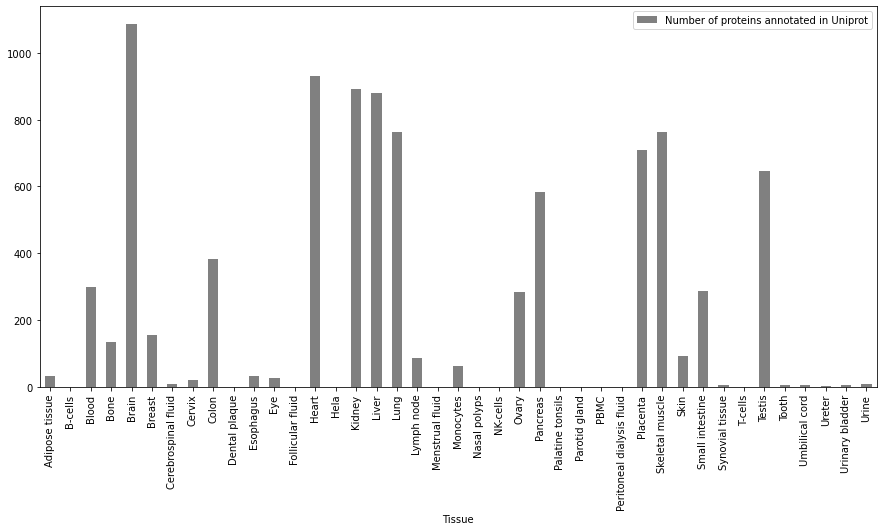

In [158]:
list_sums = []
for tissue in list_tissues_STY:
    tissue_l = tissue.lower()
    sums = data_protein_STY_ann[data_protein_STY_ann["Tissue specificity"].str.contains(tissue_l)]["ACC_ID"].count()
    list_sums.append(sums)
uniprot_tissue_rep = pd.DataFrame({"Tissue": list_tissues_STY, "Number of proteins annotated in Uniprot": list_sums})
uniprot_tissue_rep.plot(x="Tissue", kind="bar", figsize=(15,7), color="grey")

In [159]:
uniprot_tissue_rep[uniprot_tissue_rep["Number of proteins annotated in Uniprot"]==0]

,Tissue,Number of proteins annotated in Uniprot
1,B-cells,0
9,Dental plaque,0
12,Follicular fluid,0
14,Hela,0
19,Menstrual fluid,0
21,Nasal polyps,0
22,NK-cells,0
25,Palatine tonsils,0
26,Parotid gland,0
27,PBMC,0


In [160]:
uniprot_tissue_rep

,Tissue,Number of proteins annotated in Uniprot
0,Adipose tissue,33
1,B-cells,0
2,Blood,300
3,Bone,135
4,Brain,1085
5,Breast,154
6,Cerebrospinal fluid,7
7,Cervix,19
8,Colon,383
9,Dental plaque,0


Even considering all Uniprot annotation, 3 out of 5 major players in term of tissue representation on the protein level are severely underepresented.

<AxesSubplot:xlabel='Tissue'>

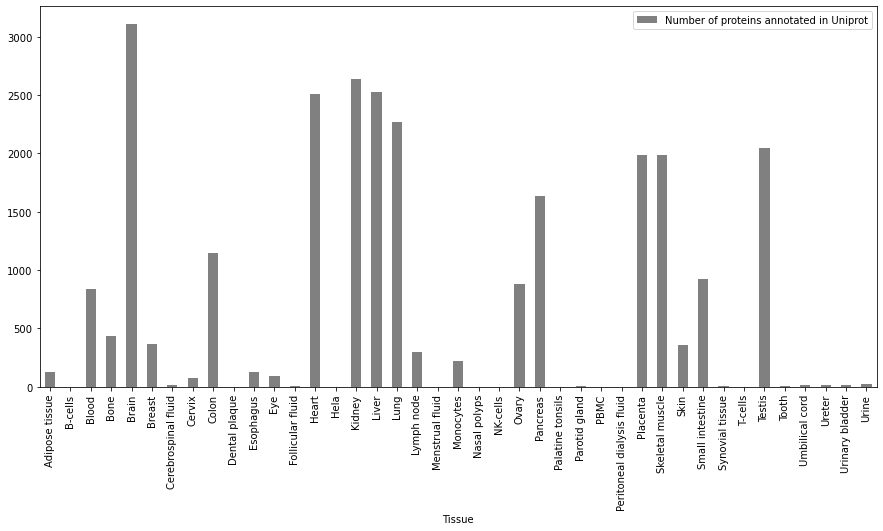

In [161]:
list_sums = []
for tissue in list_tissues_STY:
    tissue_l = tissue.lower()
    sums = uniprot_tissue[uniprot_tissue["Tissue specificity"].str.contains(tissue_l)]["ACC_ID"].count()
    list_sums.append(sums)
uniprot_tissue_all = pd.DataFrame({"Tissue": list_tissues_STY, "Number of proteins annotated in Uniprot": list_sums})
uniprot_tissue_all.plot(x="Tissue", kind="bar", figsize=(15,7), color="grey")

At the time of retrieval, no standard vocabulary was used by UniProtKB for denoting tissues. This probably results in a lot of false negatives.